In [1]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    dones = tf.placeholder(tf.float32, [None], name='dones')
    rates = tf.placeholder(tf.float32, [None], name='rates') # success rate
    return states, actions, next_states, rewards, dones, rates

In [4]:
def Act(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Act', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        return logits

In [5]:
def Env(states, actions, state_size, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('Env', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        states_logits = tf.layers.dense(inputs=nl2, units=state_size, trainable=False)
        Qlogits = tf.layers.dense(inputs=nl2, units=1, trainable=False)
        return states_logits, Qlogits

In [6]:
def model_loss(state_size, action_size, hidden_size, gamma,
               states, actions, next_states, rewards, dones, rates):
    ################################################ a = act(s)
    actions_logits = Act(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    aloss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels))
    ################################################ s', r = env(s, a)
    e_next_states_logits, eQs = Env(actions=actions_labels, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size)
    a_next_states_logits, aQs = Env(actions=actions_logits, states=states, hidden_size=hidden_size, 
                                    action_size=action_size, state_size=state_size, reuse=True)
    next_states_labels = tf.nn.sigmoid(next_states)
    eloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=e_next_states_logits, # GQN
                                                                   labels=next_states_labels))
    eloss += -tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                     labels=next_states_labels)) # maximize loss
    aloss2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=a_next_states_logits, 
                                                                    labels=next_states_labels)) # minimize loss
    #################################################### s'', Q' = ~env(s', ~a')
    next_actions_logits = Act(states=next_states, hidden_size=hidden_size, action_size=action_size, reuse=True)
    next_states_logits, aQs2 = Env(actions=next_actions_logits, states=next_states, hidden_size=hidden_size, 
                                   action_size=action_size, state_size=state_size, reuse=True)
    eQs_logits = tf.reshape(eQs, shape=[-1])
    aQs_logits = tf.reshape(aQs, shape=[-1])
    aQs2_logits = tf.reshape(aQs2, shape=[-1]) * (1-dones)
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=eQs_logits, # GAN
                                                                    labels=rates)) # 0-1 real
    eloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                    labels=tf.zeros_like(rates))) # min
    aloss2 += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=(aQs_logits+aQs2_logits)/2, # GAN
                                                                     labels=tf.ones_like(rates))) # max
    ###################################################### Q(s,a)= r + Q'(s',a')
    targetQs = rewards + (gamma * aQs2_logits) # DQN/Qlearning
    eloss += tf.reduce_mean(tf.square(eQs_logits - targetQs)) # real
    # eloss += tf.reduce_mean(tf.square(aQs_logits - rewards)) # min
    # aloss2 += tf.reduce_mean(tf.square(aQs_logits - targetQs)) # max
    eloss += tf.reduce_mean((aQs_logits+aQs2_logits)/2) # min
    aloss2 += -tf.reduce_mean((aQs_logits+aQs2_logits)/2) # max
    return actions_logits, aloss, eloss, aloss2

In [7]:
def model_opt(a_loss, e_loss, a_loss2, a_learning_rate, e_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    a_vars = [var for var in t_vars if var.name.startswith('Act')]
    e_vars = [var for var in t_vars if var.name.startswith('Env')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        a_opt = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss, var_list=a_vars)
        e_opt = tf.train.AdamOptimizer(e_learning_rate).minimize(e_loss, var_list=e_vars)
        a_opt2 = tf.train.AdamOptimizer(a_learning_rate).minimize(a_loss2, var_list=a_vars)
    return a_opt, e_opt, a_opt2

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, a_learning_rate, e_learning_rate, gamma):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.next_states, self.rewards, self.dones, self.rates = model_input(
            state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.a_loss, self.e_loss, self.a_loss2 = model_loss(
            state_size=state_size, action_size=action_size, hidden_size=hidden_size, gamma=gamma, # model init
            states=self.states, actions=self.actions, next_states=self.next_states, 
            rewards=self.rewards, dones=self.dones, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.a_opt, self.e_opt, self.a_opt2 = model_opt(a_loss=self.a_loss, 
                                                        e_loss=self.e_loss,
                                                        a_loss2=self.a_loss2, 
                                                        a_learning_rate=a_learning_rate,
                                                        e_learning_rate=e_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
#         return [self.buffer[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
a_learning_rate = 1e-4         # Q-network learning rate
e_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size
gamma=0.99

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, gamma=gamma,
              a_learning_rate=a_learning_rate, e_learning_rate=e_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    rate = -1
    memory.buffer.append([state, action, next_state, reward, float(done), rate])
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        #print(done)
        rate = total_reward/500
        for idx in range(num_step): # episode length
            if memory.buffer[-1-idx][-1] == -1:
                memory.buffer[-1-idx][-1] = rate
        state = env.reset()
        total_reward = 0 # reset
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
def minibacth(memory):
    # Training with the maxrated minibatch
    batch = memory.buffer
    #for idx in range(memory_size// batch_size):
    while True:
        idx = np.random.choice(np.arange(memory_size// batch_size))
        states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        rates = np.array([each[5] for each in batch])[idx*batch_size:(idx+1)*batch_size]
        states = states[rates >= np.max(rates)]
        actions = actions[rates >= np.max(rates)]
        next_states = next_states[rates >= np.max(rates)]
        rewards = rewards[rates >= np.max(rates)]
        dones = dones[rates >= np.max(rates)]
        rates = rates[rates >= np.max(rates)]
        if np.count_nonzero(dones) > 0 and len(dones) > 1 and np.max(rates) > 0:
            break
    return states, actions, next_states, rewards, dones, rates

In [15]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
aloss_list, eloss_list, aloss2_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes for running average/running mean/window

    # Training episodes/epochs
    for ep in range(11111):
        aloss_batch, eloss_batch, aloss2_batch = [], [], []
        total_reward = 0
        state = env.reset()
        rate = -1

        # Training steps/batches
        for num_step in range(11111):
            # Explore (env) or Exploit (model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), rate])
            total_reward += reward
            state = next_state
            
            # Online policy/on-policy/online training
            states, actions, next_states, rewards, dones, rates = minibacth(memory=memory)
            feed_dict = {model.states: states, model.actions: actions, model.next_states: next_states,
                         model.rewards: rewards, model.dones: dones, model.rates: rates}
            aloss, _ = sess.run([model.a_loss, model.a_opt], feed_dict)
            eloss, _ = sess.run([model.e_loss, model.e_opt], feed_dict)
            aloss2, _= sess.run([model.a_loss2, model.a_opt2], feed_dict)
            aloss_batch.append(aloss)
            eloss_batch.append(eloss)
            aloss2_batch.append(aloss2)
            
            # End of episode/result/success rate available
            if done is True:
                # Rating the latest played episode
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][-1] == -1: # double-check the landmark/marked indexes
                        memory.buffer[-1-idx][-1] = rate # rate the trajectory/data
                break

        # Print out
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'aloss:{:.4f}'.format(np.mean(aloss_batch)),
              'eloss:{:.4f}'.format(np.mean(eloss_batch)),
              'aloss2:{:.4f}'.format(np.mean(aloss2_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        aloss_list.append([ep, np.mean(aloss_batch)])
        eloss_list.append([ep, np.mean(eloss_batch)])
        aloss2_list.append([ep, np.mean(aloss2_batch)])
        
        # Break episode/epoch loop
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of 500 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:16.0000 R:16.0000 rate:0.0320 aloss:0.6930 eloss:2.6254 aloss2:1.3973 exploreP:0.9984
Episode:1 meanR:19.0000 R:22.0000 rate:0.0440 aloss:0.6892 eloss:2.5475 aloss2:1.4329 exploreP:0.9962
Episode:2 meanR:27.6667 R:45.0000 rate:0.0900 aloss:0.6884 eloss:2.5649 aloss2:1.4254 exploreP:0.9918
Episode:3 meanR:24.5000 R:15.0000 rate:0.0300 aloss:0.6815 eloss:2.5111 aloss2:1.4645 exploreP:0.9903
Episode:4 meanR:26.4000 R:34.0000 rate:0.0680 aloss:0.6810 eloss:2.5293 aloss2:1.4604 exploreP:0.9870
Episode:5 meanR:24.3333 R:14.0000 rate:0.0280 aloss:0.6843 eloss:2.4940 aloss2:1.4609 exploreP:0.9857
Episode:6 meanR:23.0000 R:15.0000 rate:0.0300 aloss:0.6815 eloss:2.4543 aloss2:1.5023 exploreP:0.9842
Episode:7 meanR:25.3750 R:42.0000 rate:0.0840 aloss:0.6803 eloss:2.4014 aloss2:1.5140 exploreP:0.9801
Episode:8 meanR:25.0000 R:22.0000 rate:0.0440 aloss:0.6945 eloss:2.4002 aloss2:1.5233 exploreP:0.9780
Episode:9 meanR:26.4000 R:39.0000 rate:0.0780 aloss:0.6960 eloss:2.3569 aloss2:1.5

Episode:80 meanR:25.6420 R:14.0000 rate:0.0280 aloss:0.6811 eloss:1.4474 aloss2:2.8553 exploreP:0.8143
Episode:81 meanR:26.1951 R:71.0000 rate:0.1420 aloss:0.6822 eloss:1.4914 aloss2:2.8818 exploreP:0.8086
Episode:82 meanR:26.3373 R:38.0000 rate:0.0760 aloss:0.6861 eloss:1.4752 aloss2:2.9768 exploreP:0.8056
Episode:83 meanR:26.4405 R:35.0000 rate:0.0700 aloss:0.6792 eloss:1.4812 aloss2:3.0160 exploreP:0.8028
Episode:84 meanR:26.2941 R:14.0000 rate:0.0280 aloss:0.6869 eloss:1.4203 aloss2:3.1034 exploreP:0.8017
Episode:85 meanR:26.3256 R:29.0000 rate:0.0580 aloss:0.6819 eloss:1.4042 aloss2:3.1414 exploreP:0.7994
Episode:86 meanR:26.9195 R:78.0000 rate:0.1560 aloss:0.6844 eloss:1.3020 aloss2:3.2513 exploreP:0.7933
Episode:87 meanR:26.8068 R:17.0000 rate:0.0340 aloss:0.6850 eloss:1.3203 aloss2:3.1702 exploreP:0.7920
Episode:88 meanR:26.8989 R:35.0000 rate:0.0700 aloss:0.6867 eloss:1.2726 aloss2:3.2737 exploreP:0.7892
Episode:89 meanR:26.9333 R:30.0000 rate:0.0600 aloss:0.6845 eloss:1.1237 

Episode:159 meanR:46.4300 R:17.0000 rate:0.0340 aloss:0.6791 eloss:-3.4565 aloss2:16.4472 exploreP:0.5476
Episode:160 meanR:46.5900 R:74.0000 rate:0.1480 aloss:0.6729 eloss:-3.9630 aloss2:17.0416 exploreP:0.5436
Episode:161 meanR:47.3000 R:100.0000 rate:0.2000 aloss:0.6692 eloss:-3.4222 aloss2:17.5866 exploreP:0.5383
Episode:162 meanR:47.8800 R:69.0000 rate:0.1380 aloss:0.6686 eloss:-3.5683 aloss2:17.5406 exploreP:0.5347
Episode:163 meanR:47.8700 R:30.0000 rate:0.0600 aloss:0.6680 eloss:-4.0822 aloss2:17.9007 exploreP:0.5331
Episode:164 meanR:48.5200 R:99.0000 rate:0.1980 aloss:0.6749 eloss:-3.8761 aloss2:18.1304 exploreP:0.5280
Episode:165 meanR:49.5700 R:119.0000 rate:0.2380 aloss:0.6771 eloss:-4.1351 aloss2:18.6247 exploreP:0.5218
Episode:166 meanR:49.6800 R:23.0000 rate:0.0460 aloss:0.6754 eloss:-3.1739 aloss2:19.1775 exploreP:0.5207
Episode:167 meanR:49.6400 R:13.0000 rate:0.0260 aloss:0.6806 eloss:-4.3169 aloss2:18.6871 exploreP:0.5200
Episode:168 meanR:50.1000 R:55.0000 rate:0.1

Episode:237 meanR:62.4500 R:36.0000 rate:0.0720 aloss:0.6707 eloss:-6.9133 aloss2:39.7382 exploreP:0.3327
Episode:238 meanR:63.2200 R:93.0000 rate:0.1860 aloss:0.6756 eloss:-7.6223 aloss2:39.0027 exploreP:0.3297
Episode:239 meanR:63.0300 R:51.0000 rate:0.1020 aloss:0.6722 eloss:-8.1014 aloss2:39.2530 exploreP:0.3281
Episode:240 meanR:63.9000 R:101.0000 rate:0.2020 aloss:0.6794 eloss:-7.9621 aloss2:39.5041 exploreP:0.3249
Episode:241 meanR:64.0800 R:60.0000 rate:0.1200 aloss:0.6897 eloss:-6.6615 aloss2:40.1155 exploreP:0.3230
Episode:242 meanR:64.3700 R:65.0000 rate:0.1300 aloss:0.6718 eloss:-8.0586 aloss2:40.6320 exploreP:0.3210
Episode:243 meanR:64.0800 R:56.0000 rate:0.1120 aloss:0.7030 eloss:-4.3875 aloss2:40.3762 exploreP:0.3193
Episode:244 meanR:64.4400 R:52.0000 rate:0.1040 aloss:0.6985 eloss:-6.5148 aloss2:40.0383 exploreP:0.3177
Episode:245 meanR:65.0000 R:74.0000 rate:0.1480 aloss:0.6995 eloss:-8.0369 aloss2:40.0731 exploreP:0.3154
Episode:246 meanR:65.2600 R:55.0000 rate:0.11

Episode:315 meanR:69.5900 R:33.0000 rate:0.0660 aloss:0.7893 eloss:-7.4940 aloss2:46.1930 exploreP:0.2027
Episode:316 meanR:70.1700 R:73.0000 rate:0.1460 aloss:0.7795 eloss:-8.5357 aloss2:46.4058 exploreP:0.2013
Episode:317 meanR:69.7400 R:35.0000 rate:0.0700 aloss:0.8063 eloss:-3.5052 aloss2:46.6828 exploreP:0.2006
Episode:318 meanR:69.3900 R:47.0000 rate:0.0940 aloss:0.8009 eloss:-8.7108 aloss2:46.5321 exploreP:0.1997
Episode:319 meanR:68.9400 R:45.0000 rate:0.0900 aloss:0.7714 eloss:-8.8601 aloss2:46.7700 exploreP:0.1989
Episode:320 meanR:69.1500 R:99.0000 rate:0.1980 aloss:0.7983 eloss:-7.5864 aloss2:47.0540 exploreP:0.1970
Episode:321 meanR:68.2900 R:87.0000 rate:0.1740 aloss:0.7647 eloss:-7.9384 aloss2:46.4283 exploreP:0.1954
Episode:322 meanR:65.7900 R:53.0000 rate:0.1060 aloss:0.7583 eloss:-9.0122 aloss2:46.6785 exploreP:0.1944
Episode:323 meanR:64.3200 R:74.0000 rate:0.1480 aloss:0.7583 eloss:-8.5223 aloss2:47.0273 exploreP:0.1931
Episode:324 meanR:64.4700 R:97.0000 rate:0.194

Episode:393 meanR:46.2500 R:14.0000 rate:0.0280 aloss:0.7450 eloss:-8.4988 aloss2:49.4760 exploreP:0.1505
Episode:394 meanR:46.0000 R:12.0000 rate:0.0240 aloss:0.7148 eloss:-9.3893 aloss2:49.9628 exploreP:0.1503
Episode:395 meanR:45.6700 R:9.0000 rate:0.0180 aloss:0.7324 eloss:-8.0803 aloss2:50.1615 exploreP:0.1502
Episode:396 meanR:45.2200 R:15.0000 rate:0.0300 aloss:0.7159 eloss:-9.5531 aloss2:49.1387 exploreP:0.1500
Episode:397 meanR:44.8100 R:16.0000 rate:0.0320 aloss:0.7256 eloss:-7.8560 aloss2:48.4355 exploreP:0.1497
Episode:398 meanR:44.6500 R:10.0000 rate:0.0200 aloss:0.7304 eloss:-9.4680 aloss2:50.9245 exploreP:0.1496
Episode:399 meanR:44.2100 R:9.0000 rate:0.0180 aloss:0.7293 eloss:-10.3019 aloss2:49.9659 exploreP:0.1495
Episode:400 meanR:43.5800 R:11.0000 rate:0.0220 aloss:0.7223 eloss:-9.2463 aloss2:49.3005 exploreP:0.1493
Episode:401 meanR:42.8600 R:14.0000 rate:0.0280 aloss:0.7144 eloss:-8.8672 aloss2:49.5938 exploreP:0.1491
Episode:402 meanR:42.2100 R:11.0000 rate:0.0220

Episode:471 meanR:15.1200 R:12.0000 rate:0.0240 aloss:0.7417 eloss:-1.2265 aloss2:49.1268 exploreP:0.1364
Episode:472 meanR:15.0700 R:23.0000 rate:0.0460 aloss:0.7305 eloss:-8.6793 aloss2:49.4062 exploreP:0.1361
Episode:473 meanR:14.9000 R:10.0000 rate:0.0200 aloss:0.7422 eloss:-8.1762 aloss2:50.8450 exploreP:0.1360
Episode:474 meanR:14.9200 R:13.0000 rate:0.0260 aloss:0.7260 eloss:-4.9807 aloss2:49.0331 exploreP:0.1358
Episode:475 meanR:14.7300 R:9.0000 rate:0.0180 aloss:0.7347 eloss:-8.5095 aloss2:48.8555 exploreP:0.1357
Episode:476 meanR:14.7800 R:14.0000 rate:0.0280 aloss:0.7469 eloss:-8.7947 aloss2:50.0327 exploreP:0.1356
Episode:477 meanR:14.9000 R:22.0000 rate:0.0440 aloss:0.7365 eloss:4.7859 aloss2:48.5805 exploreP:0.1353
Episode:478 meanR:14.8700 R:9.0000 rate:0.0180 aloss:0.7242 eloss:-7.6702 aloss2:47.9415 exploreP:0.1352
Episode:479 meanR:14.9200 R:19.0000 rate:0.0380 aloss:0.7269 eloss:-8.9991 aloss2:49.0540 exploreP:0.1349
Episode:480 meanR:14.9600 R:15.0000 rate:0.0300 a

Episode:549 meanR:18.3900 R:24.0000 rate:0.0480 aloss:0.7398 eloss:-8.7147 aloss2:49.6137 exploreP:0.1184
Episode:550 meanR:18.5000 R:38.0000 rate:0.0760 aloss:0.7436 eloss:-5.9213 aloss2:49.5061 exploreP:0.1180
Episode:551 meanR:18.6300 R:23.0000 rate:0.0460 aloss:0.7316 eloss:-9.0026 aloss2:49.4072 exploreP:0.1177
Episode:552 meanR:18.8000 R:27.0000 rate:0.0540 aloss:0.7298 eloss:-9.2595 aloss2:49.6601 exploreP:0.1174
Episode:553 meanR:18.7700 R:18.0000 rate:0.0360 aloss:0.7296 eloss:-8.6094 aloss2:49.3926 exploreP:0.1172
Episode:554 meanR:18.8200 R:15.0000 rate:0.0300 aloss:0.7343 eloss:-8.7572 aloss2:49.9190 exploreP:0.1171
Episode:555 meanR:19.1400 R:42.0000 rate:0.0840 aloss:0.7540 eloss:-3.3871 aloss2:50.1269 exploreP:0.1166
Episode:556 meanR:19.2500 R:20.0000 rate:0.0400 aloss:0.7497 eloss:-7.9014 aloss2:50.7328 exploreP:0.1164
Episode:557 meanR:19.3300 R:17.0000 rate:0.0340 aloss:0.7420 eloss:-9.0714 aloss2:47.9827 exploreP:0.1162
Episode:558 meanR:19.5600 R:33.0000 rate:0.066

Episode:627 meanR:18.2500 R:24.0000 rate:0.0480 aloss:0.7365 eloss:-9.3087 aloss2:48.4765 exploreP:0.1043
Episode:628 meanR:18.0600 R:17.0000 rate:0.0340 aloss:0.7501 eloss:-7.8953 aloss2:48.0442 exploreP:0.1041
Episode:629 meanR:17.8800 R:23.0000 rate:0.0460 aloss:0.7296 eloss:-6.6992 aloss2:48.8743 exploreP:0.1039
Episode:630 meanR:17.9000 R:17.0000 rate:0.0340 aloss:0.7650 eloss:-9.3542 aloss2:49.5402 exploreP:0.1038
Episode:631 meanR:17.7800 R:22.0000 rate:0.0440 aloss:0.7267 eloss:-9.1670 aloss2:48.2900 exploreP:0.1036
Episode:632 meanR:17.7600 R:9.0000 rate:0.0180 aloss:0.7420 eloss:-8.1851 aloss2:48.9370 exploreP:0.1035
Episode:633 meanR:17.7200 R:11.0000 rate:0.0220 aloss:0.7344 eloss:-8.8114 aloss2:48.6493 exploreP:0.1034
Episode:634 meanR:17.8700 R:27.0000 rate:0.0540 aloss:0.7308 eloss:-6.5114 aloss2:49.7930 exploreP:0.1031
Episode:635 meanR:17.9300 R:15.0000 rate:0.0300 aloss:0.7352 eloss:-8.5581 aloss2:49.0663 exploreP:0.1030
Episode:636 meanR:18.0200 R:18.0000 rate:0.0360

Episode:705 meanR:21.4200 R:35.0000 rate:0.0700 aloss:0.7493 eloss:-8.8349 aloss2:48.5684 exploreP:0.0885
Episode:706 meanR:21.5800 R:25.0000 rate:0.0500 aloss:0.7503 eloss:-3.4011 aloss2:47.3918 exploreP:0.0883
Episode:707 meanR:21.7700 R:27.0000 rate:0.0540 aloss:0.7361 eloss:-9.2404 aloss2:48.4917 exploreP:0.0881
Episode:708 meanR:21.6000 R:15.0000 rate:0.0300 aloss:0.7218 eloss:-8.8884 aloss2:48.5108 exploreP:0.0880
Episode:709 meanR:21.9100 R:41.0000 rate:0.0820 aloss:0.7075 eloss:-8.5132 aloss2:48.2901 exploreP:0.0877
Episode:710 meanR:21.9000 R:10.0000 rate:0.0200 aloss:0.7109 eloss:-9.0924 aloss2:47.6674 exploreP:0.0876
Episode:711 meanR:22.0100 R:23.0000 rate:0.0460 aloss:0.7484 eloss:-7.0707 aloss2:48.5568 exploreP:0.0874
Episode:712 meanR:22.0100 R:15.0000 rate:0.0300 aloss:0.7010 eloss:-7.8238 aloss2:48.8819 exploreP:0.0873
Episode:713 meanR:22.3100 R:39.0000 rate:0.0780 aloss:0.7313 eloss:-8.8166 aloss2:48.7571 exploreP:0.0870
Episode:714 meanR:22.4200 R:21.0000 rate:0.042

Episode:783 meanR:23.6200 R:21.0000 rate:0.0420 aloss:0.7957 eloss:-8.8596 aloss2:48.6712 exploreP:0.0757
Episode:784 meanR:23.7900 R:26.0000 rate:0.0520 aloss:0.7646 eloss:-9.4206 aloss2:47.8381 exploreP:0.0756
Episode:785 meanR:23.5300 R:26.0000 rate:0.0520 aloss:0.7832 eloss:-7.0048 aloss2:47.8972 exploreP:0.0754
Episode:786 meanR:24.3400 R:108.0000 rate:0.2160 aloss:0.7523 eloss:-8.4451 aloss2:48.6012 exploreP:0.0747
Episode:787 meanR:24.4200 R:29.0000 rate:0.0580 aloss:0.7289 eloss:-6.4181 aloss2:48.0081 exploreP:0.0745
Episode:788 meanR:24.4200 R:21.0000 rate:0.0420 aloss:0.7491 eloss:-9.5185 aloss2:48.8872 exploreP:0.0744
Episode:789 meanR:24.4900 R:36.0000 rate:0.0720 aloss:0.7209 eloss:-9.0977 aloss2:48.1027 exploreP:0.0741
Episode:790 meanR:24.5400 R:25.0000 rate:0.0500 aloss:0.7793 eloss:-8.0253 aloss2:49.2409 exploreP:0.0740
Episode:791 meanR:24.5800 R:27.0000 rate:0.0540 aloss:0.7435 eloss:-8.8632 aloss2:48.7921 exploreP:0.0738
Episode:792 meanR:24.6200 R:19.0000 rate:0.03

Episode:861 meanR:35.3900 R:48.0000 rate:0.0960 aloss:0.7736 eloss:-8.8205 aloss2:50.9851 exploreP:0.0585
Episode:862 meanR:35.5200 R:22.0000 rate:0.0440 aloss:0.7640 eloss:-6.8805 aloss2:51.1291 exploreP:0.0584
Episode:863 meanR:35.7500 R:42.0000 rate:0.0840 aloss:0.7322 eloss:-6.6830 aloss2:50.4302 exploreP:0.0582
Episode:864 meanR:35.8800 R:24.0000 rate:0.0480 aloss:0.7336 eloss:-7.6625 aloss2:50.8518 exploreP:0.0580
Episode:865 meanR:36.5000 R:73.0000 rate:0.1460 aloss:0.7589 eloss:-8.9799 aloss2:51.1691 exploreP:0.0577
Episode:866 meanR:36.7200 R:31.0000 rate:0.0620 aloss:0.7137 eloss:-9.4266 aloss2:50.6932 exploreP:0.0575
Episode:867 meanR:37.1300 R:53.0000 rate:0.1060 aloss:0.7336 eloss:-8.6010 aloss2:50.8859 exploreP:0.0573
Episode:868 meanR:37.1000 R:27.0000 rate:0.0540 aloss:0.7128 eloss:-5.4774 aloss2:50.5727 exploreP:0.0572
Episode:869 meanR:37.7500 R:75.0000 rate:0.1500 aloss:0.7358 eloss:-9.1340 aloss2:50.9660 exploreP:0.0568
Episode:870 meanR:37.6900 R:30.0000 rate:0.060

Episode:939 meanR:42.5500 R:37.0000 rate:0.0740 aloss:0.6931 eloss:-9.2763 aloss2:51.2462 exploreP:0.0452
Episode:940 meanR:42.4500 R:53.0000 rate:0.1060 aloss:0.7517 eloss:-9.3611 aloss2:51.4770 exploreP:0.0450
Episode:941 meanR:42.5000 R:31.0000 rate:0.0620 aloss:0.7463 eloss:-8.9824 aloss2:50.8881 exploreP:0.0449
Episode:942 meanR:42.1500 R:28.0000 rate:0.0560 aloss:0.7718 eloss:-6.7697 aloss2:51.7544 exploreP:0.0448
Episode:943 meanR:42.2000 R:27.0000 rate:0.0540 aloss:0.6989 eloss:-9.0843 aloss2:51.7149 exploreP:0.0447
Episode:944 meanR:41.8300 R:28.0000 rate:0.0560 aloss:0.7411 eloss:-8.0066 aloss2:51.9426 exploreP:0.0446
Episode:945 meanR:41.8300 R:28.0000 rate:0.0560 aloss:0.6559 eloss:-8.8978 aloss2:51.3007 exploreP:0.0445
Episode:946 meanR:41.5300 R:37.0000 rate:0.0740 aloss:0.6916 eloss:-5.8453 aloss2:51.8118 exploreP:0.0444
Episode:947 meanR:41.4800 R:27.0000 rate:0.0540 aloss:0.7370 eloss:-2.9298 aloss2:51.5949 exploreP:0.0443
Episode:948 meanR:41.3500 R:48.0000 rate:0.096

Episode:1017 meanR:39.8100 R:45.0000 rate:0.0900 aloss:0.7019 eloss:-9.2326 aloss2:50.9755 exploreP:0.0358
Episode:1018 meanR:39.6000 R:36.0000 rate:0.0720 aloss:0.7321 eloss:-9.4382 aloss2:51.3353 exploreP:0.0357
Episode:1019 meanR:39.4800 R:38.0000 rate:0.0760 aloss:0.6935 eloss:-9.4461 aloss2:51.5567 exploreP:0.0356
Episode:1020 meanR:38.9900 R:27.0000 rate:0.0540 aloss:0.6755 eloss:-6.9199 aloss2:51.2941 exploreP:0.0356
Episode:1021 meanR:38.9700 R:24.0000 rate:0.0480 aloss:0.6795 eloss:-7.8983 aloss2:51.0597 exploreP:0.0355
Episode:1022 meanR:38.9500 R:24.0000 rate:0.0480 aloss:0.7309 eloss:-7.2031 aloss2:50.7430 exploreP:0.0354
Episode:1023 meanR:38.3300 R:40.0000 rate:0.0800 aloss:0.7281 eloss:-8.2836 aloss2:51.0567 exploreP:0.0353
Episode:1024 meanR:38.5800 R:44.0000 rate:0.0880 aloss:0.7256 eloss:-9.1598 aloss2:51.3020 exploreP:0.0352
Episode:1025 meanR:38.5600 R:22.0000 rate:0.0440 aloss:0.7273 eloss:-9.6129 aloss2:51.0851 exploreP:0.0352
Episode:1026 meanR:38.5300 R:38.0000 

Episode:1094 meanR:42.7500 R:26.0000 rate:0.0520 aloss:0.6590 eloss:-9.8490 aloss2:50.8808 exploreP:0.0284
Episode:1095 meanR:42.7700 R:54.0000 rate:0.1080 aloss:0.7446 eloss:-9.3783 aloss2:50.6607 exploreP:0.0283
Episode:1096 meanR:42.4400 R:27.0000 rate:0.0540 aloss:0.7175 eloss:-4.2565 aloss2:50.3368 exploreP:0.0283
Episode:1097 meanR:42.6500 R:46.0000 rate:0.0920 aloss:0.6753 eloss:-8.5217 aloss2:50.0868 exploreP:0.0282
Episode:1098 meanR:42.2900 R:26.0000 rate:0.0520 aloss:0.7157 eloss:-8.0278 aloss2:50.0322 exploreP:0.0281
Episode:1099 meanR:42.3300 R:34.0000 rate:0.0680 aloss:0.7601 eloss:-9.5400 aloss2:51.1854 exploreP:0.0281
Episode:1100 meanR:42.2700 R:22.0000 rate:0.0440 aloss:0.7567 eloss:-9.1117 aloss2:50.8973 exploreP:0.0280
Episode:1101 meanR:42.5100 R:60.0000 rate:0.1200 aloss:0.7245 eloss:-8.4943 aloss2:50.7199 exploreP:0.0279
Episode:1102 meanR:42.7900 R:57.0000 rate:0.1140 aloss:0.7230 eloss:-9.5329 aloss2:50.7243 exploreP:0.0278
Episode:1103 meanR:42.6300 R:26.0000 

Episode:1171 meanR:43.5700 R:31.0000 rate:0.0620 aloss:0.7230 eloss:-9.2733 aloss2:51.9649 exploreP:0.0232
Episode:1172 meanR:43.1600 R:23.0000 rate:0.0460 aloss:0.6873 eloss:-1.3044 aloss2:52.0168 exploreP:0.0232
Episode:1173 meanR:43.8600 R:98.0000 rate:0.1960 aloss:0.6682 eloss:-6.7433 aloss2:51.3953 exploreP:0.0231
Episode:1174 meanR:43.9300 R:43.0000 rate:0.0860 aloss:0.7233 eloss:-8.7247 aloss2:51.2150 exploreP:0.0230
Episode:1175 meanR:44.0200 R:33.0000 rate:0.0660 aloss:0.6971 eloss:-3.8469 aloss2:51.0562 exploreP:0.0230
Episode:1176 meanR:43.9700 R:35.0000 rate:0.0700 aloss:0.6324 eloss:-10.1106 aloss2:51.6970 exploreP:0.0229
Episode:1177 meanR:43.8200 R:49.0000 rate:0.0980 aloss:0.7366 eloss:-8.5927 aloss2:51.5579 exploreP:0.0228
Episode:1178 meanR:44.1700 R:84.0000 rate:0.1680 aloss:0.6695 eloss:-8.1069 aloss2:51.5328 exploreP:0.0227
Episode:1179 meanR:44.4600 R:55.0000 rate:0.1100 aloss:0.6909 eloss:-6.2762 aloss2:51.8891 exploreP:0.0227
Episode:1180 meanR:44.4200 R:44.0000

Episode:1248 meanR:43.4900 R:22.0000 rate:0.0440 aloss:0.7307 eloss:-10.2277 aloss2:52.0680 exploreP:0.0195
Episode:1249 meanR:43.6700 R:54.0000 rate:0.1080 aloss:0.6925 eloss:-6.6284 aloss2:51.8570 exploreP:0.0195
Episode:1250 meanR:43.2600 R:19.0000 rate:0.0380 aloss:0.6773 eloss:-8.2429 aloss2:52.1172 exploreP:0.0195
Episode:1251 meanR:43.0700 R:18.0000 rate:0.0360 aloss:0.6581 eloss:-8.6340 aloss2:52.4040 exploreP:0.0194
Episode:1252 meanR:42.8800 R:19.0000 rate:0.0380 aloss:0.5856 eloss:-8.4348 aloss2:52.1989 exploreP:0.0194
Episode:1253 meanR:42.7900 R:28.0000 rate:0.0560 aloss:0.6637 eloss:-9.3121 aloss2:51.8214 exploreP:0.0194
Episode:1254 meanR:42.2000 R:29.0000 rate:0.0580 aloss:0.6606 eloss:-9.6609 aloss2:51.7328 exploreP:0.0194
Episode:1255 meanR:42.2000 R:25.0000 rate:0.0500 aloss:0.6894 eloss:-8.2532 aloss2:52.0594 exploreP:0.0194
Episode:1256 meanR:42.1800 R:57.0000 rate:0.1140 aloss:0.6883 eloss:-7.6743 aloss2:51.6902 exploreP:0.0193
Episode:1257 meanR:42.5900 R:91.0000

Episode:1325 meanR:39.9300 R:59.0000 rate:0.1180 aloss:0.6281 eloss:-9.6936 aloss2:53.1295 exploreP:0.0169
Episode:1326 meanR:40.1300 R:53.0000 rate:0.1060 aloss:0.6356 eloss:-9.6361 aloss2:53.3390 exploreP:0.0169
Episode:1327 meanR:39.8500 R:31.0000 rate:0.0620 aloss:0.6753 eloss:-9.5264 aloss2:53.2105 exploreP:0.0169
Episode:1328 meanR:39.9500 R:35.0000 rate:0.0700 aloss:0.5433 eloss:-8.0781 aloss2:53.3927 exploreP:0.0169
Episode:1329 meanR:39.9000 R:20.0000 rate:0.0400 aloss:0.6220 eloss:-9.0202 aloss2:53.1265 exploreP:0.0168
Episode:1330 meanR:40.0100 R:43.0000 rate:0.0860 aloss:0.6117 eloss:-7.8316 aloss2:52.9957 exploreP:0.0168
Episode:1331 meanR:40.1100 R:57.0000 rate:0.1140 aloss:0.6686 eloss:-9.2618 aloss2:53.1190 exploreP:0.0168
Episode:1332 meanR:40.0800 R:47.0000 rate:0.0940 aloss:0.6662 eloss:-10.1832 aloss2:53.5743 exploreP:0.0167
Episode:1333 meanR:40.4300 R:61.0000 rate:0.1220 aloss:0.6624 eloss:-8.3634 aloss2:52.6591 exploreP:0.0167
Episode:1334 meanR:40.4600 R:30.0000

Episode:1402 meanR:38.1600 R:18.0000 rate:0.0360 aloss:0.6575 eloss:-10.4097 aloss2:53.6995 exploreP:0.0152
Episode:1403 meanR:37.6300 R:20.0000 rate:0.0400 aloss:0.7198 eloss:-5.7590 aloss2:53.4809 exploreP:0.0152
Episode:1404 meanR:38.0100 R:58.0000 rate:0.1160 aloss:0.6053 eloss:-7.6332 aloss2:53.4822 exploreP:0.0152
Episode:1405 meanR:37.9200 R:17.0000 rate:0.0340 aloss:0.6035 eloss:-10.5371 aloss2:53.8793 exploreP:0.0152
Episode:1406 meanR:37.5600 R:19.0000 rate:0.0380 aloss:0.7086 eloss:-5.4184 aloss2:53.3278 exploreP:0.0152
Episode:1407 meanR:37.9600 R:63.0000 rate:0.1260 aloss:0.7342 eloss:-9.2717 aloss2:53.4032 exploreP:0.0152
Episode:1408 meanR:37.8400 R:15.0000 rate:0.0300 aloss:0.5146 eloss:-9.3917 aloss2:53.4817 exploreP:0.0151
Episode:1409 meanR:37.7200 R:25.0000 rate:0.0500 aloss:0.6732 eloss:-9.3494 aloss2:54.2459 exploreP:0.0151
Episode:1410 meanR:37.6500 R:19.0000 rate:0.0380 aloss:0.6202 eloss:-8.8562 aloss2:53.9691 exploreP:0.0151
Episode:1411 meanR:37.8800 R:50.000

Episode:1479 meanR:34.0000 R:12.0000 rate:0.0240 aloss:0.6738 eloss:-10.5992 aloss2:54.5906 exploreP:0.0140
Episode:1480 meanR:34.3800 R:90.0000 rate:0.1800 aloss:0.6686 eloss:-8.7933 aloss2:54.6557 exploreP:0.0140
Episode:1481 meanR:34.2300 R:15.0000 rate:0.0300 aloss:0.6136 eloss:-9.7345 aloss2:54.9105 exploreP:0.0140
Episode:1482 meanR:34.1800 R:25.0000 rate:0.0500 aloss:0.6496 eloss:-9.8269 aloss2:54.8156 exploreP:0.0140
Episode:1483 meanR:34.2200 R:17.0000 rate:0.0340 aloss:0.7294 eloss:-10.1146 aloss2:55.4217 exploreP:0.0140
Episode:1484 meanR:34.1700 R:21.0000 rate:0.0420 aloss:0.5962 eloss:-9.8279 aloss2:54.7903 exploreP:0.0139
Episode:1485 meanR:33.9900 R:18.0000 rate:0.0360 aloss:0.6564 eloss:-7.2516 aloss2:54.9202 exploreP:0.0139
Episode:1486 meanR:33.9100 R:30.0000 rate:0.0600 aloss:0.7140 eloss:-7.6962 aloss2:55.5466 exploreP:0.0139
Episode:1487 meanR:34.2400 R:51.0000 rate:0.1020 aloss:0.6723 eloss:-9.6183 aloss2:54.6873 exploreP:0.0139
Episode:1488 meanR:34.0000 R:34.000

Episode:1556 meanR:32.0400 R:9.0000 rate:0.0180 aloss:0.6682 eloss:-8.5279 aloss2:55.7243 exploreP:0.0132
Episode:1557 meanR:32.3500 R:46.0000 rate:0.0920 aloss:0.5752 eloss:-10.1728 aloss2:55.8799 exploreP:0.0131
Episode:1558 meanR:32.1300 R:36.0000 rate:0.0720 aloss:0.6113 eloss:-9.3983 aloss2:55.7096 exploreP:0.0131
Episode:1559 meanR:31.5900 R:38.0000 rate:0.0760 aloss:0.5810 eloss:-10.6867 aloss2:55.9077 exploreP:0.0131
Episode:1560 meanR:31.1900 R:9.0000 rate:0.0180 aloss:0.4947 eloss:-9.4143 aloss2:56.0063 exploreP:0.0131
Episode:1561 meanR:30.8400 R:54.0000 rate:0.1080 aloss:0.6481 eloss:-10.0999 aloss2:56.2586 exploreP:0.0131
Episode:1562 meanR:30.8600 R:78.0000 rate:0.1560 aloss:0.6340 eloss:-9.6890 aloss2:55.8765 exploreP:0.0131
Episode:1563 meanR:30.6600 R:15.0000 rate:0.0300 aloss:0.6592 eloss:-9.6072 aloss2:55.8495 exploreP:0.0131
Episode:1564 meanR:30.5800 R:11.0000 rate:0.0220 aloss:0.6844 eloss:-9.9535 aloss2:55.9606 exploreP:0.0131
Episode:1565 meanR:30.6400 R:35.0000

Episode:1633 meanR:40.0900 R:84.0000 rate:0.1680 aloss:0.6324 eloss:-7.5827 aloss2:57.6076 exploreP:0.0123
Episode:1634 meanR:40.9600 R:97.0000 rate:0.1940 aloss:0.5950 eloss:-10.7617 aloss2:58.0513 exploreP:0.0122
Episode:1635 meanR:41.0000 R:13.0000 rate:0.0260 aloss:0.5760 eloss:-10.3844 aloss2:58.3170 exploreP:0.0122
Episode:1636 meanR:41.4300 R:55.0000 rate:0.1100 aloss:0.6374 eloss:-6.5759 aloss2:57.5580 exploreP:0.0122
Episode:1637 meanR:41.5000 R:24.0000 rate:0.0480 aloss:0.6209 eloss:-10.2462 aloss2:57.8865 exploreP:0.0122
Episode:1638 meanR:41.7300 R:40.0000 rate:0.0800 aloss:0.6476 eloss:-8.3459 aloss2:56.3069 exploreP:0.0122
Episode:1639 meanR:41.6900 R:48.0000 rate:0.0960 aloss:0.6276 eloss:-10.1035 aloss2:57.5377 exploreP:0.0122
Episode:1640 meanR:41.6900 R:9.0000 rate:0.0180 aloss:0.5470 eloss:-10.2887 aloss2:57.9568 exploreP:0.0122
Episode:1641 meanR:41.6900 R:9.0000 rate:0.0180 aloss:0.4612 eloss:-11.1423 aloss2:57.4452 exploreP:0.0122
Episode:1642 meanR:41.9200 R:32.0

Episode:1710 meanR:42.9100 R:8.0000 rate:0.0160 aloss:0.5155 eloss:-10.2257 aloss2:58.3621 exploreP:0.0117
Episode:1711 meanR:43.9300 R:130.0000 rate:0.2600 aloss:0.6403 eloss:-10.3604 aloss2:57.8714 exploreP:0.0117
Episode:1712 meanR:43.5500 R:9.0000 rate:0.0180 aloss:0.5976 eloss:-11.5635 aloss2:58.6731 exploreP:0.0116
Episode:1713 meanR:42.6600 R:8.0000 rate:0.0160 aloss:0.7047 eloss:-9.9268 aloss2:58.9738 exploreP:0.0116
Episode:1714 meanR:42.2600 R:10.0000 rate:0.0200 aloss:0.6139 eloss:-10.4605 aloss2:58.7329 exploreP:0.0116
Episode:1715 meanR:41.9700 R:26.0000 rate:0.0520 aloss:0.7199 eloss:-2.8698 aloss2:58.2902 exploreP:0.0116
Episode:1716 meanR:41.0600 R:16.0000 rate:0.0320 aloss:0.5778 eloss:-11.0108 aloss2:57.6355 exploreP:0.0116
Episode:1717 meanR:40.5300 R:10.0000 rate:0.0200 aloss:0.4460 eloss:-8.7887 aloss2:58.1199 exploreP:0.0116
Episode:1718 meanR:40.2900 R:22.0000 rate:0.0440 aloss:0.6423 eloss:-8.9600 aloss2:58.2438 exploreP:0.0116
Episode:1719 meanR:40.3900 R:125.0

Episode:1787 meanR:54.7200 R:43.0000 rate:0.0860 aloss:0.5720 eloss:-10.5744 aloss2:60.5886 exploreP:0.0111
Episode:1788 meanR:55.1300 R:49.0000 rate:0.0980 aloss:0.6001 eloss:-10.0502 aloss2:60.2682 exploreP:0.0111
Episode:1789 meanR:55.5500 R:52.0000 rate:0.1040 aloss:0.5920 eloss:-10.0220 aloss2:60.1728 exploreP:0.0110
Episode:1790 meanR:55.7700 R:43.0000 rate:0.0860 aloss:0.5970 eloss:-4.6756 aloss2:60.4969 exploreP:0.0110
Episode:1791 meanR:56.5300 R:87.0000 rate:0.1740 aloss:0.6058 eloss:-9.7445 aloss2:59.9688 exploreP:0.0110
Episode:1792 meanR:56.9900 R:55.0000 rate:0.1100 aloss:0.6188 eloss:-1.8601 aloss2:59.5300 exploreP:0.0110
Episode:1793 meanR:57.3300 R:43.0000 rate:0.0860 aloss:0.5928 eloss:-9.6434 aloss2:59.8386 exploreP:0.0110
Episode:1794 meanR:57.8600 R:63.0000 rate:0.1260 aloss:0.5774 eloss:-9.1060 aloss2:59.0256 exploreP:0.0110
Episode:1795 meanR:58.1100 R:33.0000 rate:0.0660 aloss:0.5741 eloss:-7.9315 aloss2:59.4322 exploreP:0.0110
Episode:1796 meanR:57.9900 R:57.00

Episode:1864 meanR:54.8400 R:54.0000 rate:0.1080 aloss:0.5340 eloss:-7.6072 aloss2:58.4357 exploreP:0.0107
Episode:1865 meanR:55.0900 R:61.0000 rate:0.1220 aloss:0.5461 eloss:-9.7660 aloss2:60.0528 exploreP:0.0107
Episode:1866 meanR:55.2100 R:55.0000 rate:0.1100 aloss:0.6139 eloss:-10.1537 aloss2:58.7941 exploreP:0.0107
Episode:1867 meanR:55.1700 R:57.0000 rate:0.1140 aloss:0.5630 eloss:-10.9036 aloss2:59.6205 exploreP:0.0107
Episode:1868 meanR:55.6500 R:95.0000 rate:0.1900 aloss:0.6088 eloss:-8.1639 aloss2:59.4474 exploreP:0.0107
Episode:1869 meanR:56.4900 R:139.0000 rate:0.2780 aloss:0.5893 eloss:-10.3946 aloss2:59.3482 exploreP:0.0107
Episode:1870 meanR:56.1400 R:37.0000 rate:0.0740 aloss:0.6663 eloss:-10.0857 aloss2:58.8932 exploreP:0.0107
Episode:1871 meanR:56.2700 R:57.0000 rate:0.1140 aloss:0.5816 eloss:-10.4394 aloss2:59.4942 exploreP:0.0107
Episode:1872 meanR:56.9700 R:113.0000 rate:0.2260 aloss:0.5680 eloss:-9.7664 aloss2:59.9099 exploreP:0.0107
Episode:1873 meanR:57.0300 R:4

Episode:1941 meanR:61.7200 R:119.0000 rate:0.2380 aloss:0.5652 eloss:-11.5400 aloss2:60.7967 exploreP:0.0104
Episode:1942 meanR:60.8100 R:36.0000 rate:0.0720 aloss:0.6093 eloss:-11.9665 aloss2:61.3509 exploreP:0.0104
Episode:1943 meanR:60.9500 R:52.0000 rate:0.1040 aloss:0.5433 eloss:-10.3624 aloss2:61.1108 exploreP:0.0104
Episode:1944 meanR:61.0600 R:78.0000 rate:0.1560 aloss:0.5942 eloss:-10.6853 aloss2:61.3169 exploreP:0.0104
Episode:1945 meanR:61.2800 R:59.0000 rate:0.1180 aloss:0.5297 eloss:-10.2255 aloss2:62.0994 exploreP:0.0104
Episode:1946 meanR:61.9400 R:117.0000 rate:0.2340 aloss:0.5276 eloss:-8.8551 aloss2:61.2775 exploreP:0.0104
Episode:1947 meanR:62.0800 R:43.0000 rate:0.0860 aloss:0.5110 eloss:-5.8803 aloss2:61.7437 exploreP:0.0104
Episode:1948 meanR:61.5100 R:29.0000 rate:0.0580 aloss:0.5263 eloss:1.2168 aloss2:63.6221 exploreP:0.0104
Episode:1949 meanR:61.3600 R:52.0000 rate:0.1040 aloss:0.5462 eloss:-10.1108 aloss2:60.8719 exploreP:0.0104
Episode:1950 meanR:61.7900 R:7

Episode:2018 meanR:61.0400 R:23.0000 rate:0.0460 aloss:0.5153 eloss:-10.2901 aloss2:62.3994 exploreP:0.0103
Episode:2019 meanR:60.8800 R:17.0000 rate:0.0340 aloss:0.5455 eloss:-5.3626 aloss2:63.4101 exploreP:0.0103
Episode:2020 meanR:60.6800 R:17.0000 rate:0.0340 aloss:0.5375 eloss:8.9797 aloss2:61.3934 exploreP:0.0103
Episode:2021 meanR:60.7500 R:15.0000 rate:0.0300 aloss:0.6630 eloss:-10.1986 aloss2:61.5673 exploreP:0.0103
Episode:2022 meanR:60.9600 R:84.0000 rate:0.1680 aloss:0.5999 eloss:-11.1299 aloss2:62.9229 exploreP:0.0103
Episode:2023 meanR:60.3700 R:24.0000 rate:0.0480 aloss:0.6843 eloss:-11.8481 aloss2:60.7840 exploreP:0.0103
Episode:2024 meanR:60.1900 R:30.0000 rate:0.0600 aloss:0.4203 eloss:-11.6716 aloss2:62.8209 exploreP:0.0103
Episode:2025 meanR:60.2900 R:46.0000 rate:0.0920 aloss:0.5584 eloss:-10.6050 aloss2:63.5861 exploreP:0.0103
Episode:2026 meanR:60.9500 R:79.0000 rate:0.1580 aloss:0.5580 eloss:-11.2216 aloss2:61.9152 exploreP:0.0103
Episode:2027 meanR:60.8000 R:48

Episode:2095 meanR:50.1700 R:43.0000 rate:0.0860 aloss:0.5411 eloss:-11.8702 aloss2:63.5101 exploreP:0.0102
Episode:2096 meanR:50.1900 R:58.0000 rate:0.1160 aloss:0.5765 eloss:-10.9762 aloss2:64.2864 exploreP:0.0102
Episode:2097 meanR:50.1500 R:45.0000 rate:0.0900 aloss:0.6648 eloss:-11.7240 aloss2:63.7080 exploreP:0.0102
Episode:2098 meanR:50.5500 R:91.0000 rate:0.1820 aloss:0.5349 eloss:-11.4488 aloss2:64.5659 exploreP:0.0102
Episode:2099 meanR:50.6400 R:52.0000 rate:0.1040 aloss:0.5448 eloss:-12.3516 aloss2:64.5426 exploreP:0.0102
Episode:2100 meanR:50.8600 R:75.0000 rate:0.1500 aloss:0.5052 eloss:-11.0530 aloss2:64.3833 exploreP:0.0102
Episode:2101 meanR:51.1400 R:94.0000 rate:0.1880 aloss:0.5361 eloss:-5.0770 aloss2:64.1232 exploreP:0.0102
Episode:2102 meanR:51.2900 R:50.0000 rate:0.1000 aloss:0.4731 eloss:-12.3985 aloss2:63.8368 exploreP:0.0102
Episode:2103 meanR:51.2900 R:33.0000 rate:0.0660 aloss:0.5394 eloss:-11.5234 aloss2:65.4521 exploreP:0.0102
Episode:2104 meanR:50.8600 R:

Episode:2172 meanR:49.1900 R:24.0000 rate:0.0480 aloss:0.5892 eloss:-11.1773 aloss2:65.5514 exploreP:0.0101
Episode:2173 meanR:49.6600 R:91.0000 rate:0.1820 aloss:0.4736 eloss:-11.4449 aloss2:66.7381 exploreP:0.0101
Episode:2174 meanR:50.0700 R:59.0000 rate:0.1180 aloss:0.4973 eloss:-12.0959 aloss2:67.7137 exploreP:0.0101
Episode:2175 meanR:50.4500 R:71.0000 rate:0.1420 aloss:0.4674 eloss:-12.2550 aloss2:67.0725 exploreP:0.0101
Episode:2176 meanR:50.0900 R:14.0000 rate:0.0280 aloss:0.7198 eloss:-9.2483 aloss2:65.9695 exploreP:0.0101
Episode:2177 meanR:50.0700 R:36.0000 rate:0.0720 aloss:0.5792 eloss:-11.6482 aloss2:66.7987 exploreP:0.0101
Episode:2178 meanR:49.9500 R:41.0000 rate:0.0820 aloss:0.4946 eloss:-13.2696 aloss2:67.0047 exploreP:0.0101
Episode:2179 meanR:49.6100 R:39.0000 rate:0.0780 aloss:0.5353 eloss:-12.8267 aloss2:67.8782 exploreP:0.0101
Episode:2180 meanR:49.3700 R:12.0000 rate:0.0240 aloss:0.2890 eloss:-13.4541 aloss2:66.8916 exploreP:0.0101
Episode:2181 meanR:48.5300 R:

Episode:2248 meanR:43.1200 R:41.0000 rate:0.0820 aloss:0.5718 eloss:-9.7047 aloss2:69.5461 exploreP:0.0101
Episode:2249 meanR:43.0800 R:8.0000 rate:0.0160 aloss:0.7531 eloss:-8.3267 aloss2:68.2592 exploreP:0.0101
Episode:2250 meanR:43.6100 R:65.0000 rate:0.1300 aloss:0.5091 eloss:-13.0796 aloss2:70.3572 exploreP:0.0101
Episode:2251 meanR:43.9400 R:90.0000 rate:0.1800 aloss:0.4909 eloss:-13.7115 aloss2:70.3029 exploreP:0.0101
Episode:2252 meanR:43.5300 R:18.0000 rate:0.0360 aloss:0.4611 eloss:-13.0019 aloss2:71.7225 exploreP:0.0101
Episode:2253 meanR:43.9900 R:85.0000 rate:0.1700 aloss:0.4339 eloss:-10.0607 aloss2:71.0124 exploreP:0.0101
Episode:2254 meanR:43.9200 R:22.0000 rate:0.0440 aloss:0.4287 eloss:-12.5945 aloss2:71.1537 exploreP:0.0101
Episode:2255 meanR:43.9100 R:72.0000 rate:0.1440 aloss:0.5349 eloss:-8.0293 aloss2:71.4360 exploreP:0.0101
Episode:2256 meanR:44.1200 R:33.0000 rate:0.0660 aloss:0.6113 eloss:-11.7824 aloss2:70.0942 exploreP:0.0101
Episode:2257 meanR:43.6900 R:25.

Episode:2325 meanR:37.3500 R:50.0000 rate:0.1000 aloss:0.5735 eloss:-12.5853 aloss2:71.0094 exploreP:0.0101
Episode:2326 meanR:36.6000 R:8.0000 rate:0.0160 aloss:0.7274 eloss:-14.6178 aloss2:73.0040 exploreP:0.0101
Episode:2327 meanR:36.1600 R:8.0000 rate:0.0160 aloss:0.4665 eloss:-14.0489 aloss2:70.0829 exploreP:0.0101
Episode:2328 meanR:35.9000 R:13.0000 rate:0.0260 aloss:0.3062 eloss:-15.2360 aloss2:72.7394 exploreP:0.0101
Episode:2329 meanR:36.0100 R:23.0000 rate:0.0460 aloss:0.4269 eloss:-8.3890 aloss2:71.4485 exploreP:0.0101
Episode:2330 meanR:36.4200 R:51.0000 rate:0.1020 aloss:0.4814 eloss:-9.8760 aloss2:71.4658 exploreP:0.0101
Episode:2331 meanR:36.1400 R:47.0000 rate:0.0940 aloss:0.5371 eloss:-8.6824 aloss2:71.5602 exploreP:0.0101
Episode:2332 meanR:36.1600 R:48.0000 rate:0.0960 aloss:0.5132 eloss:-14.4249 aloss2:71.8385 exploreP:0.0101
Episode:2333 meanR:36.4500 R:39.0000 rate:0.0780 aloss:0.5425 eloss:-12.9933 aloss2:70.8469 exploreP:0.0101
Episode:2334 meanR:36.8100 R:47.0

Episode:2402 meanR:37.0800 R:73.0000 rate:0.1460 aloss:0.4593 eloss:-14.0300 aloss2:74.3744 exploreP:0.0100
Episode:2403 meanR:37.1100 R:12.0000 rate:0.0240 aloss:0.5839 eloss:-14.7416 aloss2:75.8302 exploreP:0.0100
Episode:2404 meanR:37.2100 R:59.0000 rate:0.1180 aloss:0.4607 eloss:-3.5959 aloss2:72.7485 exploreP:0.0100
Episode:2405 meanR:37.3200 R:62.0000 rate:0.1240 aloss:0.4672 eloss:-13.4553 aloss2:75.3204 exploreP:0.0100
Episode:2406 meanR:37.7800 R:55.0000 rate:0.1100 aloss:0.6147 eloss:-11.5791 aloss2:73.2077 exploreP:0.0100
Episode:2407 meanR:37.8300 R:65.0000 rate:0.1300 aloss:0.6009 eloss:-13.7978 aloss2:74.6642 exploreP:0.0100
Episode:2408 meanR:38.2800 R:56.0000 rate:0.1120 aloss:0.4022 eloss:-11.2720 aloss2:73.9300 exploreP:0.0100
Episode:2409 meanR:38.1400 R:35.0000 rate:0.0700 aloss:0.5994 eloss:-11.0432 aloss2:76.7341 exploreP:0.0100
Episode:2410 meanR:38.4800 R:42.0000 rate:0.0840 aloss:0.4496 eloss:-12.2953 aloss2:74.5945 exploreP:0.0100
Episode:2411 meanR:38.5300 R:

Episode:2479 meanR:39.4000 R:45.0000 rate:0.0900 aloss:0.4912 eloss:-8.5023 aloss2:76.3962 exploreP:0.0100
Episode:2480 meanR:38.5700 R:12.0000 rate:0.0240 aloss:0.4906 eloss:-15.5213 aloss2:76.1376 exploreP:0.0100
Episode:2481 meanR:37.9600 R:16.0000 rate:0.0320 aloss:0.4307 eloss:-14.0734 aloss2:76.6973 exploreP:0.0100
Episode:2482 meanR:38.0500 R:63.0000 rate:0.1260 aloss:0.3978 eloss:-8.7489 aloss2:75.3584 exploreP:0.0100
Episode:2483 meanR:37.8000 R:12.0000 rate:0.0240 aloss:0.2838 eloss:-15.0863 aloss2:78.1667 exploreP:0.0100
Episode:2484 meanR:38.0400 R:55.0000 rate:0.1100 aloss:0.3930 eloss:-11.4712 aloss2:74.5660 exploreP:0.0100
Episode:2485 meanR:37.5300 R:55.0000 rate:0.1100 aloss:0.4763 eloss:-14.4967 aloss2:77.3487 exploreP:0.0100
Episode:2486 meanR:37.3600 R:48.0000 rate:0.0960 aloss:0.4095 eloss:-12.5726 aloss2:76.1627 exploreP:0.0100
Episode:2487 meanR:37.3300 R:49.0000 rate:0.0980 aloss:0.3997 eloss:-13.0317 aloss2:77.2820 exploreP:0.0100
Episode:2488 meanR:37.3400 R:4

Episode:2556 meanR:35.3000 R:10.0000 rate:0.0200 aloss:0.4794 eloss:-14.6063 aloss2:79.2233 exploreP:0.0100
Episode:2557 meanR:34.9800 R:9.0000 rate:0.0180 aloss:0.3459 eloss:-15.9415 aloss2:77.2068 exploreP:0.0100
Episode:2558 meanR:34.8600 R:45.0000 rate:0.0900 aloss:0.4061 eloss:-14.2204 aloss2:75.9246 exploreP:0.0100
Episode:2559 meanR:34.9600 R:44.0000 rate:0.0880 aloss:0.5462 eloss:-11.3949 aloss2:76.2683 exploreP:0.0100
Episode:2560 meanR:35.3700 R:49.0000 rate:0.0980 aloss:0.3688 eloss:-15.9744 aloss2:75.9299 exploreP:0.0100
Episode:2561 meanR:35.4000 R:13.0000 rate:0.0260 aloss:0.4007 eloss:-14.5734 aloss2:77.0409 exploreP:0.0100
Episode:2562 meanR:35.1200 R:44.0000 rate:0.0880 aloss:0.4040 eloss:-10.8390 aloss2:76.5663 exploreP:0.0100
Episode:2563 meanR:34.7400 R:8.0000 rate:0.0160 aloss:0.2991 eloss:-16.9100 aloss2:76.9109 exploreP:0.0100
Episode:2564 meanR:34.3500 R:8.0000 rate:0.0160 aloss:0.3744 eloss:-17.1869 aloss2:74.3027 exploreP:0.0100
Episode:2565 meanR:34.8600 R:63

Episode:2633 meanR:32.9100 R:14.0000 rate:0.0280 aloss:0.3208 eloss:-16.3994 aloss2:78.7971 exploreP:0.0100
Episode:2634 meanR:32.7900 R:8.0000 rate:0.0160 aloss:0.4987 eloss:-15.3704 aloss2:80.9286 exploreP:0.0100
Episode:2635 meanR:32.8200 R:44.0000 rate:0.0880 aloss:0.4198 eloss:-13.6426 aloss2:79.3427 exploreP:0.0100
Episode:2636 meanR:32.8200 R:8.0000 rate:0.0160 aloss:0.3643 eloss:-15.5270 aloss2:77.4235 exploreP:0.0100
Episode:2637 meanR:32.9400 R:20.0000 rate:0.0400 aloss:0.4285 eloss:-14.0963 aloss2:79.1563 exploreP:0.0100
Episode:2638 meanR:32.8100 R:33.0000 rate:0.0660 aloss:0.3450 eloss:-14.6822 aloss2:78.4722 exploreP:0.0100
Episode:2639 meanR:32.7400 R:12.0000 rate:0.0240 aloss:0.3817 eloss:-15.1260 aloss2:81.0993 exploreP:0.0100
Episode:2640 meanR:32.8000 R:14.0000 rate:0.0280 aloss:0.4579 eloss:-15.2169 aloss2:80.6203 exploreP:0.0100
Episode:2641 meanR:32.6500 R:38.0000 rate:0.0760 aloss:0.3553 eloss:-15.9323 aloss2:80.0815 exploreP:0.0100
Episode:2642 meanR:32.1500 R:1

Episode:2710 meanR:29.7500 R:57.0000 rate:0.1140 aloss:0.3956 eloss:-12.2699 aloss2:77.6967 exploreP:0.0100
Episode:2711 meanR:29.7600 R:13.0000 rate:0.0260 aloss:0.3669 eloss:-2.9459 aloss2:79.0359 exploreP:0.0100
Episode:2712 meanR:29.3700 R:12.0000 rate:0.0240 aloss:0.4030 eloss:-12.0305 aloss2:75.2008 exploreP:0.0100
Episode:2713 meanR:29.1800 R:24.0000 rate:0.0480 aloss:0.3142 eloss:-15.0920 aloss2:80.9440 exploreP:0.0100
Episode:2714 meanR:29.2600 R:24.0000 rate:0.0480 aloss:0.3334 eloss:-16.4037 aloss2:80.4770 exploreP:0.0100
Episode:2715 meanR:29.2200 R:8.0000 rate:0.0160 aloss:0.2689 eloss:-15.6237 aloss2:80.7815 exploreP:0.0100
Episode:2716 meanR:29.0500 R:17.0000 rate:0.0340 aloss:0.3639 eloss:-13.9564 aloss2:80.7643 exploreP:0.0100
Episode:2717 meanR:28.6600 R:10.0000 rate:0.0200 aloss:0.4252 eloss:-4.8131 aloss2:83.3859 exploreP:0.0100
Episode:2718 meanR:28.6900 R:15.0000 rate:0.0300 aloss:0.4272 eloss:-14.0670 aloss2:81.7450 exploreP:0.0100
Episode:2719 meanR:28.0500 R:8.

Episode:2786 meanR:30.8500 R:20.0000 rate:0.0400 aloss:0.3113 eloss:-14.4787 aloss2:82.5375 exploreP:0.0100
Episode:2787 meanR:30.4200 R:14.0000 rate:0.0280 aloss:0.2130 eloss:-14.2769 aloss2:80.6100 exploreP:0.0100
Episode:2788 meanR:30.9300 R:61.0000 rate:0.1220 aloss:0.3206 eloss:-13.1100 aloss2:81.3923 exploreP:0.0100
Episode:2789 meanR:30.8700 R:20.0000 rate:0.0400 aloss:0.3244 eloss:-11.8920 aloss2:83.1305 exploreP:0.0100
Episode:2790 meanR:30.7700 R:10.0000 rate:0.0200 aloss:0.3009 eloss:-13.0258 aloss2:82.5399 exploreP:0.0100
Episode:2791 meanR:30.4400 R:8.0000 rate:0.0160 aloss:0.3132 eloss:37.4121 aloss2:75.7269 exploreP:0.0100
Episode:2792 meanR:30.7100 R:35.0000 rate:0.0700 aloss:0.3318 eloss:-14.8933 aloss2:83.2445 exploreP:0.0100
Episode:2793 meanR:30.6900 R:16.0000 rate:0.0320 aloss:0.3052 eloss:-14.0625 aloss2:82.9166 exploreP:0.0100
Episode:2794 meanR:30.5300 R:12.0000 rate:0.0240 aloss:0.2731 eloss:-17.1212 aloss2:82.0982 exploreP:0.0100
Episode:2795 meanR:30.7100 R:3

Episode:2862 meanR:30.7100 R:22.0000 rate:0.0440 aloss:0.2469 eloss:-14.5183 aloss2:83.6847 exploreP:0.0100
Episode:2863 meanR:30.3700 R:18.0000 rate:0.0360 aloss:0.2575 eloss:-16.4489 aloss2:85.4734 exploreP:0.0100
Episode:2864 meanR:30.0900 R:14.0000 rate:0.0280 aloss:0.1957 eloss:-16.7133 aloss2:84.1256 exploreP:0.0100
Episode:2865 meanR:30.1500 R:16.0000 rate:0.0320 aloss:0.2984 eloss:-4.2592 aloss2:81.1382 exploreP:0.0100
Episode:2866 meanR:30.4200 R:63.0000 rate:0.1260 aloss:0.3029 eloss:-15.2948 aloss2:84.4166 exploreP:0.0100
Episode:2867 meanR:29.9800 R:14.0000 rate:0.0280 aloss:0.3487 eloss:-14.4322 aloss2:84.1750 exploreP:0.0100
Episode:2868 meanR:30.1800 R:30.0000 rate:0.0600 aloss:0.2349 eloss:-16.2060 aloss2:84.2868 exploreP:0.0100
Episode:2869 meanR:30.0300 R:30.0000 rate:0.0600 aloss:0.2672 eloss:-16.7335 aloss2:83.7962 exploreP:0.0100
Episode:2870 meanR:30.0500 R:14.0000 rate:0.0280 aloss:0.2424 eloss:-18.3094 aloss2:88.0549 exploreP:0.0100
Episode:2871 meanR:29.8800 R:

Episode:2938 meanR:32.9200 R:23.0000 rate:0.0460 aloss:0.2736 eloss:-17.7644 aloss2:86.3295 exploreP:0.0100
Episode:2939 meanR:32.2300 R:39.0000 rate:0.0780 aloss:0.2799 eloss:-16.4037 aloss2:84.0326 exploreP:0.0100
Episode:2940 meanR:32.2300 R:16.0000 rate:0.0320 aloss:0.2792 eloss:-13.9763 aloss2:85.1798 exploreP:0.0100
Episode:2941 meanR:31.9200 R:28.0000 rate:0.0560 aloss:0.2429 eloss:-17.1544 aloss2:84.8130 exploreP:0.0100
Episode:2942 meanR:31.6400 R:10.0000 rate:0.0200 aloss:0.1939 eloss:-14.6671 aloss2:82.1118 exploreP:0.0100
Episode:2943 meanR:31.6600 R:18.0000 rate:0.0360 aloss:0.3361 eloss:-15.9251 aloss2:85.3860 exploreP:0.0100
Episode:2944 meanR:31.9100 R:80.0000 rate:0.1600 aloss:0.2951 eloss:-15.3289 aloss2:85.3681 exploreP:0.0100
Episode:2945 meanR:31.9300 R:16.0000 rate:0.0320 aloss:0.3073 eloss:-15.5237 aloss2:87.7627 exploreP:0.0100
Episode:2946 meanR:31.6800 R:39.0000 rate:0.0780 aloss:0.3249 eloss:-16.7180 aloss2:85.8767 exploreP:0.0100
Episode:2947 meanR:31.9200 R

Episode:3014 meanR:30.7600 R:51.0000 rate:0.1020 aloss:0.3106 eloss:-11.0541 aloss2:85.8345 exploreP:0.0100
Episode:3015 meanR:30.5200 R:38.0000 rate:0.0760 aloss:0.2995 eloss:-13.1966 aloss2:84.8663 exploreP:0.0100
Episode:3016 meanR:30.8800 R:48.0000 rate:0.0960 aloss:0.2731 eloss:-6.9954 aloss2:85.0236 exploreP:0.0100
Episode:3017 meanR:31.1600 R:48.0000 rate:0.0960 aloss:0.2815 eloss:-17.0941 aloss2:86.4168 exploreP:0.0100
Episode:3018 meanR:30.8200 R:16.0000 rate:0.0320 aloss:0.2466 eloss:-17.4428 aloss2:87.1482 exploreP:0.0100
Episode:3019 meanR:31.0500 R:41.0000 rate:0.0820 aloss:0.2578 eloss:-18.1146 aloss2:84.7409 exploreP:0.0100
Episode:3020 meanR:30.4100 R:12.0000 rate:0.0240 aloss:0.3232 eloss:-18.7467 aloss2:83.1569 exploreP:0.0100
Episode:3021 meanR:30.4100 R:14.0000 rate:0.0280 aloss:0.3627 eloss:-15.7969 aloss2:86.6093 exploreP:0.0100
Episode:3022 meanR:30.6100 R:72.0000 rate:0.1440 aloss:0.2750 eloss:-15.8808 aloss2:85.6218 exploreP:0.0100
Episode:3023 meanR:30.4800 R:

Episode:3090 meanR:32.1100 R:10.0000 rate:0.0200 aloss:0.2191 eloss:-20.9261 aloss2:87.2005 exploreP:0.0100
Episode:3091 meanR:32.4900 R:60.0000 rate:0.1200 aloss:0.2560 eloss:-16.5485 aloss2:87.3659 exploreP:0.0100
Episode:3092 meanR:32.7300 R:42.0000 rate:0.0840 aloss:0.2271 eloss:-16.5640 aloss2:88.0695 exploreP:0.0100
Episode:3093 meanR:32.7100 R:16.0000 rate:0.0320 aloss:0.2135 eloss:-17.8826 aloss2:87.9717 exploreP:0.0100
Episode:3094 meanR:32.2900 R:17.0000 rate:0.0340 aloss:0.2793 eloss:-15.8562 aloss2:87.3993 exploreP:0.0100
Episode:3095 meanR:32.0900 R:16.0000 rate:0.0320 aloss:0.2413 eloss:-18.6325 aloss2:86.4083 exploreP:0.0100
Episode:3096 meanR:32.0900 R:18.0000 rate:0.0360 aloss:0.1742 eloss:-19.9322 aloss2:86.3078 exploreP:0.0100
Episode:3097 meanR:32.2700 R:38.0000 rate:0.0760 aloss:0.2461 eloss:-17.2031 aloss2:87.3507 exploreP:0.0100
Episode:3098 meanR:32.3000 R:45.0000 rate:0.0900 aloss:0.2810 eloss:-14.8152 aloss2:88.5310 exploreP:0.0100
Episode:3099 meanR:32.2400 R

Episode:3166 meanR:35.4200 R:63.0000 rate:0.1260 aloss:0.2047 eloss:-19.2225 aloss2:90.5134 exploreP:0.0100
Episode:3167 meanR:35.6900 R:37.0000 rate:0.0740 aloss:0.2265 eloss:-16.8748 aloss2:90.6458 exploreP:0.0100
Episode:3168 meanR:35.6900 R:14.0000 rate:0.0280 aloss:0.2839 eloss:-17.6763 aloss2:91.1435 exploreP:0.0100
Episode:3169 meanR:35.8100 R:50.0000 rate:0.1000 aloss:0.2062 eloss:-6.9855 aloss2:90.4895 exploreP:0.0100
Episode:3170 meanR:35.0700 R:16.0000 rate:0.0320 aloss:0.1787 eloss:-21.1221 aloss2:90.1060 exploreP:0.0100
Episode:3171 meanR:34.6100 R:12.0000 rate:0.0240 aloss:0.1897 eloss:-16.9777 aloss2:87.4036 exploreP:0.0100
Episode:3172 meanR:34.8500 R:49.0000 rate:0.0980 aloss:0.2608 eloss:-7.5612 aloss2:89.3259 exploreP:0.0100
Episode:3173 meanR:34.6600 R:18.0000 rate:0.0360 aloss:0.2091 eloss:-19.2581 aloss2:93.1826 exploreP:0.0100
Episode:3174 meanR:34.8500 R:34.0000 rate:0.0680 aloss:0.2046 eloss:-19.8718 aloss2:90.5997 exploreP:0.0100
Episode:3175 meanR:34.3800 R:3

Episode:3242 meanR:31.6300 R:20.0000 rate:0.0400 aloss:0.1221 eloss:-22.4323 aloss2:94.7507 exploreP:0.0100
Episode:3243 meanR:31.3100 R:30.0000 rate:0.0600 aloss:0.1791 eloss:-20.4309 aloss2:93.0173 exploreP:0.0100
Episode:3244 meanR:31.2100 R:20.0000 rate:0.0400 aloss:0.1943 eloss:-12.6889 aloss2:98.2626 exploreP:0.0100
Episode:3245 meanR:31.2700 R:30.0000 rate:0.0600 aloss:0.1751 eloss:1.0295 aloss2:93.4871 exploreP:0.0100
Episode:3246 meanR:31.7000 R:57.0000 rate:0.1140 aloss:0.2092 eloss:-20.0220 aloss2:96.3354 exploreP:0.0100
Episode:3247 meanR:31.6200 R:12.0000 rate:0.0240 aloss:0.1562 eloss:-22.7058 aloss2:95.5034 exploreP:0.0100
Episode:3248 meanR:32.0500 R:59.0000 rate:0.1180 aloss:0.1960 eloss:-18.7796 aloss2:94.9602 exploreP:0.0100
Episode:3249 meanR:32.4000 R:47.0000 rate:0.0940 aloss:0.2036 eloss:-18.7054 aloss2:97.2639 exploreP:0.0100
Episode:3250 meanR:32.5400 R:28.0000 rate:0.0560 aloss:0.2243 eloss:-13.2445 aloss2:96.5426 exploreP:0.0100
Episode:3251 meanR:32.4400 R:2

Episode:3318 meanR:34.9000 R:44.0000 rate:0.0880 aloss:0.1579 eloss:-8.9116 aloss2:95.1054 exploreP:0.0100
Episode:3319 meanR:34.4700 R:20.0000 rate:0.0400 aloss:0.1907 eloss:-18.2233 aloss2:101.6429 exploreP:0.0100
Episode:3320 meanR:34.3600 R:18.0000 rate:0.0360 aloss:0.1651 eloss:-21.9114 aloss2:100.0393 exploreP:0.0100
Episode:3321 meanR:34.3800 R:16.0000 rate:0.0320 aloss:0.1964 eloss:-19.4954 aloss2:103.3004 exploreP:0.0100
Episode:3322 meanR:34.2300 R:55.0000 rate:0.1100 aloss:0.1580 eloss:-20.1856 aloss2:98.8540 exploreP:0.0100
Episode:3323 meanR:33.7600 R:20.0000 rate:0.0400 aloss:0.1576 eloss:-21.6795 aloss2:104.2203 exploreP:0.0100
Episode:3324 meanR:33.8400 R:22.0000 rate:0.0440 aloss:0.1548 eloss:-21.2968 aloss2:99.5335 exploreP:0.0100
Episode:3325 meanR:33.6200 R:12.0000 rate:0.0240 aloss:0.1855 eloss:-22.5376 aloss2:103.6450 exploreP:0.0100
Episode:3326 meanR:33.1300 R:20.0000 rate:0.0400 aloss:0.1666 eloss:-23.0857 aloss2:99.4366 exploreP:0.0100
Episode:3327 meanR:33.69

Episode:3394 meanR:34.1000 R:12.0000 rate:0.0240 aloss:0.1457 eloss:-24.6433 aloss2:104.1924 exploreP:0.0100
Episode:3395 meanR:34.4200 R:72.0000 rate:0.1440 aloss:0.1549 eloss:-22.8213 aloss2:103.6624 exploreP:0.0100
Episode:3396 meanR:34.4200 R:10.0000 rate:0.0200 aloss:0.2342 eloss:-16.1622 aloss2:109.8581 exploreP:0.0100
Episode:3397 meanR:34.3600 R:14.0000 rate:0.0280 aloss:0.1581 eloss:-22.4010 aloss2:105.2741 exploreP:0.0100
Episode:3398 meanR:34.2600 R:16.0000 rate:0.0320 aloss:0.1370 eloss:-24.3607 aloss2:103.5922 exploreP:0.0100
Episode:3399 meanR:34.1900 R:39.0000 rate:0.0780 aloss:0.1612 eloss:-20.0834 aloss2:105.1505 exploreP:0.0100
Episode:3400 meanR:33.8200 R:10.0000 rate:0.0200 aloss:0.1662 eloss:-23.8099 aloss2:106.2542 exploreP:0.0100
Episode:3401 meanR:33.9200 R:24.0000 rate:0.0480 aloss:0.1254 eloss:-20.3113 aloss2:100.2415 exploreP:0.0100
Episode:3402 meanR:34.0900 R:49.0000 rate:0.0980 aloss:0.1681 eloss:-23.4795 aloss2:105.5753 exploreP:0.0100
Episode:3403 meanR:

Episode:3470 meanR:32.1800 R:49.0000 rate:0.0980 aloss:0.1547 eloss:-23.1156 aloss2:110.1507 exploreP:0.0100
Episode:3471 meanR:32.2600 R:16.0000 rate:0.0320 aloss:0.1808 eloss:-8.5685 aloss2:106.0307 exploreP:0.0100
Episode:3472 meanR:32.0400 R:18.0000 rate:0.0360 aloss:0.1752 eloss:-21.0011 aloss2:106.3481 exploreP:0.0100
Episode:3473 meanR:32.0700 R:56.0000 rate:0.1120 aloss:0.1673 eloss:-21.3525 aloss2:113.2018 exploreP:0.0100
Episode:3474 meanR:32.2500 R:30.0000 rate:0.0600 aloss:0.1351 eloss:-25.4146 aloss2:111.3626 exploreP:0.0100
Episode:3475 meanR:31.9500 R:12.0000 rate:0.0240 aloss:0.1360 eloss:-25.3984 aloss2:110.0028 exploreP:0.0100
Episode:3476 meanR:31.6200 R:8.0000 rate:0.0160 aloss:0.1482 eloss:-24.1764 aloss2:107.4903 exploreP:0.0100
Episode:3477 meanR:31.4800 R:42.0000 rate:0.0840 aloss:0.2002 eloss:-14.7981 aloss2:109.1588 exploreP:0.0100
Episode:3478 meanR:31.7300 R:47.0000 rate:0.0940 aloss:0.1564 eloss:-22.0686 aloss2:109.1919 exploreP:0.0100
Episode:3479 meanR:31

Episode:3546 meanR:32.3600 R:8.0000 rate:0.0160 aloss:0.1551 eloss:-25.2533 aloss2:113.3431 exploreP:0.0100
Episode:3547 meanR:32.4600 R:28.0000 rate:0.0560 aloss:0.1461 eloss:-25.5231 aloss2:112.8524 exploreP:0.0100
Episode:3548 meanR:32.4000 R:10.0000 rate:0.0200 aloss:0.1765 eloss:-23.4049 aloss2:118.0020 exploreP:0.0100
Episode:3549 meanR:32.3700 R:10.0000 rate:0.0200 aloss:0.1047 eloss:-24.8903 aloss2:108.6995 exploreP:0.0100
Episode:3550 meanR:32.0200 R:27.0000 rate:0.0540 aloss:0.1679 eloss:-21.9208 aloss2:115.9938 exploreP:0.0100
Episode:3551 meanR:33.2700 R:147.0000 rate:0.2940 aloss:0.1811 eloss:-21.3540 aloss2:116.6640 exploreP:0.0100
Episode:3552 meanR:33.2200 R:9.0000 rate:0.0180 aloss:0.1229 eloss:-16.6429 aloss2:109.9641 exploreP:0.0100
Episode:3553 meanR:33.3000 R:30.0000 rate:0.0600 aloss:0.1735 eloss:-26.0648 aloss2:118.1482 exploreP:0.0100
Episode:3554 meanR:33.4200 R:52.0000 rate:0.1040 aloss:0.1695 eloss:-18.4854 aloss2:114.9373 exploreP:0.0100
Episode:3555 meanR:3

Episode:3622 meanR:33.8400 R:9.0000 rate:0.0180 aloss:0.1859 eloss:-26.6805 aloss2:117.9626 exploreP:0.0100
Episode:3623 meanR:34.0200 R:33.0000 rate:0.0660 aloss:0.1996 eloss:-25.1282 aloss2:119.3091 exploreP:0.0100
Episode:3624 meanR:33.9700 R:8.0000 rate:0.0160 aloss:0.1437 eloss:-30.7441 aloss2:119.1541 exploreP:0.0100
Episode:3625 meanR:33.8800 R:25.0000 rate:0.0500 aloss:0.2136 eloss:-20.7250 aloss2:117.8783 exploreP:0.0100
Episode:3626 meanR:34.0800 R:55.0000 rate:0.1100 aloss:0.1440 eloss:-26.8656 aloss2:113.7151 exploreP:0.0100
Episode:3627 meanR:33.6800 R:9.0000 rate:0.0180 aloss:0.1482 eloss:-27.6182 aloss2:120.4599 exploreP:0.0100
Episode:3628 meanR:33.9300 R:40.0000 rate:0.0800 aloss:0.1799 eloss:-27.9852 aloss2:117.4581 exploreP:0.0100
Episode:3629 meanR:33.9200 R:10.0000 rate:0.0200 aloss:0.1618 eloss:-26.3231 aloss2:115.8205 exploreP:0.0100
Episode:3630 meanR:34.3300 R:52.0000 rate:0.1040 aloss:0.1720 eloss:-22.5431 aloss2:118.6049 exploreP:0.0100
Episode:3631 meanR:33.

Episode:3698 meanR:32.7700 R:39.0000 rate:0.0780 aloss:0.1909 eloss:-23.8085 aloss2:118.5358 exploreP:0.0100
Episode:3699 meanR:32.8000 R:24.0000 rate:0.0480 aloss:0.2115 eloss:-27.7491 aloss2:119.3634 exploreP:0.0100
Episode:3700 meanR:32.1400 R:13.0000 rate:0.0260 aloss:0.2111 eloss:-20.1885 aloss2:121.2508 exploreP:0.0100
Episode:3701 meanR:31.8100 R:12.0000 rate:0.0240 aloss:0.1595 eloss:-29.1458 aloss2:119.1461 exploreP:0.0100
Episode:3702 meanR:31.4700 R:21.0000 rate:0.0420 aloss:0.2857 eloss:-16.2126 aloss2:124.3527 exploreP:0.0100
Episode:3703 meanR:31.7000 R:38.0000 rate:0.0760 aloss:0.2177 eloss:-25.7070 aloss2:121.4463 exploreP:0.0100
Episode:3704 meanR:32.0400 R:43.0000 rate:0.0860 aloss:0.2357 eloss:-17.6583 aloss2:122.5579 exploreP:0.0100
Episode:3705 meanR:31.8600 R:36.0000 rate:0.0720 aloss:0.2192 eloss:-27.8082 aloss2:121.3078 exploreP:0.0100
Episode:3706 meanR:32.0800 R:56.0000 rate:0.1120 aloss:0.1836 eloss:-29.0507 aloss2:120.1021 exploreP:0.0100
Episode:3707 meanR:

Episode:3774 meanR:32.1800 R:24.0000 rate:0.0480 aloss:0.2494 eloss:-26.9722 aloss2:125.7072 exploreP:0.0100
Episode:3775 meanR:32.0800 R:71.0000 rate:0.1420 aloss:0.2142 eloss:-25.6659 aloss2:121.6398 exploreP:0.0100
Episode:3776 meanR:32.2200 R:22.0000 rate:0.0440 aloss:0.2501 eloss:-24.8904 aloss2:126.3461 exploreP:0.0100
Episode:3777 meanR:32.3100 R:50.0000 rate:0.1000 aloss:0.2599 eloss:-20.6311 aloss2:122.9608 exploreP:0.0100
Episode:3778 meanR:32.2300 R:31.0000 rate:0.0620 aloss:0.2216 eloss:-22.2988 aloss2:119.6020 exploreP:0.0100
Episode:3779 meanR:32.0500 R:31.0000 rate:0.0620 aloss:0.1986 eloss:-21.4145 aloss2:123.4982 exploreP:0.0100
Episode:3780 meanR:31.6200 R:32.0000 rate:0.0640 aloss:0.2234 eloss:-22.8894 aloss2:125.0228 exploreP:0.0100
Episode:3781 meanR:31.5300 R:34.0000 rate:0.0680 aloss:0.2100 eloss:-27.2277 aloss2:122.5714 exploreP:0.0100
Episode:3782 meanR:31.9100 R:47.0000 rate:0.0940 aloss:0.2039 eloss:-28.6768 aloss2:121.3617 exploreP:0.0100
Episode:3783 meanR:

Episode:3850 meanR:35.2000 R:26.0000 rate:0.0520 aloss:0.1513 eloss:-24.4285 aloss2:120.5177 exploreP:0.0100
Episode:3851 meanR:35.0900 R:42.0000 rate:0.0840 aloss:0.1770 eloss:-22.4074 aloss2:125.3613 exploreP:0.0100
Episode:3852 meanR:35.1600 R:46.0000 rate:0.0920 aloss:0.2375 eloss:-17.2502 aloss2:123.6660 exploreP:0.0100
Episode:3853 meanR:35.1600 R:20.0000 rate:0.0400 aloss:0.2002 eloss:16.2357 aloss2:128.5206 exploreP:0.0100
Episode:3854 meanR:34.9400 R:18.0000 rate:0.0360 aloss:0.2505 eloss:-22.8690 aloss2:131.0977 exploreP:0.0100
Episode:3855 meanR:34.9400 R:22.0000 rate:0.0440 aloss:0.1814 eloss:-31.3314 aloss2:123.4342 exploreP:0.0100
Episode:3856 meanR:35.2200 R:67.0000 rate:0.1340 aloss:0.1922 eloss:-26.9234 aloss2:124.0016 exploreP:0.0100
Episode:3857 meanR:35.2700 R:41.0000 rate:0.0820 aloss:0.2609 eloss:-29.3690 aloss2:128.2027 exploreP:0.0100
Episode:3858 meanR:35.4000 R:35.0000 rate:0.0700 aloss:0.2180 eloss:-24.6274 aloss2:124.1453 exploreP:0.0100
Episode:3859 meanR:3

Episode:3926 meanR:36.6200 R:34.0000 rate:0.0680 aloss:0.2226 eloss:-27.8717 aloss2:128.8536 exploreP:0.0100
Episode:3927 meanR:36.5400 R:31.0000 rate:0.0620 aloss:0.2345 eloss:-26.2873 aloss2:129.5397 exploreP:0.0100
Episode:3928 meanR:36.6500 R:28.0000 rate:0.0560 aloss:0.2037 eloss:-28.3479 aloss2:128.0776 exploreP:0.0100
Episode:3929 meanR:36.7100 R:44.0000 rate:0.0880 aloss:0.2154 eloss:56.3655 aloss2:126.8120 exploreP:0.0100
Episode:3930 meanR:36.6700 R:39.0000 rate:0.0780 aloss:0.2082 eloss:-22.4073 aloss2:128.2026 exploreP:0.0100
Episode:3931 meanR:36.5600 R:30.0000 rate:0.0600 aloss:0.1946 eloss:-17.8562 aloss2:126.8869 exploreP:0.0100
Episode:3932 meanR:36.7100 R:40.0000 rate:0.0800 aloss:0.1752 eloss:-6.5242 aloss2:127.8004 exploreP:0.0100
Episode:3933 meanR:36.7300 R:37.0000 rate:0.0740 aloss:0.2131 eloss:-13.0585 aloss2:126.2272 exploreP:0.0100
Episode:3934 meanR:36.8000 R:45.0000 rate:0.0900 aloss:0.2246 eloss:-26.5898 aloss2:129.6190 exploreP:0.0100
Episode:3935 meanR:36

Episode:4002 meanR:38.9400 R:44.0000 rate:0.0880 aloss:0.2213 eloss:-4.2400 aloss2:131.2264 exploreP:0.0100
Episode:4003 meanR:38.9100 R:29.0000 rate:0.0580 aloss:0.1916 eloss:-26.6106 aloss2:126.9425 exploreP:0.0100
Episode:4004 meanR:38.9600 R:39.0000 rate:0.0780 aloss:0.1835 eloss:-26.4168 aloss2:126.2173 exploreP:0.0100
Episode:4005 meanR:39.1500 R:53.0000 rate:0.1060 aloss:0.2001 eloss:3.3838 aloss2:128.7139 exploreP:0.0100
Episode:4006 meanR:38.9700 R:33.0000 rate:0.0660 aloss:0.1868 eloss:8.8135 aloss2:124.8011 exploreP:0.0100
Episode:4007 meanR:38.8700 R:33.0000 rate:0.0660 aloss:0.2290 eloss:-17.4188 aloss2:128.6122 exploreP:0.0100
Episode:4008 meanR:38.6100 R:31.0000 rate:0.0620 aloss:0.2052 eloss:-18.6321 aloss2:126.6197 exploreP:0.0100
Episode:4009 meanR:38.6100 R:38.0000 rate:0.0760 aloss:0.1710 eloss:-29.3822 aloss2:125.2491 exploreP:0.0100
Episode:4010 meanR:38.6000 R:46.0000 rate:0.0920 aloss:0.2217 eloss:-26.6594 aloss2:129.5075 exploreP:0.0100
Episode:4011 meanR:38.51

Episode:4078 meanR:38.0200 R:35.0000 rate:0.0700 aloss:0.2072 eloss:-22.1326 aloss2:129.5615 exploreP:0.0100
Episode:4079 meanR:37.9100 R:29.0000 rate:0.0580 aloss:0.1644 eloss:-20.1233 aloss2:124.2627 exploreP:0.0100
Episode:4080 meanR:37.4100 R:47.0000 rate:0.0940 aloss:0.1987 eloss:-25.0311 aloss2:127.1232 exploreP:0.0100
Episode:4081 meanR:37.3500 R:45.0000 rate:0.0900 aloss:0.1824 eloss:-14.3599 aloss2:129.6967 exploreP:0.0100
Episode:4082 meanR:37.3500 R:44.0000 rate:0.0880 aloss:0.1778 eloss:-18.1698 aloss2:129.5346 exploreP:0.0100
Episode:4083 meanR:37.4000 R:38.0000 rate:0.0760 aloss:0.1654 eloss:-17.5054 aloss2:125.4653 exploreP:0.0100
Episode:4084 meanR:37.3400 R:32.0000 rate:0.0640 aloss:0.1830 eloss:-20.7039 aloss2:127.3698 exploreP:0.0100
Episode:4085 meanR:37.4700 R:41.0000 rate:0.0820 aloss:0.2238 eloss:-23.6743 aloss2:129.3103 exploreP:0.0100
Episode:4086 meanR:37.2600 R:32.0000 rate:0.0640 aloss:0.1957 eloss:-22.3517 aloss2:128.3899 exploreP:0.0100
Episode:4087 meanR:

Episode:4154 meanR:34.2200 R:30.0000 rate:0.0600 aloss:0.1835 eloss:-22.9903 aloss2:125.4027 exploreP:0.0100
Episode:4155 meanR:34.4100 R:49.0000 rate:0.0980 aloss:0.1824 eloss:28.9327 aloss2:124.1000 exploreP:0.0100
Episode:4156 meanR:34.3700 R:28.0000 rate:0.0560 aloss:0.1883 eloss:-18.5585 aloss2:127.0112 exploreP:0.0100
Episode:4157 meanR:34.1000 R:9.0000 rate:0.0180 aloss:0.1382 eloss:-20.3458 aloss2:124.6061 exploreP:0.0100
Episode:4158 meanR:34.1800 R:46.0000 rate:0.0920 aloss:0.1901 eloss:-24.4866 aloss2:124.9133 exploreP:0.0100
Episode:4159 meanR:33.9900 R:37.0000 rate:0.0740 aloss:0.2082 eloss:-9.4148 aloss2:124.5351 exploreP:0.0100
Episode:4160 meanR:33.7600 R:9.0000 rate:0.0180 aloss:0.1680 eloss:-26.3455 aloss2:127.7792 exploreP:0.0100
Episode:4161 meanR:33.9300 R:55.0000 rate:0.1100 aloss:0.1479 eloss:-12.1091 aloss2:123.9109 exploreP:0.0100
Episode:4162 meanR:33.8000 R:28.0000 rate:0.0560 aloss:0.1431 eloss:-21.8361 aloss2:120.4248 exploreP:0.0100
Episode:4163 meanR:33.5

Episode:4230 meanR:33.5000 R:49.0000 rate:0.0980 aloss:0.1449 eloss:-21.2177 aloss2:121.6684 exploreP:0.0100
Episode:4231 meanR:33.7500 R:42.0000 rate:0.0840 aloss:0.1586 eloss:-25.1461 aloss2:122.8463 exploreP:0.0100
Episode:4232 meanR:33.8200 R:20.0000 rate:0.0400 aloss:0.1370 eloss:-27.7924 aloss2:123.5576 exploreP:0.0100
Episode:4233 meanR:33.6300 R:21.0000 rate:0.0420 aloss:0.2526 eloss:-17.7862 aloss2:122.6268 exploreP:0.0100
Episode:4234 meanR:33.6900 R:28.0000 rate:0.0560 aloss:0.1415 eloss:-22.1957 aloss2:120.4679 exploreP:0.0100
Episode:4235 meanR:33.7400 R:33.0000 rate:0.0660 aloss:0.1855 eloss:-19.9436 aloss2:128.9247 exploreP:0.0100
Episode:4236 meanR:34.1100 R:55.0000 rate:0.1100 aloss:0.1735 eloss:-20.6666 aloss2:122.6186 exploreP:0.0100
Episode:4237 meanR:34.0200 R:32.0000 rate:0.0640 aloss:0.1786 eloss:-19.9306 aloss2:123.0965 exploreP:0.0100
Episode:4238 meanR:33.8200 R:29.0000 rate:0.0580 aloss:0.2145 eloss:-4.8820 aloss2:126.3670 exploreP:0.0100
Episode:4239 meanR:3

Episode:4306 meanR:33.4600 R:55.0000 rate:0.1100 aloss:0.1554 eloss:-28.9101 aloss2:126.3254 exploreP:0.0100
Episode:4307 meanR:33.4300 R:29.0000 rate:0.0580 aloss:0.1379 eloss:-24.3348 aloss2:124.4957 exploreP:0.0100
Episode:4308 meanR:33.4400 R:33.0000 rate:0.0660 aloss:0.1351 eloss:-24.4056 aloss2:126.4355 exploreP:0.0100
Episode:4309 meanR:33.4400 R:43.0000 rate:0.0860 aloss:0.1616 eloss:-18.0828 aloss2:125.2097 exploreP:0.0100
Episode:4310 meanR:33.4300 R:35.0000 rate:0.0700 aloss:0.1972 eloss:-13.3964 aloss2:126.7255 exploreP:0.0100
Episode:4311 meanR:33.5500 R:44.0000 rate:0.0880 aloss:0.1510 eloss:-4.9006 aloss2:124.2439 exploreP:0.0100
Episode:4312 meanR:33.6400 R:36.0000 rate:0.0720 aloss:0.1849 eloss:-13.5604 aloss2:127.6885 exploreP:0.0100
Episode:4313 meanR:33.5000 R:36.0000 rate:0.0720 aloss:0.1581 eloss:-12.7600 aloss2:130.0323 exploreP:0.0100
Episode:4314 meanR:33.6000 R:45.0000 rate:0.0900 aloss:0.1529 eloss:-16.7207 aloss2:125.8538 exploreP:0.0100
Episode:4315 meanR:3

Episode:4382 meanR:31.1300 R:28.0000 rate:0.0560 aloss:0.1759 eloss:-20.9289 aloss2:120.3847 exploreP:0.0100
Episode:4383 meanR:31.5300 R:51.0000 rate:0.1020 aloss:0.1370 eloss:-25.8784 aloss2:119.3401 exploreP:0.0100
Episode:4384 meanR:31.3800 R:42.0000 rate:0.0840 aloss:0.1868 eloss:-13.9025 aloss2:122.9020 exploreP:0.0100
Episode:4385 meanR:31.7000 R:42.0000 rate:0.0840 aloss:0.1503 eloss:-22.8032 aloss2:118.4210 exploreP:0.0100
Episode:4386 meanR:31.8500 R:38.0000 rate:0.0760 aloss:0.1493 eloss:-22.8643 aloss2:123.4523 exploreP:0.0100
Episode:4387 meanR:32.0800 R:34.0000 rate:0.0680 aloss:0.1397 eloss:-24.9847 aloss2:122.2516 exploreP:0.0100
Episode:4388 meanR:32.3600 R:39.0000 rate:0.0780 aloss:0.1528 eloss:-10.3949 aloss2:121.5839 exploreP:0.0100
Episode:4389 meanR:32.8200 R:57.0000 rate:0.1140 aloss:0.1129 eloss:-11.4896 aloss2:120.1337 exploreP:0.0100
Episode:4390 meanR:32.8200 R:11.0000 rate:0.0220 aloss:0.1609 eloss:-20.6604 aloss2:120.6104 exploreP:0.0100
Episode:4391 meanR:

Episode:4458 meanR:34.1500 R:75.0000 rate:0.1500 aloss:0.1790 eloss:-22.1500 aloss2:120.5895 exploreP:0.0100
Episode:4459 meanR:34.3000 R:46.0000 rate:0.0920 aloss:0.1493 eloss:-19.8400 aloss2:116.6233 exploreP:0.0100
Episode:4460 meanR:33.9800 R:9.0000 rate:0.0180 aloss:0.1145 eloss:-20.8504 aloss2:122.5977 exploreP:0.0100
Episode:4461 meanR:33.6700 R:8.0000 rate:0.0160 aloss:0.2085 eloss:-19.7136 aloss2:127.9731 exploreP:0.0100
Episode:4462 meanR:33.4900 R:11.0000 rate:0.0220 aloss:0.1959 eloss:-16.1366 aloss2:127.9779 exploreP:0.0100
Episode:4463 meanR:33.4100 R:32.0000 rate:0.0640 aloss:0.1713 eloss:-24.2248 aloss2:122.1381 exploreP:0.0100
Episode:4464 meanR:33.1200 R:30.0000 rate:0.0600 aloss:0.1698 eloss:-19.8119 aloss2:124.6317 exploreP:0.0100
Episode:4465 meanR:33.4200 R:41.0000 rate:0.0820 aloss:0.1597 eloss:-25.4162 aloss2:123.2020 exploreP:0.0100
Episode:4466 meanR:33.5400 R:29.0000 rate:0.0580 aloss:0.1842 eloss:-20.1193 aloss2:124.4335 exploreP:0.0100
Episode:4467 meanR:33

Episode:4534 meanR:32.6000 R:59.0000 rate:0.1180 aloss:0.1646 eloss:-18.4228 aloss2:124.2590 exploreP:0.0100
Episode:4535 meanR:32.9200 R:41.0000 rate:0.0820 aloss:0.1848 eloss:-12.2686 aloss2:125.4654 exploreP:0.0100
Episode:4536 meanR:32.7600 R:27.0000 rate:0.0540 aloss:0.1358 eloss:-28.8057 aloss2:124.6657 exploreP:0.0100
Episode:4537 meanR:32.8300 R:42.0000 rate:0.0840 aloss:0.1553 eloss:-24.4507 aloss2:123.0486 exploreP:0.0100
Episode:4538 meanR:32.8500 R:30.0000 rate:0.0600 aloss:0.1572 eloss:-7.6249 aloss2:125.7369 exploreP:0.0100
Episode:4539 meanR:32.7500 R:34.0000 rate:0.0680 aloss:0.1564 eloss:-17.4541 aloss2:126.2422 exploreP:0.0100
Episode:4540 meanR:32.8300 R:36.0000 rate:0.0720 aloss:0.1360 eloss:-19.7284 aloss2:122.7395 exploreP:0.0100
Episode:4541 meanR:32.8300 R:28.0000 rate:0.0560 aloss:0.1705 eloss:11.0892 aloss2:128.4606 exploreP:0.0100
Episode:4542 meanR:32.7900 R:28.0000 rate:0.0560 aloss:0.1114 eloss:-28.2245 aloss2:116.8257 exploreP:0.0100
Episode:4543 meanR:32

Episode:4610 meanR:32.4400 R:28.0000 rate:0.0560 aloss:0.1507 eloss:-4.1321 aloss2:123.0046 exploreP:0.0100
Episode:4611 meanR:32.3500 R:28.0000 rate:0.0560 aloss:0.1311 eloss:-25.9141 aloss2:124.3870 exploreP:0.0100
Episode:4612 meanR:32.0200 R:9.0000 rate:0.0180 aloss:0.1654 eloss:-9.1145 aloss2:122.6079 exploreP:0.0100
Episode:4613 meanR:31.9200 R:40.0000 rate:0.0800 aloss:0.1621 eloss:-16.4070 aloss2:122.5982 exploreP:0.0100
Episode:4614 meanR:32.3300 R:51.0000 rate:0.1020 aloss:0.1337 eloss:-15.6526 aloss2:122.1806 exploreP:0.0100
Episode:4615 meanR:32.6800 R:44.0000 rate:0.0880 aloss:0.1547 eloss:-22.2647 aloss2:122.7762 exploreP:0.0100
Episode:4616 meanR:32.9700 R:40.0000 rate:0.0800 aloss:0.1875 eloss:-22.6505 aloss2:125.0224 exploreP:0.0100
Episode:4617 meanR:32.9900 R:55.0000 rate:0.1100 aloss:0.1199 eloss:-26.2811 aloss2:123.0045 exploreP:0.0100
Episode:4618 meanR:32.5800 R:10.0000 rate:0.0200 aloss:0.1121 eloss:-21.3565 aloss2:117.5108 exploreP:0.0100
Episode:4619 meanR:32.

Episode:4686 meanR:33.8200 R:36.0000 rate:0.0720 aloss:0.1356 eloss:-27.2687 aloss2:122.2774 exploreP:0.0100
Episode:4687 meanR:33.5800 R:18.0000 rate:0.0360 aloss:0.2298 eloss:-1.8869 aloss2:126.8443 exploreP:0.0100
Episode:4688 meanR:33.6000 R:38.0000 rate:0.0760 aloss:0.1325 eloss:-27.0597 aloss2:121.9398 exploreP:0.0100
Episode:4689 meanR:33.4000 R:26.0000 rate:0.0520 aloss:0.1452 eloss:-11.3642 aloss2:129.6901 exploreP:0.0100
Episode:4690 meanR:33.5100 R:20.0000 rate:0.0400 aloss:0.0978 eloss:-27.3648 aloss2:120.7973 exploreP:0.0100
Episode:4691 meanR:33.1000 R:17.0000 rate:0.0340 aloss:0.0956 eloss:-24.2381 aloss2:117.0486 exploreP:0.0100
Episode:4692 meanR:33.2500 R:52.0000 rate:0.1040 aloss:0.1633 eloss:-18.7300 aloss2:125.5376 exploreP:0.0100
Episode:4693 meanR:33.6400 R:65.0000 rate:0.1300 aloss:0.1193 eloss:-11.8286 aloss2:119.0721 exploreP:0.0100
Episode:4694 meanR:33.5900 R:38.0000 rate:0.0760 aloss:0.1248 eloss:-27.5973 aloss2:119.5403 exploreP:0.0100
Episode:4695 meanR:3

Episode:4762 meanR:33.6400 R:9.0000 rate:0.0180 aloss:0.1367 eloss:-21.4475 aloss2:123.7628 exploreP:0.0100
Episode:4763 meanR:33.7800 R:51.0000 rate:0.1020 aloss:0.1449 eloss:-24.7862 aloss2:124.7525 exploreP:0.0100
Episode:4764 meanR:33.8200 R:32.0000 rate:0.0640 aloss:0.1090 eloss:-27.6278 aloss2:121.9199 exploreP:0.0100
Episode:4765 meanR:34.0300 R:51.0000 rate:0.1020 aloss:0.1228 eloss:-22.0401 aloss2:120.8585 exploreP:0.0100
Episode:4766 meanR:33.7800 R:9.0000 rate:0.0180 aloss:0.1727 eloss:-28.2948 aloss2:117.5031 exploreP:0.0100
Episode:4767 meanR:33.6000 R:30.0000 rate:0.0600 aloss:0.1498 eloss:-16.4073 aloss2:128.2582 exploreP:0.0100
Episode:4768 meanR:33.7500 R:45.0000 rate:0.0900 aloss:0.1161 eloss:-27.9912 aloss2:123.2539 exploreP:0.0100
Episode:4769 meanR:33.6000 R:34.0000 rate:0.0680 aloss:0.1706 eloss:-20.2167 aloss2:127.9267 exploreP:0.0100
Episode:4770 meanR:33.4700 R:32.0000 rate:0.0640 aloss:0.1048 eloss:-32.7135 aloss2:120.3201 exploreP:0.0100
Episode:4771 meanR:33

Episode:4838 meanR:36.4700 R:28.0000 rate:0.0560 aloss:0.1622 eloss:-26.5588 aloss2:124.4520 exploreP:0.0100
Episode:4839 meanR:36.7000 R:63.0000 rate:0.1260 aloss:0.1485 eloss:-28.3472 aloss2:123.3315 exploreP:0.0100
Episode:4840 meanR:36.5900 R:28.0000 rate:0.0560 aloss:0.1513 eloss:-23.3441 aloss2:125.9875 exploreP:0.0100
Episode:4841 meanR:36.5100 R:30.0000 rate:0.0600 aloss:0.1131 eloss:-28.0957 aloss2:123.6344 exploreP:0.0100
Episode:4842 meanR:36.4600 R:35.0000 rate:0.0700 aloss:0.1606 eloss:-26.7910 aloss2:124.9856 exploreP:0.0100
Episode:4843 meanR:36.5700 R:42.0000 rate:0.0840 aloss:0.1529 eloss:-28.6435 aloss2:125.4750 exploreP:0.0100
Episode:4844 meanR:36.5100 R:35.0000 rate:0.0700 aloss:0.1693 eloss:-32.6268 aloss2:127.6184 exploreP:0.0100
Episode:4845 meanR:36.5800 R:34.0000 rate:0.0680 aloss:0.1274 eloss:-13.3901 aloss2:128.8094 exploreP:0.0100
Episode:4846 meanR:36.7100 R:48.0000 rate:0.0960 aloss:0.1480 eloss:-24.4198 aloss2:121.2706 exploreP:0.0100
Episode:4847 meanR:

Episode:4914 meanR:36.6300 R:37.0000 rate:0.0740 aloss:0.1608 eloss:-28.9728 aloss2:125.6544 exploreP:0.0100
Episode:4915 meanR:36.6100 R:34.0000 rate:0.0680 aloss:0.1754 eloss:-20.4600 aloss2:132.2321 exploreP:0.0100
Episode:4916 meanR:36.5900 R:32.0000 rate:0.0640 aloss:0.1890 eloss:-20.7395 aloss2:128.1452 exploreP:0.0100
Episode:4917 meanR:36.7800 R:54.0000 rate:0.1080 aloss:0.1576 eloss:-23.5709 aloss2:128.8095 exploreP:0.0100
Episode:4918 meanR:36.6700 R:31.0000 rate:0.0620 aloss:0.1516 eloss:-24.7536 aloss2:123.4937 exploreP:0.0100
Episode:4919 meanR:36.5000 R:30.0000 rate:0.0600 aloss:0.1648 eloss:-31.7178 aloss2:124.5533 exploreP:0.0100
Episode:4920 meanR:36.4000 R:16.0000 rate:0.0320 aloss:0.1268 eloss:-32.6926 aloss2:124.2393 exploreP:0.0100
Episode:4921 meanR:36.4700 R:41.0000 rate:0.0820 aloss:0.1544 eloss:-32.6696 aloss2:124.2906 exploreP:0.0100
Episode:4922 meanR:36.5500 R:50.0000 rate:0.1000 aloss:0.2110 eloss:-24.2661 aloss2:130.6386 exploreP:0.0100
Episode:4923 meanR:

Episode:4990 meanR:37.1500 R:43.0000 rate:0.0860 aloss:0.1616 eloss:-26.0532 aloss2:126.5880 exploreP:0.0100
Episode:4991 meanR:37.1400 R:35.0000 rate:0.0700 aloss:0.1612 eloss:-29.8151 aloss2:126.4492 exploreP:0.0100
Episode:4992 meanR:37.3000 R:48.0000 rate:0.0960 aloss:0.1434 eloss:-17.9973 aloss2:128.3215 exploreP:0.0100
Episode:4993 meanR:37.2400 R:31.0000 rate:0.0620 aloss:0.1681 eloss:-27.0525 aloss2:123.5929 exploreP:0.0100
Episode:4994 meanR:37.1100 R:30.0000 rate:0.0600 aloss:0.1771 eloss:-32.0213 aloss2:128.1744 exploreP:0.0100
Episode:4995 meanR:37.0600 R:33.0000 rate:0.0660 aloss:0.1380 eloss:-27.5352 aloss2:128.1022 exploreP:0.0100
Episode:4996 meanR:36.9800 R:33.0000 rate:0.0660 aloss:0.1441 eloss:-26.3217 aloss2:126.9780 exploreP:0.0100
Episode:4997 meanR:36.9900 R:37.0000 rate:0.0740 aloss:0.1792 eloss:-23.9507 aloss2:129.6783 exploreP:0.0100
Episode:4998 meanR:37.3100 R:65.0000 rate:0.1300 aloss:0.1821 eloss:-28.8684 aloss2:130.7294 exploreP:0.0100
Episode:4999 meanR:

Episode:5066 meanR:39.2400 R:40.0000 rate:0.0800 aloss:0.1418 eloss:-27.7033 aloss2:129.4692 exploreP:0.0100
Episode:5067 meanR:39.2900 R:45.0000 rate:0.0900 aloss:0.1454 eloss:-23.9605 aloss2:126.9463 exploreP:0.0100
Episode:5068 meanR:39.2900 R:30.0000 rate:0.0600 aloss:0.2369 eloss:1.8397 aloss2:139.6700 exploreP:0.0100
Episode:5069 meanR:38.7900 R:30.0000 rate:0.0600 aloss:0.1389 eloss:-25.4332 aloss2:124.8027 exploreP:0.0100
Episode:5070 meanR:38.8500 R:36.0000 rate:0.0720 aloss:0.1762 eloss:-27.8873 aloss2:128.2420 exploreP:0.0100
Episode:5071 meanR:38.8300 R:38.0000 rate:0.0760 aloss:0.1417 eloss:-23.1576 aloss2:125.3607 exploreP:0.0100
Episode:5072 meanR:38.7500 R:30.0000 rate:0.0600 aloss:0.1515 eloss:-24.3831 aloss2:126.0701 exploreP:0.0100
Episode:5073 meanR:38.9500 R:58.0000 rate:0.1160 aloss:0.1552 eloss:-27.9016 aloss2:128.5446 exploreP:0.0100
Episode:5074 meanR:38.8600 R:25.0000 rate:0.0500 aloss:0.1329 eloss:-24.3596 aloss2:129.3001 exploreP:0.0100
Episode:5075 meanR:38

Episode:5142 meanR:38.9200 R:44.0000 rate:0.0880 aloss:0.1363 eloss:-26.1352 aloss2:129.4445 exploreP:0.0100
Episode:5143 meanR:39.1700 R:55.0000 rate:0.1100 aloss:0.1119 eloss:-23.5086 aloss2:127.2487 exploreP:0.0100
Episode:5144 meanR:39.5000 R:63.0000 rate:0.1260 aloss:0.1181 eloss:-25.4452 aloss2:129.1888 exploreP:0.0100
Episode:5145 meanR:39.5900 R:36.0000 rate:0.0720 aloss:0.1432 eloss:-26.0526 aloss2:128.0518 exploreP:0.0100
Episode:5146 meanR:39.6700 R:38.0000 rate:0.0760 aloss:0.1535 eloss:-21.6458 aloss2:129.2046 exploreP:0.0100
Episode:5147 meanR:39.8400 R:47.0000 rate:0.0940 aloss:0.1484 eloss:-26.1835 aloss2:127.3686 exploreP:0.0100
Episode:5148 meanR:39.7900 R:37.0000 rate:0.0740 aloss:0.1195 eloss:-26.5996 aloss2:130.8483 exploreP:0.0100
Episode:5149 meanR:39.8700 R:43.0000 rate:0.0860 aloss:0.1252 eloss:-28.8757 aloss2:128.6358 exploreP:0.0100
Episode:5150 meanR:39.8800 R:45.0000 rate:0.0900 aloss:0.1365 eloss:-26.9302 aloss2:130.4235 exploreP:0.0100
Episode:5151 meanR:

Episode:5218 meanR:40.7000 R:53.0000 rate:0.1060 aloss:0.1245 eloss:-25.9250 aloss2:125.7792 exploreP:0.0100
Episode:5219 meanR:40.7200 R:36.0000 rate:0.0720 aloss:0.1466 eloss:-25.4381 aloss2:122.9623 exploreP:0.0100
Episode:5220 meanR:40.3900 R:32.0000 rate:0.0640 aloss:0.1275 eloss:-29.5338 aloss2:125.5783 exploreP:0.0100
Episode:5221 meanR:40.3300 R:33.0000 rate:0.0660 aloss:0.0951 eloss:-26.2696 aloss2:124.8458 exploreP:0.0100
Episode:5222 meanR:40.3300 R:37.0000 rate:0.0740 aloss:0.1093 eloss:-30.9739 aloss2:127.4031 exploreP:0.0100
Episode:5223 meanR:40.2900 R:31.0000 rate:0.0620 aloss:0.0749 eloss:-29.3386 aloss2:123.7485 exploreP:0.0100
Episode:5224 meanR:40.2100 R:28.0000 rate:0.0560 aloss:0.1161 eloss:-27.1273 aloss2:128.6343 exploreP:0.0100
Episode:5225 meanR:40.0200 R:28.0000 rate:0.0560 aloss:0.1246 eloss:-24.6657 aloss2:119.5053 exploreP:0.0100
Episode:5226 meanR:39.9300 R:28.0000 rate:0.0560 aloss:0.0886 eloss:-25.7617 aloss2:127.5724 exploreP:0.0100
Episode:5227 meanR:

Episode:5294 meanR:39.0700 R:42.0000 rate:0.0840 aloss:0.1781 eloss:-10.2203 aloss2:124.1171 exploreP:0.0100
Episode:5295 meanR:38.6500 R:29.0000 rate:0.0580 aloss:0.1634 eloss:-18.5700 aloss2:128.6616 exploreP:0.0100
Episode:5296 meanR:38.4300 R:30.0000 rate:0.0600 aloss:0.1291 eloss:-20.0634 aloss2:122.6085 exploreP:0.0100
Episode:5297 meanR:39.2700 R:122.0000 rate:0.2440 aloss:0.1316 eloss:-18.9540 aloss2:120.6660 exploreP:0.0100
Episode:5298 meanR:39.1700 R:30.0000 rate:0.0600 aloss:0.1114 eloss:-25.2878 aloss2:123.6073 exploreP:0.0100
Episode:5299 meanR:39.0900 R:30.0000 rate:0.0600 aloss:0.1480 eloss:-26.4702 aloss2:123.8575 exploreP:0.0100
Episode:5300 meanR:39.0900 R:37.0000 rate:0.0740 aloss:0.1239 eloss:-31.1115 aloss2:121.5705 exploreP:0.0100
Episode:5301 meanR:38.8800 R:31.0000 rate:0.0620 aloss:0.1110 eloss:-29.3949 aloss2:122.5907 exploreP:0.0100
Episode:5302 meanR:38.9200 R:40.0000 rate:0.0800 aloss:0.1307 eloss:-26.0161 aloss2:122.9094 exploreP:0.0100
Episode:5303 meanR

Episode:5370 meanR:36.6100 R:28.0000 rate:0.0560 aloss:0.1448 eloss:-29.8976 aloss2:120.0617 exploreP:0.0100
Episode:5371 meanR:36.5900 R:28.0000 rate:0.0560 aloss:0.1864 eloss:-28.0703 aloss2:119.7803 exploreP:0.0100
Episode:5372 meanR:36.5900 R:38.0000 rate:0.0760 aloss:0.0915 eloss:-27.4436 aloss2:121.3748 exploreP:0.0100
Episode:5373 meanR:36.6500 R:39.0000 rate:0.0780 aloss:0.3497 eloss:-21.5241 aloss2:124.3267 exploreP:0.0100
Episode:5374 meanR:36.6400 R:31.0000 rate:0.0620 aloss:0.2393 eloss:-21.3156 aloss2:126.3397 exploreP:0.0100
Episode:5375 meanR:36.3500 R:31.0000 rate:0.0620 aloss:0.3251 eloss:7.7596 aloss2:125.4299 exploreP:0.0100
Episode:5376 meanR:36.6200 R:58.0000 rate:0.1160 aloss:0.1497 eloss:-25.0460 aloss2:121.1683 exploreP:0.0100
Episode:5377 meanR:36.7800 R:48.0000 rate:0.0960 aloss:0.1596 eloss:-24.4484 aloss2:122.7106 exploreP:0.0100
Episode:5378 meanR:36.6700 R:38.0000 rate:0.0760 aloss:0.1300 eloss:-23.8706 aloss2:120.9046 exploreP:0.0100
Episode:5379 meanR:36

Episode:5446 meanR:37.7300 R:46.0000 rate:0.0920 aloss:0.1345 eloss:-24.0400 aloss2:118.3979 exploreP:0.0100
Episode:5447 meanR:38.1500 R:74.0000 rate:0.1480 aloss:0.1916 eloss:-26.7985 aloss2:120.6063 exploreP:0.0100
Episode:5448 meanR:38.1000 R:30.0000 rate:0.0600 aloss:0.1591 eloss:-25.3742 aloss2:118.5376 exploreP:0.0100
Episode:5449 meanR:38.1200 R:46.0000 rate:0.0920 aloss:0.1522 eloss:-25.6199 aloss2:121.4715 exploreP:0.0100
Episode:5450 meanR:38.2000 R:38.0000 rate:0.0760 aloss:0.3267 eloss:-10.3427 aloss2:123.4994 exploreP:0.0100
Episode:5451 meanR:38.2600 R:36.0000 rate:0.0720 aloss:0.1692 eloss:-29.9398 aloss2:121.3685 exploreP:0.0100
Episode:5452 meanR:38.4700 R:47.0000 rate:0.0940 aloss:0.1720 eloss:-19.8894 aloss2:120.5965 exploreP:0.0100
Episode:5453 meanR:38.8100 R:62.0000 rate:0.1240 aloss:0.1845 eloss:-23.6136 aloss2:121.3931 exploreP:0.0100
Episode:5454 meanR:38.7600 R:32.0000 rate:0.0640 aloss:0.1437 eloss:-26.8378 aloss2:118.1957 exploreP:0.0100
Episode:5455 meanR:

Episode:5522 meanR:39.8600 R:40.0000 rate:0.0800 aloss:0.1541 eloss:-27.7513 aloss2:121.5208 exploreP:0.0100
Episode:5523 meanR:39.8100 R:33.0000 rate:0.0660 aloss:0.2019 eloss:-33.8275 aloss2:122.0866 exploreP:0.0100
Episode:5524 meanR:39.7700 R:40.0000 rate:0.0800 aloss:0.2255 eloss:-29.4405 aloss2:122.1810 exploreP:0.0100
Episode:5525 meanR:39.7500 R:30.0000 rate:0.0600 aloss:0.1461 eloss:-26.1659 aloss2:122.5232 exploreP:0.0100
Episode:5526 meanR:39.7800 R:31.0000 rate:0.0620 aloss:0.1831 eloss:-29.0311 aloss2:123.7077 exploreP:0.0100
Episode:5527 meanR:39.9600 R:46.0000 rate:0.0920 aloss:0.1592 eloss:-28.5887 aloss2:124.6505 exploreP:0.0100
Episode:5528 meanR:40.0000 R:34.0000 rate:0.0680 aloss:0.1962 eloss:-24.5856 aloss2:123.8818 exploreP:0.0100
Episode:5529 meanR:40.1600 R:51.0000 rate:0.1020 aloss:0.1896 eloss:-27.9888 aloss2:122.4409 exploreP:0.0100
Episode:5530 meanR:40.3000 R:40.0000 rate:0.0800 aloss:0.2374 eloss:-26.2516 aloss2:124.6092 exploreP:0.0100
Episode:5531 meanR:

Episode:5598 meanR:39.0500 R:33.0000 rate:0.0660 aloss:0.2110 eloss:-29.0840 aloss2:124.8830 exploreP:0.0100
Episode:5599 meanR:38.9600 R:42.0000 rate:0.0840 aloss:0.2245 eloss:-23.3206 aloss2:124.8655 exploreP:0.0100
Episode:5600 meanR:38.9500 R:35.0000 rate:0.0700 aloss:0.1925 eloss:-31.4586 aloss2:122.9425 exploreP:0.0100
Episode:5601 meanR:39.1300 R:44.0000 rate:0.0880 aloss:0.1737 eloss:-28.7971 aloss2:121.5130 exploreP:0.0100
Episode:5602 meanR:39.2000 R:49.0000 rate:0.0980 aloss:0.2820 eloss:-27.1904 aloss2:118.9341 exploreP:0.0100
Episode:5603 meanR:39.1600 R:32.0000 rate:0.0640 aloss:0.1678 eloss:-31.3885 aloss2:123.1496 exploreP:0.0100
Episode:5604 meanR:39.1000 R:30.0000 rate:0.0600 aloss:0.2150 eloss:-17.6846 aloss2:121.4762 exploreP:0.0100
Episode:5605 meanR:39.2300 R:47.0000 rate:0.0940 aloss:0.2393 eloss:-24.1367 aloss2:125.8892 exploreP:0.0100
Episode:5606 meanR:39.5200 R:58.0000 rate:0.1160 aloss:0.2124 eloss:-28.2680 aloss2:122.1527 exploreP:0.0100
Episode:5607 meanR:

Episode:5674 meanR:39.9700 R:67.0000 rate:0.1340 aloss:0.3270 eloss:-27.4542 aloss2:121.9745 exploreP:0.0100
Episode:5675 meanR:40.0200 R:37.0000 rate:0.0740 aloss:0.2575 eloss:-31.2971 aloss2:123.3140 exploreP:0.0100
Episode:5676 meanR:40.1100 R:40.0000 rate:0.0800 aloss:0.1916 eloss:-33.3013 aloss2:122.6854 exploreP:0.0100
Episode:5677 meanR:39.7900 R:32.0000 rate:0.0640 aloss:0.2602 eloss:-33.5092 aloss2:121.3926 exploreP:0.0100
Episode:5678 meanR:39.7800 R:34.0000 rate:0.0680 aloss:0.3057 eloss:-30.1458 aloss2:126.5388 exploreP:0.0100
Episode:5679 meanR:39.7100 R:36.0000 rate:0.0720 aloss:0.2714 eloss:-30.6190 aloss2:125.2678 exploreP:0.0100
Episode:5680 meanR:39.4700 R:31.0000 rate:0.0620 aloss:0.2002 eloss:-32.2107 aloss2:124.4641 exploreP:0.0100
Episode:5681 meanR:39.5300 R:40.0000 rate:0.0800 aloss:0.3050 eloss:-29.2697 aloss2:126.3014 exploreP:0.0100
Episode:5682 meanR:39.2200 R:27.0000 rate:0.0540 aloss:0.2565 eloss:-27.8301 aloss2:118.2811 exploreP:0.0100
Episode:5683 meanR:

Episode:5750 meanR:40.4800 R:34.0000 rate:0.0680 aloss:0.2431 eloss:-25.0267 aloss2:126.2671 exploreP:0.0100
Episode:5751 meanR:40.3000 R:36.0000 rate:0.0720 aloss:0.3273 eloss:-24.5470 aloss2:126.7776 exploreP:0.0100
Episode:5752 meanR:40.0800 R:32.0000 rate:0.0640 aloss:0.2732 eloss:-32.4521 aloss2:127.2135 exploreP:0.0100
Episode:5753 meanR:39.8000 R:37.0000 rate:0.0740 aloss:0.3080 eloss:-32.8215 aloss2:126.1148 exploreP:0.0100
Episode:5754 meanR:40.0100 R:61.0000 rate:0.1220 aloss:0.2935 eloss:-31.4401 aloss2:127.0845 exploreP:0.0100
Episode:5755 meanR:40.4200 R:75.0000 rate:0.1500 aloss:0.2757 eloss:-31.7223 aloss2:129.5574 exploreP:0.0100
Episode:5756 meanR:40.4100 R:25.0000 rate:0.0500 aloss:0.1954 eloss:-25.3332 aloss2:127.0297 exploreP:0.0100
Episode:5757 meanR:40.3500 R:33.0000 rate:0.0660 aloss:0.2462 eloss:-19.6134 aloss2:123.2670 exploreP:0.0100
Episode:5758 meanR:40.2600 R:30.0000 rate:0.0600 aloss:0.2773 eloss:-30.2433 aloss2:127.3643 exploreP:0.0100
Episode:5759 meanR:

Episode:5826 meanR:40.1700 R:35.0000 rate:0.0700 aloss:0.2622 eloss:-32.8999 aloss2:134.8272 exploreP:0.0100
Episode:5827 meanR:40.1600 R:38.0000 rate:0.0760 aloss:0.2612 eloss:-32.8368 aloss2:134.8728 exploreP:0.0100
Episode:5828 meanR:40.5500 R:73.0000 rate:0.1460 aloss:0.2851 eloss:-30.7106 aloss2:130.7438 exploreP:0.0100
Episode:5829 meanR:40.2700 R:29.0000 rate:0.0580 aloss:0.2777 eloss:-30.0662 aloss2:127.8198 exploreP:0.0100
Episode:5830 meanR:40.3900 R:40.0000 rate:0.0800 aloss:0.3044 eloss:-31.7030 aloss2:133.5061 exploreP:0.0100
Episode:5831 meanR:40.4600 R:34.0000 rate:0.0680 aloss:0.3428 eloss:-29.8908 aloss2:133.3020 exploreP:0.0100
Episode:5832 meanR:40.5000 R:54.0000 rate:0.1080 aloss:0.2813 eloss:-34.7236 aloss2:131.1301 exploreP:0.0100
Episode:5833 meanR:40.5600 R:42.0000 rate:0.0840 aloss:0.3281 eloss:-31.3886 aloss2:130.6086 exploreP:0.0100
Episode:5834 meanR:40.3900 R:35.0000 rate:0.0700 aloss:0.3702 eloss:-28.3747 aloss2:128.4896 exploreP:0.0100
Episode:5835 meanR:

Episode:5902 meanR:39.4100 R:30.0000 rate:0.0600 aloss:0.2824 eloss:-33.9197 aloss2:136.5262 exploreP:0.0100
Episode:5903 meanR:39.5200 R:44.0000 rate:0.0880 aloss:0.2551 eloss:-35.2765 aloss2:137.3069 exploreP:0.0100
Episode:5904 meanR:39.4400 R:34.0000 rate:0.0680 aloss:0.2967 eloss:-33.4453 aloss2:131.2017 exploreP:0.0100
Episode:5905 meanR:39.1900 R:42.0000 rate:0.0840 aloss:0.2969 eloss:-34.2745 aloss2:134.2284 exploreP:0.0100
Episode:5906 meanR:39.0500 R:38.0000 rate:0.0760 aloss:0.2390 eloss:-36.1455 aloss2:135.7320 exploreP:0.0100
Episode:5907 meanR:39.0500 R:35.0000 rate:0.0700 aloss:0.2836 eloss:-37.0497 aloss2:133.2538 exploreP:0.0100
Episode:5908 meanR:39.4800 R:79.0000 rate:0.1580 aloss:0.2721 eloss:-35.5359 aloss2:135.9052 exploreP:0.0100
Episode:5909 meanR:39.4300 R:31.0000 rate:0.0620 aloss:0.1928 eloss:-38.1147 aloss2:136.6235 exploreP:0.0100
Episode:5910 meanR:39.4200 R:37.0000 rate:0.0740 aloss:0.2375 eloss:-31.4917 aloss2:133.9542 exploreP:0.0100
Episode:5911 meanR:

Episode:5978 meanR:40.2600 R:38.0000 rate:0.0760 aloss:0.2300 eloss:-38.4888 aloss2:146.2868 exploreP:0.0100
Episode:5979 meanR:40.2500 R:33.0000 rate:0.0660 aloss:0.2357 eloss:-38.2873 aloss2:143.5429 exploreP:0.0100
Episode:5980 meanR:40.7100 R:89.0000 rate:0.1780 aloss:0.2500 eloss:-35.2487 aloss2:142.5233 exploreP:0.0100
Episode:5981 meanR:40.8700 R:43.0000 rate:0.0860 aloss:0.3568 eloss:-29.8484 aloss2:143.0386 exploreP:0.0100
Episode:5982 meanR:40.8900 R:42.0000 rate:0.0840 aloss:0.2138 eloss:-38.1363 aloss2:143.0526 exploreP:0.0100
Episode:5983 meanR:40.8100 R:36.0000 rate:0.0720 aloss:0.2048 eloss:-36.7622 aloss2:141.3382 exploreP:0.0100
Episode:5984 meanR:40.9200 R:43.0000 rate:0.0860 aloss:0.2470 eloss:-38.6865 aloss2:142.0788 exploreP:0.0100
Episode:5985 meanR:40.9000 R:35.0000 rate:0.0700 aloss:0.2235 eloss:-39.3509 aloss2:147.7533 exploreP:0.0100
Episode:5986 meanR:40.8700 R:34.0000 rate:0.0680 aloss:0.2525 eloss:-40.3944 aloss2:144.3082 exploreP:0.0100
Episode:5987 meanR:

Episode:6054 meanR:36.4300 R:34.0000 rate:0.0680 aloss:0.2838 eloss:-37.0488 aloss2:144.9813 exploreP:0.0100
Episode:6055 meanR:36.2900 R:23.0000 rate:0.0460 aloss:0.3051 eloss:-32.7302 aloss2:138.9800 exploreP:0.0100
Episode:6056 meanR:36.1100 R:52.0000 rate:0.1040 aloss:0.2653 eloss:-38.2050 aloss2:147.3390 exploreP:0.0100
Episode:6057 meanR:35.6400 R:21.0000 rate:0.0420 aloss:0.2504 eloss:-37.5297 aloss2:150.3998 exploreP:0.0100
Episode:6058 meanR:35.6400 R:36.0000 rate:0.0720 aloss:0.2182 eloss:-39.6392 aloss2:151.0852 exploreP:0.0100
Episode:6059 meanR:35.6900 R:45.0000 rate:0.0900 aloss:0.2592 eloss:-37.4549 aloss2:146.7377 exploreP:0.0100
Episode:6060 meanR:35.9000 R:49.0000 rate:0.0980 aloss:0.2459 eloss:-39.7151 aloss2:149.1447 exploreP:0.0100
Episode:6061 meanR:36.0200 R:43.0000 rate:0.0860 aloss:0.2535 eloss:-37.1434 aloss2:146.2190 exploreP:0.0100
Episode:6062 meanR:35.8600 R:25.0000 rate:0.0500 aloss:0.2277 eloss:-37.0283 aloss2:146.7240 exploreP:0.0100
Episode:6063 meanR:

Episode:6130 meanR:34.0600 R:47.0000 rate:0.0940 aloss:0.2705 eloss:-41.9190 aloss2:149.9865 exploreP:0.0100
Episode:6131 meanR:34.1400 R:31.0000 rate:0.0620 aloss:0.2447 eloss:-39.3105 aloss2:151.5389 exploreP:0.0100
Episode:6132 meanR:34.3600 R:65.0000 rate:0.1300 aloss:0.2583 eloss:-37.7758 aloss2:149.3548 exploreP:0.0100
Episode:6133 meanR:34.6000 R:51.0000 rate:0.1020 aloss:0.2719 eloss:-36.7150 aloss2:150.3094 exploreP:0.0100
Episode:6134 meanR:34.7200 R:33.0000 rate:0.0660 aloss:0.2355 eloss:-38.9829 aloss2:150.2851 exploreP:0.0100
Episode:6135 meanR:34.8300 R:40.0000 rate:0.0800 aloss:0.2636 eloss:-39.1767 aloss2:153.2379 exploreP:0.0100
Episode:6136 meanR:34.6600 R:19.0000 rate:0.0380 aloss:0.2381 eloss:-40.4804 aloss2:153.0805 exploreP:0.0100
Episode:6137 meanR:34.5600 R:35.0000 rate:0.0700 aloss:0.2156 eloss:-40.1660 aloss2:152.8561 exploreP:0.0100
Episode:6138 meanR:34.5900 R:24.0000 rate:0.0480 aloss:0.2750 eloss:-38.1356 aloss2:149.8803 exploreP:0.0100
Episode:6139 meanR:

Episode:6206 meanR:33.8200 R:28.0000 rate:0.0560 aloss:0.2384 eloss:-42.1313 aloss2:159.1826 exploreP:0.0100
Episode:6207 meanR:33.6400 R:17.0000 rate:0.0340 aloss:0.2384 eloss:-42.0194 aloss2:160.6816 exploreP:0.0100
Episode:6208 meanR:33.6400 R:40.0000 rate:0.0800 aloss:0.2265 eloss:-43.9727 aloss2:159.6168 exploreP:0.0100
Episode:6209 meanR:33.5600 R:27.0000 rate:0.0540 aloss:0.2476 eloss:-43.5294 aloss2:157.5519 exploreP:0.0100
Episode:6210 meanR:33.4000 R:19.0000 rate:0.0380 aloss:0.2038 eloss:-41.1842 aloss2:155.7226 exploreP:0.0100
Episode:6211 meanR:33.3800 R:32.0000 rate:0.0640 aloss:0.2493 eloss:-44.3599 aloss2:159.4677 exploreP:0.0100
Episode:6212 meanR:33.4100 R:38.0000 rate:0.0760 aloss:0.2420 eloss:-32.0519 aloss2:155.9463 exploreP:0.0100
Episode:6213 meanR:33.4100 R:36.0000 rate:0.0720 aloss:0.2141 eloss:-43.1451 aloss2:159.7135 exploreP:0.0100
Episode:6214 meanR:33.2600 R:51.0000 rate:0.1020 aloss:0.2222 eloss:-41.6333 aloss2:160.1718 exploreP:0.0100
Episode:6215 meanR:

Episode:6282 meanR:31.2900 R:48.0000 rate:0.0960 aloss:0.2074 eloss:-42.1551 aloss2:158.3304 exploreP:0.0100
Episode:6283 meanR:31.3000 R:36.0000 rate:0.0720 aloss:0.1787 eloss:-39.6240 aloss2:156.9161 exploreP:0.0100
Episode:6284 meanR:31.3600 R:30.0000 rate:0.0600 aloss:0.1958 eloss:-43.7799 aloss2:160.3629 exploreP:0.0100
Episode:6285 meanR:31.2800 R:21.0000 rate:0.0420 aloss:0.2659 eloss:-45.0250 aloss2:159.8639 exploreP:0.0100
Episode:6286 meanR:31.3200 R:28.0000 rate:0.0560 aloss:0.1806 eloss:-44.3156 aloss2:158.3942 exploreP:0.0100
Episode:6287 meanR:31.3300 R:37.0000 rate:0.0740 aloss:0.2019 eloss:-44.2479 aloss2:160.5331 exploreP:0.0100
Episode:6288 meanR:31.2600 R:35.0000 rate:0.0700 aloss:0.2132 eloss:-40.3940 aloss2:155.9760 exploreP:0.0100
Episode:6289 meanR:31.1900 R:30.0000 rate:0.0600 aloss:0.2183 eloss:-42.3930 aloss2:161.0551 exploreP:0.0100
Episode:6290 meanR:31.1100 R:27.0000 rate:0.0540 aloss:0.2041 eloss:-45.0653 aloss2:159.5133 exploreP:0.0100
Episode:6291 meanR:

Episode:6358 meanR:32.4900 R:64.0000 rate:0.1280 aloss:0.2093 eloss:-31.6444 aloss2:162.4892 exploreP:0.0100
Episode:6359 meanR:32.5500 R:31.0000 rate:0.0620 aloss:0.1516 eloss:-45.7741 aloss2:163.6700 exploreP:0.0100
Episode:6360 meanR:32.6300 R:28.0000 rate:0.0560 aloss:0.1714 eloss:-44.6619 aloss2:167.5967 exploreP:0.0100
Episode:6361 meanR:32.5100 R:23.0000 rate:0.0460 aloss:0.1985 eloss:-41.4908 aloss2:166.0929 exploreP:0.0100
Episode:6362 meanR:32.4700 R:38.0000 rate:0.0760 aloss:0.1917 eloss:-44.9147 aloss2:167.4252 exploreP:0.0100
Episode:6363 meanR:32.2300 R:25.0000 rate:0.0500 aloss:0.2027 eloss:-40.1320 aloss2:167.1439 exploreP:0.0100
Episode:6364 meanR:32.1000 R:20.0000 rate:0.0400 aloss:0.1690 eloss:-44.6504 aloss2:164.4271 exploreP:0.0100
Episode:6365 meanR:32.2400 R:31.0000 rate:0.0620 aloss:0.1844 eloss:-40.9570 aloss2:162.4480 exploreP:0.0100
Episode:6366 meanR:32.4200 R:38.0000 rate:0.0760 aloss:0.2442 eloss:-39.9515 aloss2:163.2867 exploreP:0.0100
Episode:6367 meanR:

Episode:6434 meanR:29.8700 R:25.0000 rate:0.0500 aloss:0.1792 eloss:-46.2457 aloss2:173.3143 exploreP:0.0100
Episode:6435 meanR:29.9600 R:36.0000 rate:0.0720 aloss:0.1645 eloss:-43.2789 aloss2:168.6043 exploreP:0.0100
Episode:6436 meanR:30.3700 R:58.0000 rate:0.1160 aloss:0.1802 eloss:-48.2979 aloss2:171.2994 exploreP:0.0100
Episode:6437 meanR:30.2800 R:36.0000 rate:0.0720 aloss:0.1691 eloss:-38.5740 aloss2:166.1172 exploreP:0.0100
Episode:6438 meanR:30.0400 R:14.0000 rate:0.0280 aloss:0.1890 eloss:-39.9493 aloss2:179.7508 exploreP:0.0100
Episode:6439 meanR:29.8700 R:21.0000 rate:0.0420 aloss:0.1623 eloss:-44.3713 aloss2:173.7496 exploreP:0.0100
Episode:6440 meanR:29.6400 R:13.0000 rate:0.0260 aloss:0.1569 eloss:-45.0382 aloss2:167.5164 exploreP:0.0100
Episode:6441 meanR:29.7100 R:46.0000 rate:0.0920 aloss:0.2315 eloss:-44.8786 aloss2:169.9051 exploreP:0.0100
Episode:6442 meanR:29.7500 R:21.0000 rate:0.0420 aloss:0.2326 eloss:-29.6424 aloss2:167.7549 exploreP:0.0100
Episode:6443 meanR:

Episode:6510 meanR:25.9500 R:15.0000 rate:0.0300 aloss:0.2090 eloss:-47.9770 aloss2:176.3860 exploreP:0.0100
Episode:6511 meanR:26.0300 R:19.0000 rate:0.0380 aloss:0.1858 eloss:-50.0054 aloss2:176.3055 exploreP:0.0100
Episode:6512 meanR:26.1400 R:34.0000 rate:0.0680 aloss:0.1799 eloss:-46.8673 aloss2:178.3492 exploreP:0.0100
Episode:6513 meanR:26.0000 R:27.0000 rate:0.0540 aloss:0.1667 eloss:-48.8004 aloss2:175.5849 exploreP:0.0100
Episode:6514 meanR:25.8300 R:13.0000 rate:0.0260 aloss:0.1810 eloss:-48.3624 aloss2:175.4651 exploreP:0.0100
Episode:6515 meanR:25.8200 R:30.0000 rate:0.0600 aloss:0.1869 eloss:-47.5583 aloss2:182.7184 exploreP:0.0100
Episode:6516 meanR:25.8000 R:18.0000 rate:0.0360 aloss:0.1738 eloss:-51.0743 aloss2:181.7145 exploreP:0.0100
Episode:6517 meanR:26.3600 R:71.0000 rate:0.1420 aloss:0.2220 eloss:-47.1182 aloss2:176.2678 exploreP:0.0100
Episode:6518 meanR:26.3700 R:34.0000 rate:0.0680 aloss:0.2168 eloss:-45.4791 aloss2:173.9636 exploreP:0.0100
Episode:6519 meanR:

Episode:6586 meanR:24.9300 R:33.0000 rate:0.0660 aloss:0.2012 eloss:-47.7523 aloss2:181.3183 exploreP:0.0100
Episode:6587 meanR:24.8500 R:41.0000 rate:0.0820 aloss:0.1661 eloss:-43.0385 aloss2:176.7725 exploreP:0.0100
Episode:6588 meanR:24.7400 R:16.0000 rate:0.0320 aloss:0.2108 eloss:-42.7687 aloss2:168.1299 exploreP:0.0100
Episode:6589 meanR:24.8900 R:25.0000 rate:0.0500 aloss:0.1513 eloss:-47.8579 aloss2:178.8926 exploreP:0.0100
Episode:6590 meanR:24.7900 R:8.0000 rate:0.0160 aloss:0.1571 eloss:-48.3713 aloss2:174.8881 exploreP:0.0100
Episode:6591 meanR:24.7900 R:18.0000 rate:0.0360 aloss:0.2049 eloss:-46.6699 aloss2:174.8710 exploreP:0.0100
Episode:6592 meanR:24.8100 R:27.0000 rate:0.0540 aloss:0.1642 eloss:-49.8701 aloss2:181.4179 exploreP:0.0100
Episode:6593 meanR:25.3100 R:69.0000 rate:0.1380 aloss:0.2041 eloss:-47.1118 aloss2:180.0472 exploreP:0.0100
Episode:6594 meanR:25.3300 R:34.0000 rate:0.0680 aloss:0.1864 eloss:-45.5401 aloss2:183.7266 exploreP:0.0100
Episode:6595 meanR:2

Episode:6662 meanR:24.2400 R:9.0000 rate:0.0180 aloss:0.1987 eloss:-49.5442 aloss2:177.0521 exploreP:0.0100
Episode:6663 meanR:24.1500 R:16.0000 rate:0.0320 aloss:0.1930 eloss:-48.5573 aloss2:185.2562 exploreP:0.0100
Episode:6664 meanR:24.0300 R:22.0000 rate:0.0440 aloss:0.1626 eloss:-45.1144 aloss2:181.2143 exploreP:0.0100
Episode:6665 meanR:23.9600 R:32.0000 rate:0.0640 aloss:0.1758 eloss:-42.0396 aloss2:188.3706 exploreP:0.0100
Episode:6666 meanR:23.9400 R:31.0000 rate:0.0620 aloss:0.2144 eloss:2.4616 aloss2:181.9449 exploreP:0.0100
Episode:6667 meanR:23.9400 R:14.0000 rate:0.0280 aloss:0.2384 eloss:-40.0378 aloss2:173.2624 exploreP:0.0100
Episode:6668 meanR:24.0700 R:23.0000 rate:0.0460 aloss:0.2387 eloss:-47.9756 aloss2:179.8167 exploreP:0.0100
Episode:6669 meanR:24.0800 R:12.0000 rate:0.0240 aloss:0.1892 eloss:-51.6129 aloss2:178.2335 exploreP:0.0100
Episode:6670 meanR:24.0100 R:21.0000 rate:0.0420 aloss:0.2500 eloss:-49.5047 aloss2:179.1843 exploreP:0.0100
Episode:6671 meanR:24.

Episode:6738 meanR:25.1800 R:11.0000 rate:0.0220 aloss:0.2140 eloss:-52.7740 aloss2:182.0104 exploreP:0.0100
Episode:6739 meanR:24.8100 R:14.0000 rate:0.0280 aloss:0.1895 eloss:-50.4175 aloss2:186.3071 exploreP:0.0100
Episode:6740 meanR:25.0100 R:28.0000 rate:0.0560 aloss:0.2263 eloss:-52.2418 aloss2:191.6304 exploreP:0.0100
Episode:6741 meanR:24.9500 R:28.0000 rate:0.0560 aloss:0.1387 eloss:-49.9437 aloss2:185.8178 exploreP:0.0100
Episode:6742 meanR:24.9600 R:37.0000 rate:0.0740 aloss:0.1708 eloss:-52.8454 aloss2:188.3887 exploreP:0.0100
Episode:6743 meanR:25.1400 R:36.0000 rate:0.0720 aloss:0.2072 eloss:-52.2090 aloss2:189.1031 exploreP:0.0100
Episode:6744 meanR:25.1400 R:8.0000 rate:0.0160 aloss:0.1845 eloss:-52.7923 aloss2:187.3824 exploreP:0.0100
Episode:6745 meanR:25.2100 R:15.0000 rate:0.0300 aloss:0.3122 eloss:-52.7106 aloss2:183.7124 exploreP:0.0100
Episode:6746 meanR:25.0700 R:24.0000 rate:0.0480 aloss:0.1848 eloss:-46.0412 aloss2:187.3100 exploreP:0.0100
Episode:6747 meanR:2

Episode:6814 meanR:22.9200 R:33.0000 rate:0.0660 aloss:0.2045 eloss:-48.8609 aloss2:193.2484 exploreP:0.0100
Episode:6815 meanR:22.8400 R:20.0000 rate:0.0400 aloss:0.2292 eloss:-46.5669 aloss2:183.4134 exploreP:0.0100
Episode:6816 meanR:22.8000 R:25.0000 rate:0.0500 aloss:0.2236 eloss:-51.1444 aloss2:195.0739 exploreP:0.0100
Episode:6817 meanR:22.8900 R:23.0000 rate:0.0460 aloss:0.2047 eloss:-49.8310 aloss2:191.1416 exploreP:0.0100
Episode:6818 meanR:22.7200 R:9.0000 rate:0.0180 aloss:0.1963 eloss:-46.0130 aloss2:192.4341 exploreP:0.0100
Episode:6819 meanR:22.7600 R:30.0000 rate:0.0600 aloss:0.2323 eloss:-52.9886 aloss2:194.3609 exploreP:0.0100
Episode:6820 meanR:22.7300 R:16.0000 rate:0.0320 aloss:0.1921 eloss:-51.6258 aloss2:190.1017 exploreP:0.0100
Episode:6821 meanR:22.7100 R:26.0000 rate:0.0520 aloss:0.2548 eloss:-52.9276 aloss2:192.6828 exploreP:0.0100
Episode:6822 meanR:22.5600 R:17.0000 rate:0.0340 aloss:0.1910 eloss:-47.6206 aloss2:196.7643 exploreP:0.0100
Episode:6823 meanR:2

Episode:6890 meanR:20.8600 R:19.0000 rate:0.0380 aloss:0.2457 eloss:-53.9255 aloss2:198.9213 exploreP:0.0100
Episode:6891 meanR:20.7600 R:19.0000 rate:0.0380 aloss:0.2315 eloss:-55.0254 aloss2:199.6174 exploreP:0.0100
Episode:6892 meanR:20.5700 R:9.0000 rate:0.0180 aloss:0.2063 eloss:-53.7420 aloss2:201.0486 exploreP:0.0100
Episode:6893 meanR:20.5300 R:11.0000 rate:0.0220 aloss:0.2166 eloss:-51.2060 aloss2:204.0006 exploreP:0.0100
Episode:6894 meanR:20.6300 R:31.0000 rate:0.0620 aloss:0.4213 eloss:-46.3347 aloss2:192.4104 exploreP:0.0100
Episode:6895 meanR:20.6500 R:16.0000 rate:0.0320 aloss:0.1760 eloss:-45.4034 aloss2:198.1204 exploreP:0.0100
Episode:6896 meanR:20.6700 R:32.0000 rate:0.0640 aloss:0.2276 eloss:-45.5112 aloss2:198.5264 exploreP:0.0100
Episode:6897 meanR:20.6000 R:12.0000 rate:0.0240 aloss:0.3565 eloss:-47.1565 aloss2:202.5505 exploreP:0.0100
Episode:6898 meanR:20.6500 R:20.0000 rate:0.0400 aloss:0.2258 eloss:-52.4080 aloss2:198.6740 exploreP:0.0100
Episode:6899 meanR:2

Episode:6966 meanR:21.2600 R:30.0000 rate:0.0600 aloss:0.2334 eloss:-48.1376 aloss2:205.5417 exploreP:0.0100
Episode:6967 meanR:21.0900 R:12.0000 rate:0.0240 aloss:0.3013 eloss:-44.7498 aloss2:204.9197 exploreP:0.0100
Episode:6968 meanR:21.1600 R:24.0000 rate:0.0480 aloss:0.2811 eloss:-43.8836 aloss2:187.3293 exploreP:0.0100
Episode:6969 meanR:21.3000 R:24.0000 rate:0.0480 aloss:0.2580 eloss:-53.6755 aloss2:199.5434 exploreP:0.0100
Episode:6970 meanR:21.1100 R:16.0000 rate:0.0320 aloss:0.2629 eloss:-50.1080 aloss2:191.9403 exploreP:0.0100
Episode:6971 meanR:21.0700 R:24.0000 rate:0.0480 aloss:0.3131 eloss:-52.3795 aloss2:199.2747 exploreP:0.0100
Episode:6972 meanR:21.2700 R:30.0000 rate:0.0600 aloss:0.2885 eloss:-52.0346 aloss2:203.0009 exploreP:0.0100
Episode:6973 meanR:21.4900 R:32.0000 rate:0.0640 aloss:0.2812 eloss:-53.9979 aloss2:198.0575 exploreP:0.0100
Episode:6974 meanR:21.6700 R:27.0000 rate:0.0540 aloss:0.2996 eloss:-54.8948 aloss2:197.7358 exploreP:0.0100
Episode:6975 meanR:

Episode:7042 meanR:23.5600 R:22.0000 rate:0.0440 aloss:0.2400 eloss:48.2855 aloss2:203.1952 exploreP:0.0100
Episode:7043 meanR:23.4000 R:18.0000 rate:0.0360 aloss:0.2977 eloss:-51.8964 aloss2:197.4012 exploreP:0.0100
Episode:7044 meanR:23.2900 R:17.0000 rate:0.0340 aloss:0.2590 eloss:-47.4417 aloss2:195.0148 exploreP:0.0100
Episode:7045 meanR:23.1100 R:12.0000 rate:0.0240 aloss:0.1148 eloss:-53.1854 aloss2:205.8028 exploreP:0.0100
Episode:7046 meanR:22.8700 R:10.0000 rate:0.0200 aloss:0.1775 eloss:-44.2590 aloss2:209.1094 exploreP:0.0100
Episode:7047 meanR:22.9400 R:25.0000 rate:0.0500 aloss:0.2422 eloss:-54.2845 aloss2:202.4781 exploreP:0.0100
Episode:7048 meanR:22.9100 R:27.0000 rate:0.0540 aloss:0.2750 eloss:-52.0069 aloss2:203.4853 exploreP:0.0100
Episode:7049 meanR:22.7900 R:12.0000 rate:0.0240 aloss:0.2224 eloss:-55.6371 aloss2:202.2761 exploreP:0.0100
Episode:7050 meanR:22.9200 R:27.0000 rate:0.0540 aloss:0.2530 eloss:-52.0413 aloss2:201.6152 exploreP:0.0100
Episode:7051 meanR:2

Episode:7118 meanR:23.0700 R:28.0000 rate:0.0560 aloss:0.2817 eloss:-59.4222 aloss2:212.1009 exploreP:0.0100
Episode:7119 meanR:23.1900 R:22.0000 rate:0.0440 aloss:0.2967 eloss:-50.2516 aloss2:210.9660 exploreP:0.0100
Episode:7120 meanR:23.2800 R:38.0000 rate:0.0760 aloss:0.2449 eloss:-50.8517 aloss2:209.6777 exploreP:0.0100
Episode:7121 meanR:23.3900 R:27.0000 rate:0.0540 aloss:0.3587 eloss:-45.4919 aloss2:210.6901 exploreP:0.0100
Episode:7122 meanR:23.5200 R:39.0000 rate:0.0780 aloss:0.2864 eloss:-55.3189 aloss2:207.1196 exploreP:0.0100
Episode:7123 meanR:23.4300 R:15.0000 rate:0.0300 aloss:0.2028 eloss:-52.7643 aloss2:212.9792 exploreP:0.0100
Episode:7124 meanR:23.5400 R:25.0000 rate:0.0500 aloss:0.2213 eloss:-54.0844 aloss2:206.6925 exploreP:0.0100
Episode:7125 meanR:23.6300 R:38.0000 rate:0.0760 aloss:0.1989 eloss:-43.1802 aloss2:202.3448 exploreP:0.0100
Episode:7126 meanR:23.5500 R:17.0000 rate:0.0340 aloss:0.2009 eloss:-52.2520 aloss2:203.1159 exploreP:0.0100
Episode:7127 meanR:

Episode:7194 meanR:24.8900 R:12.0000 rate:0.0240 aloss:0.2310 eloss:-50.7595 aloss2:214.2186 exploreP:0.0100
Episode:7195 meanR:25.0000 R:26.0000 rate:0.0520 aloss:0.7050 eloss:-35.1604 aloss2:211.5625 exploreP:0.0100
Episode:7196 meanR:25.5600 R:71.0000 rate:0.1420 aloss:0.2152 eloss:-56.2561 aloss2:207.4733 exploreP:0.0100
Episode:7197 meanR:25.4800 R:27.0000 rate:0.0540 aloss:0.2090 eloss:-60.7145 aloss2:213.9707 exploreP:0.0100
Episode:7198 meanR:25.4500 R:19.0000 rate:0.0380 aloss:0.1923 eloss:-60.1171 aloss2:215.0743 exploreP:0.0100
Episode:7199 meanR:25.4600 R:17.0000 rate:0.0340 aloss:0.2187 eloss:-52.4811 aloss2:211.3581 exploreP:0.0100
Episode:7200 meanR:25.7100 R:41.0000 rate:0.0820 aloss:0.2371 eloss:-50.6267 aloss2:206.8454 exploreP:0.0100
Episode:7201 meanR:25.6700 R:25.0000 rate:0.0500 aloss:0.2241 eloss:-51.9241 aloss2:209.1568 exploreP:0.0100
Episode:7202 meanR:25.6600 R:26.0000 rate:0.0520 aloss:0.2213 eloss:-57.6621 aloss2:213.5606 exploreP:0.0100
Episode:7203 meanR:

Episode:7270 meanR:27.0200 R:39.0000 rate:0.0780 aloss:0.2568 eloss:-56.5714 aloss2:218.8213 exploreP:0.0100
Episode:7271 meanR:27.2500 R:38.0000 rate:0.0760 aloss:0.1953 eloss:-50.5216 aloss2:220.0999 exploreP:0.0100
Episode:7272 meanR:27.1900 R:21.0000 rate:0.0420 aloss:0.1873 eloss:-53.5284 aloss2:220.5786 exploreP:0.0100
Episode:7273 meanR:27.1800 R:26.0000 rate:0.0520 aloss:0.2237 eloss:-55.1671 aloss2:220.3179 exploreP:0.0100
Episode:7274 meanR:27.2800 R:27.0000 rate:0.0540 aloss:0.2135 eloss:-47.8021 aloss2:215.3527 exploreP:0.0100
Episode:7275 meanR:27.4000 R:43.0000 rate:0.0860 aloss:0.1975 eloss:-57.0762 aloss2:221.5236 exploreP:0.0100
Episode:7276 meanR:27.4100 R:29.0000 rate:0.0580 aloss:0.1843 eloss:-54.0377 aloss2:217.7448 exploreP:0.0100
Episode:7277 meanR:27.4100 R:21.0000 rate:0.0420 aloss:0.2600 eloss:-53.5073 aloss2:223.0832 exploreP:0.0100
Episode:7278 meanR:27.4700 R:21.0000 rate:0.0420 aloss:0.2263 eloss:-53.1292 aloss2:214.0642 exploreP:0.0100
Episode:7279 meanR:

Episode:7346 meanR:26.9700 R:28.0000 rate:0.0560 aloss:0.3073 eloss:-55.3385 aloss2:223.5066 exploreP:0.0100
Episode:7347 meanR:26.9300 R:21.0000 rate:0.0420 aloss:0.2569 eloss:-59.3658 aloss2:216.1317 exploreP:0.0100
Episode:7348 meanR:26.9000 R:33.0000 rate:0.0660 aloss:0.2858 eloss:-52.4416 aloss2:219.8385 exploreP:0.0100
Episode:7349 meanR:26.8800 R:26.0000 rate:0.0520 aloss:0.3103 eloss:-50.5064 aloss2:227.0600 exploreP:0.0100
Episode:7350 meanR:26.8900 R:20.0000 rate:0.0400 aloss:0.2654 eloss:-57.4478 aloss2:219.8953 exploreP:0.0100
Episode:7351 meanR:26.9900 R:28.0000 rate:0.0560 aloss:0.2615 eloss:-52.7704 aloss2:214.5712 exploreP:0.0100
Episode:7352 meanR:27.0000 R:26.0000 rate:0.0520 aloss:0.2856 eloss:-56.5483 aloss2:222.4924 exploreP:0.0100
Episode:7353 meanR:27.0700 R:32.0000 rate:0.0640 aloss:0.2683 eloss:-54.0567 aloss2:225.3207 exploreP:0.0100
Episode:7354 meanR:26.9900 R:25.0000 rate:0.0500 aloss:0.3398 eloss:-60.5666 aloss2:221.1701 exploreP:0.0100
Episode:7355 meanR:

Episode:7422 meanR:28.7200 R:26.0000 rate:0.0520 aloss:0.2505 eloss:-60.6382 aloss2:228.0565 exploreP:0.0100
Episode:7423 meanR:28.7100 R:26.0000 rate:0.0520 aloss:0.2100 eloss:-60.1099 aloss2:224.0066 exploreP:0.0100
Episode:7424 meanR:28.6500 R:29.0000 rate:0.0580 aloss:0.2003 eloss:-59.1738 aloss2:228.2202 exploreP:0.0100
Episode:7425 meanR:28.6800 R:31.0000 rate:0.0620 aloss:0.2379 eloss:-54.0215 aloss2:227.3680 exploreP:0.0100
Episode:7426 meanR:28.7200 R:26.0000 rate:0.0520 aloss:0.2484 eloss:-47.8045 aloss2:218.3340 exploreP:0.0100
Episode:7427 meanR:28.7400 R:26.0000 rate:0.0520 aloss:0.1829 eloss:-51.4873 aloss2:232.2317 exploreP:0.0100
Episode:7428 meanR:28.8500 R:27.0000 rate:0.0540 aloss:0.2190 eloss:-52.1800 aloss2:223.8743 exploreP:0.0100
Episode:7429 meanR:28.8700 R:29.0000 rate:0.0580 aloss:0.2221 eloss:-55.6548 aloss2:237.0785 exploreP:0.0100
Episode:7430 meanR:28.9200 R:21.0000 rate:0.0420 aloss:0.2148 eloss:-61.3165 aloss2:226.6046 exploreP:0.0100
Episode:7431 meanR:

Episode:7498 meanR:29.0600 R:33.0000 rate:0.0660 aloss:0.2680 eloss:-52.1859 aloss2:233.4006 exploreP:0.0100
Episode:7499 meanR:29.1800 R:36.0000 rate:0.0720 aloss:0.2787 eloss:-56.4040 aloss2:224.3107 exploreP:0.0100
Episode:7500 meanR:29.1400 R:34.0000 rate:0.0680 aloss:0.1957 eloss:-60.0015 aloss2:233.8882 exploreP:0.0100
Episode:7501 meanR:29.0900 R:30.0000 rate:0.0600 aloss:0.2661 eloss:-60.5377 aloss2:232.6548 exploreP:0.0100
Episode:7502 meanR:29.0400 R:28.0000 rate:0.0560 aloss:0.2395 eloss:-53.0043 aloss2:232.6736 exploreP:0.0100
Episode:7503 meanR:29.0800 R:28.0000 rate:0.0560 aloss:0.2569 eloss:-60.7960 aloss2:231.1415 exploreP:0.0100
Episode:7504 meanR:28.9900 R:31.0000 rate:0.0620 aloss:0.2544 eloss:-56.9209 aloss2:235.4231 exploreP:0.0100
Episode:7505 meanR:28.9900 R:30.0000 rate:0.0600 aloss:0.2882 eloss:-60.8939 aloss2:231.3659 exploreP:0.0100
Episode:7506 meanR:28.9700 R:32.0000 rate:0.0640 aloss:0.2703 eloss:-59.2126 aloss2:234.4896 exploreP:0.0100
Episode:7507 meanR:

Episode:7574 meanR:29.0800 R:35.0000 rate:0.0700 aloss:0.2891 eloss:-56.0455 aloss2:236.0014 exploreP:0.0100
Episode:7575 meanR:29.0300 R:26.0000 rate:0.0520 aloss:0.2478 eloss:-45.5095 aloss2:235.6227 exploreP:0.0100
Episode:7576 meanR:28.9200 R:31.0000 rate:0.0620 aloss:0.2628 eloss:-63.8632 aloss2:239.4055 exploreP:0.0100
Episode:7577 meanR:28.9100 R:29.0000 rate:0.0580 aloss:0.3469 eloss:-55.0708 aloss2:234.4462 exploreP:0.0100
Episode:7578 meanR:29.0100 R:38.0000 rate:0.0760 aloss:0.2514 eloss:-55.6162 aloss2:242.9985 exploreP:0.0100
Episode:7579 meanR:29.2000 R:45.0000 rate:0.0900 aloss:0.2101 eloss:-58.4090 aloss2:245.0280 exploreP:0.0100
Episode:7580 meanR:29.1500 R:33.0000 rate:0.0660 aloss:0.2366 eloss:-61.6736 aloss2:241.5297 exploreP:0.0100
Episode:7581 meanR:29.1300 R:26.0000 rate:0.0520 aloss:0.2404 eloss:-60.8287 aloss2:246.7465 exploreP:0.0100
Episode:7582 meanR:29.1100 R:26.0000 rate:0.0520 aloss:0.2489 eloss:-53.3890 aloss2:241.7499 exploreP:0.0100
Episode:7583 meanR:

Episode:7650 meanR:30.9300 R:32.0000 rate:0.0640 aloss:0.2696 eloss:-61.0927 aloss2:246.1004 exploreP:0.0100
Episode:7651 meanR:30.9200 R:24.0000 rate:0.0480 aloss:0.3466 eloss:-64.7463 aloss2:247.0867 exploreP:0.0100
Episode:7652 meanR:30.7700 R:25.0000 rate:0.0500 aloss:0.2290 eloss:-65.7312 aloss2:255.6426 exploreP:0.0100
Episode:7653 meanR:30.9700 R:44.0000 rate:0.0880 aloss:0.2870 eloss:-58.7821 aloss2:246.1705 exploreP:0.0100
Episode:7654 meanR:31.0000 R:40.0000 rate:0.0800 aloss:0.3081 eloss:-55.1973 aloss2:247.5569 exploreP:0.0100
Episode:7655 meanR:30.9400 R:26.0000 rate:0.0520 aloss:0.2644 eloss:-53.0594 aloss2:249.9763 exploreP:0.0100
Episode:7656 meanR:30.9600 R:32.0000 rate:0.0640 aloss:0.2695 eloss:-56.4988 aloss2:244.9610 exploreP:0.0100
Episode:7657 meanR:31.0900 R:39.0000 rate:0.0780 aloss:0.1738 eloss:-61.6969 aloss2:252.5001 exploreP:0.0100
Episode:7658 meanR:31.0800 R:29.0000 rate:0.0580 aloss:0.2791 eloss:-47.3879 aloss2:247.0492 exploreP:0.0100
Episode:7659 meanR:

Episode:7726 meanR:31.3600 R:32.0000 rate:0.0640 aloss:0.2604 eloss:-54.3505 aloss2:259.2867 exploreP:0.0100
Episode:7727 meanR:31.1700 R:22.0000 rate:0.0440 aloss:0.3005 eloss:-66.1808 aloss2:259.1294 exploreP:0.0100
Episode:7728 meanR:31.0100 R:21.0000 rate:0.0420 aloss:0.2441 eloss:-62.0336 aloss2:260.1566 exploreP:0.0100
Episode:7729 meanR:30.9700 R:24.0000 rate:0.0480 aloss:0.3081 eloss:-58.0574 aloss2:257.2623 exploreP:0.0100
Episode:7730 meanR:30.8600 R:29.0000 rate:0.0580 aloss:0.2165 eloss:-63.9491 aloss2:257.0333 exploreP:0.0100
Episode:7731 meanR:30.4400 R:35.0000 rate:0.0700 aloss:0.2666 eloss:-59.6459 aloss2:264.1556 exploreP:0.0100
Episode:7732 meanR:30.5000 R:30.0000 rate:0.0600 aloss:0.3090 eloss:-63.7992 aloss2:252.8323 exploreP:0.0100
Episode:7733 meanR:30.4500 R:30.0000 rate:0.0600 aloss:0.2912 eloss:-64.3004 aloss2:261.6483 exploreP:0.0100
Episode:7734 meanR:30.4500 R:23.0000 rate:0.0460 aloss:0.2524 eloss:-58.1686 aloss2:257.5376 exploreP:0.0100
Episode:7735 meanR:

Episode:7802 meanR:31.5900 R:32.0000 rate:0.0640 aloss:0.2729 eloss:-61.0158 aloss2:265.0167 exploreP:0.0100
Episode:7803 meanR:31.5000 R:27.0000 rate:0.0540 aloss:0.3095 eloss:-65.4535 aloss2:270.1957 exploreP:0.0100
Episode:7804 meanR:31.3800 R:22.0000 rate:0.0440 aloss:0.2850 eloss:-60.5883 aloss2:267.9100 exploreP:0.0100
Episode:7805 meanR:31.8600 R:78.0000 rate:0.1560 aloss:0.2894 eloss:-61.7664 aloss2:267.4846 exploreP:0.0100
Episode:7806 meanR:31.9300 R:33.0000 rate:0.0660 aloss:0.2805 eloss:-63.0977 aloss2:264.2709 exploreP:0.0100
Episode:7807 meanR:31.8900 R:24.0000 rate:0.0480 aloss:0.3205 eloss:-63.3092 aloss2:263.6120 exploreP:0.0100
Episode:7808 meanR:31.9000 R:29.0000 rate:0.0580 aloss:0.2970 eloss:-58.4505 aloss2:264.1882 exploreP:0.0100
Episode:7809 meanR:32.1300 R:51.0000 rate:0.1020 aloss:0.2810 eloss:-63.4987 aloss2:271.7187 exploreP:0.0100
Episode:7810 meanR:32.1700 R:34.0000 rate:0.0680 aloss:0.3082 eloss:-62.0588 aloss2:268.5441 exploreP:0.0100
Episode:7811 meanR:

Episode:7878 meanR:32.6200 R:32.0000 rate:0.0640 aloss:0.3016 eloss:-65.4905 aloss2:275.6032 exploreP:0.0100
Episode:7879 meanR:32.5000 R:27.0000 rate:0.0540 aloss:0.2496 eloss:-65.1359 aloss2:276.8830 exploreP:0.0100
Episode:7880 meanR:32.5100 R:27.0000 rate:0.0540 aloss:0.2780 eloss:-63.0425 aloss2:281.4474 exploreP:0.0100
Episode:7881 meanR:32.4400 R:29.0000 rate:0.0580 aloss:0.2660 eloss:-66.0087 aloss2:276.4014 exploreP:0.0100
Episode:7882 meanR:32.4000 R:28.0000 rate:0.0560 aloss:0.3099 eloss:-51.8820 aloss2:271.5697 exploreP:0.0100
Episode:7883 meanR:32.1400 R:24.0000 rate:0.0480 aloss:0.3870 eloss:-60.9716 aloss2:280.2603 exploreP:0.0100
Episode:7884 meanR:32.2500 R:37.0000 rate:0.0740 aloss:0.3101 eloss:-58.7942 aloss2:280.4015 exploreP:0.0100
Episode:7885 meanR:32.1700 R:24.0000 rate:0.0480 aloss:0.4226 eloss:-61.4004 aloss2:267.0959 exploreP:0.0100
Episode:7886 meanR:32.2200 R:40.0000 rate:0.0800 aloss:0.4444 eloss:-57.9873 aloss2:266.6804 exploreP:0.0100
Episode:7887 meanR:

Episode:7954 meanR:34.0500 R:45.0000 rate:0.0900 aloss:0.2916 eloss:-64.7874 aloss2:285.4490 exploreP:0.0100
Episode:7955 meanR:34.5500 R:72.0000 rate:0.1440 aloss:0.2842 eloss:-65.8695 aloss2:280.7743 exploreP:0.0100
Episode:7956 meanR:34.6700 R:40.0000 rate:0.0800 aloss:0.3073 eloss:-61.9018 aloss2:287.5742 exploreP:0.0100
Episode:7957 meanR:34.8100 R:44.0000 rate:0.0880 aloss:0.3761 eloss:-60.8612 aloss2:281.8152 exploreP:0.0100
Episode:7958 meanR:34.7800 R:27.0000 rate:0.0540 aloss:0.2345 eloss:-66.5542 aloss2:288.7890 exploreP:0.0100
Episode:7959 meanR:34.9700 R:55.0000 rate:0.1100 aloss:0.3203 eloss:-65.5549 aloss2:279.3306 exploreP:0.0100
Episode:7960 meanR:34.9100 R:25.0000 rate:0.0500 aloss:0.2696 eloss:-49.2709 aloss2:280.1894 exploreP:0.0100
Episode:7961 meanR:34.9000 R:27.0000 rate:0.0540 aloss:0.3467 eloss:-63.5556 aloss2:287.8158 exploreP:0.0100
Episode:7962 meanR:34.9100 R:27.0000 rate:0.0540 aloss:0.3204 eloss:-58.1796 aloss2:272.4073 exploreP:0.0100
Episode:7963 meanR:

Episode:8030 meanR:36.4200 R:36.0000 rate:0.0720 aloss:0.9745 eloss:-52.7409 aloss2:291.6140 exploreP:0.0100
Episode:8031 meanR:36.6000 R:44.0000 rate:0.0880 aloss:0.3154 eloss:-74.2237 aloss2:290.4095 exploreP:0.0100
Episode:8032 meanR:36.5800 R:33.0000 rate:0.0660 aloss:0.3391 eloss:-66.1940 aloss2:289.9769 exploreP:0.0100
Episode:8033 meanR:36.5600 R:25.0000 rate:0.0500 aloss:0.4011 eloss:-72.0434 aloss2:298.0571 exploreP:0.0100
Episode:8034 meanR:36.6400 R:35.0000 rate:0.0700 aloss:0.3280 eloss:-66.2675 aloss2:285.8531 exploreP:0.0100
Episode:8035 meanR:36.6500 R:29.0000 rate:0.0580 aloss:0.3461 eloss:-74.4100 aloss2:291.3445 exploreP:0.0100
Episode:8036 meanR:36.4500 R:32.0000 rate:0.0640 aloss:0.2699 eloss:-73.2896 aloss2:293.0262 exploreP:0.0100
Episode:8037 meanR:36.4600 R:31.0000 rate:0.0620 aloss:0.3120 eloss:-70.5912 aloss2:282.6298 exploreP:0.0100
Episode:8038 meanR:36.4500 R:26.0000 rate:0.0520 aloss:0.3270 eloss:-71.5566 aloss2:296.8735 exploreP:0.0100
Episode:8039 meanR:

Episode:8106 meanR:35.6500 R:60.0000 rate:0.1200 aloss:0.2953 eloss:-70.7964 aloss2:294.0303 exploreP:0.0100
Episode:8107 meanR:35.7400 R:36.0000 rate:0.0720 aloss:0.4393 eloss:-69.0889 aloss2:292.9950 exploreP:0.0100
Episode:8108 meanR:35.9400 R:54.0000 rate:0.1080 aloss:0.3788 eloss:-68.8839 aloss2:294.6232 exploreP:0.0100
Episode:8109 meanR:35.9700 R:35.0000 rate:0.0700 aloss:0.3596 eloss:-66.9774 aloss2:291.9180 exploreP:0.0100
Episode:8110 meanR:35.9900 R:29.0000 rate:0.0580 aloss:0.2830 eloss:-55.9515 aloss2:294.8498 exploreP:0.0100
Episode:8111 meanR:35.8800 R:23.0000 rate:0.0460 aloss:0.2956 eloss:-61.4528 aloss2:296.8514 exploreP:0.0100
Episode:8112 meanR:35.7400 R:23.0000 rate:0.0460 aloss:0.3374 eloss:-73.5200 aloss2:292.1104 exploreP:0.0100
Episode:8113 meanR:35.7400 R:32.0000 rate:0.0640 aloss:0.3026 eloss:-71.3149 aloss2:292.5528 exploreP:0.0100
Episode:8114 meanR:35.8300 R:36.0000 rate:0.0720 aloss:0.3151 eloss:-65.1624 aloss2:293.2965 exploreP:0.0100
Episode:8115 meanR:

Episode:8182 meanR:38.0300 R:39.0000 rate:0.0780 aloss:0.3634 eloss:-76.1305 aloss2:306.1741 exploreP:0.0100
Episode:8183 meanR:38.1900 R:39.0000 rate:0.0780 aloss:0.3575 eloss:-66.0288 aloss2:306.4662 exploreP:0.0100
Episode:8184 meanR:37.7500 R:26.0000 rate:0.0520 aloss:0.2998 eloss:-76.6870 aloss2:303.9767 exploreP:0.0100
Episode:8185 meanR:37.5100 R:25.0000 rate:0.0500 aloss:0.3800 eloss:-74.5273 aloss2:298.0839 exploreP:0.0100
Episode:8186 meanR:37.6500 R:41.0000 rate:0.0820 aloss:0.2774 eloss:-76.8132 aloss2:304.2487 exploreP:0.0100
Episode:8187 meanR:37.5500 R:41.0000 rate:0.0820 aloss:0.4562 eloss:-70.3628 aloss2:303.4242 exploreP:0.0100
Episode:8188 meanR:37.4900 R:59.0000 rate:0.1180 aloss:0.3566 eloss:-62.8278 aloss2:305.7318 exploreP:0.0100
Episode:8189 meanR:37.6900 R:43.0000 rate:0.0860 aloss:0.2652 eloss:-73.0550 aloss2:302.3044 exploreP:0.0100
Episode:8190 meanR:37.6600 R:28.0000 rate:0.0560 aloss:0.3288 eloss:-71.4243 aloss2:311.5270 exploreP:0.0100
Episode:8191 meanR:

Episode:8258 meanR:38.1100 R:34.0000 rate:0.0680 aloss:0.3337 eloss:-66.4466 aloss2:306.6443 exploreP:0.0100
Episode:8259 meanR:38.0500 R:29.0000 rate:0.0580 aloss:0.5422 eloss:-61.8115 aloss2:307.0053 exploreP:0.0100
Episode:8260 meanR:38.1000 R:37.0000 rate:0.0740 aloss:0.3412 eloss:-52.7196 aloss2:303.8564 exploreP:0.0100
Episode:8261 meanR:38.0600 R:34.0000 rate:0.0680 aloss:0.5035 eloss:-70.1263 aloss2:310.4028 exploreP:0.0100
Episode:8262 meanR:37.9100 R:23.0000 rate:0.0460 aloss:0.2992 eloss:-69.3664 aloss2:299.4306 exploreP:0.0100
Episode:8263 meanR:37.8600 R:25.0000 rate:0.0500 aloss:0.2605 eloss:-76.0174 aloss2:316.6608 exploreP:0.0100
Episode:8264 meanR:37.5200 R:23.0000 rate:0.0460 aloss:0.2746 eloss:-77.3869 aloss2:317.6059 exploreP:0.0100
Episode:8265 meanR:37.5700 R:44.0000 rate:0.0880 aloss:0.2970 eloss:-72.3412 aloss2:310.3029 exploreP:0.0100
Episode:8266 meanR:37.5000 R:41.0000 rate:0.0820 aloss:0.2918 eloss:-72.6445 aloss2:308.4183 exploreP:0.0100
Episode:8267 meanR:

Episode:8334 meanR:39.4100 R:39.0000 rate:0.0780 aloss:0.2935 eloss:-72.1592 aloss2:326.1942 exploreP:0.0100
Episode:8335 meanR:39.4600 R:48.0000 rate:0.0960 aloss:0.3922 eloss:-69.5030 aloss2:311.5053 exploreP:0.0100
Episode:8336 meanR:39.5700 R:42.0000 rate:0.0840 aloss:0.2749 eloss:-74.7371 aloss2:318.0465 exploreP:0.0100
Episode:8337 meanR:39.6500 R:36.0000 rate:0.0720 aloss:0.3405 eloss:-74.7376 aloss2:314.2477 exploreP:0.0100
Episode:8338 meanR:39.9100 R:57.0000 rate:0.1140 aloss:0.2811 eloss:-72.5015 aloss2:313.4537 exploreP:0.0100
Episode:8339 meanR:39.9300 R:25.0000 rate:0.0500 aloss:0.3557 eloss:-69.2320 aloss2:315.3705 exploreP:0.0100
Episode:8340 meanR:39.8900 R:23.0000 rate:0.0460 aloss:0.2839 eloss:-74.5322 aloss2:318.4806 exploreP:0.0100
Episode:8341 meanR:39.7500 R:25.0000 rate:0.0500 aloss:0.3947 eloss:-70.6311 aloss2:318.0516 exploreP:0.0100
Episode:8342 meanR:39.7400 R:39.0000 rate:0.0780 aloss:0.3061 eloss:-73.4786 aloss2:309.6330 exploreP:0.0100
Episode:8343 meanR:

Episode:8410 meanR:39.0100 R:26.0000 rate:0.0520 aloss:0.2631 eloss:-76.4535 aloss2:338.5169 exploreP:0.0100
Episode:8411 meanR:39.1000 R:39.0000 rate:0.0780 aloss:0.2583 eloss:-79.1391 aloss2:327.7150 exploreP:0.0100
Episode:8412 meanR:39.0100 R:44.0000 rate:0.0880 aloss:0.4113 eloss:-77.3752 aloss2:335.8784 exploreP:0.0100
Episode:8413 meanR:39.2600 R:52.0000 rate:0.1040 aloss:0.2542 eloss:-77.5832 aloss2:330.6356 exploreP:0.0100
Episode:8414 meanR:39.0000 R:23.0000 rate:0.0460 aloss:0.3443 eloss:-77.6674 aloss2:334.5268 exploreP:0.0100
Episode:8415 meanR:38.9600 R:51.0000 rate:0.1020 aloss:0.2091 eloss:-80.7226 aloss2:329.8108 exploreP:0.0100
Episode:8416 meanR:39.1900 R:60.0000 rate:0.1200 aloss:0.2834 eloss:-70.7265 aloss2:331.8963 exploreP:0.0100
Episode:8417 meanR:38.9700 R:27.0000 rate:0.0540 aloss:0.2870 eloss:-76.0224 aloss2:325.0633 exploreP:0.0100
Episode:8418 meanR:39.1100 R:53.0000 rate:0.1060 aloss:0.2095 eloss:-76.3034 aloss2:327.8122 exploreP:0.0100
Episode:8419 meanR:

Episode:8486 meanR:38.0200 R:57.0000 rate:0.1140 aloss:0.2447 eloss:-71.0996 aloss2:333.8473 exploreP:0.0100
Episode:8487 meanR:37.8000 R:27.0000 rate:0.0540 aloss:0.2680 eloss:-77.8576 aloss2:333.4191 exploreP:0.0100
Episode:8488 meanR:37.9700 R:46.0000 rate:0.0920 aloss:0.2025 eloss:-77.1076 aloss2:329.7678 exploreP:0.0100
Episode:8489 meanR:37.9400 R:38.0000 rate:0.0760 aloss:0.2010 eloss:-81.6461 aloss2:348.0167 exploreP:0.0100
Episode:8490 meanR:37.9400 R:23.0000 rate:0.0460 aloss:0.2188 eloss:-77.9338 aloss2:340.8061 exploreP:0.0100
Episode:8491 meanR:37.7500 R:26.0000 rate:0.0520 aloss:0.1849 eloss:-77.0633 aloss2:347.2622 exploreP:0.0100
Episode:8492 meanR:37.8700 R:46.0000 rate:0.0920 aloss:0.2799 eloss:-82.1717 aloss2:341.3050 exploreP:0.0100
Episode:8493 meanR:37.8500 R:29.0000 rate:0.0580 aloss:0.2192 eloss:-85.8385 aloss2:347.6308 exploreP:0.0100
Episode:8494 meanR:37.9200 R:36.0000 rate:0.0720 aloss:0.2145 eloss:-76.4256 aloss2:339.8957 exploreP:0.0100
Episode:8495 meanR:

Episode:8562 meanR:37.0200 R:25.0000 rate:0.0500 aloss:0.2364 eloss:-81.1628 aloss2:339.5437 exploreP:0.0100
Episode:8563 meanR:36.8700 R:29.0000 rate:0.0580 aloss:0.2143 eloss:-74.7431 aloss2:348.4475 exploreP:0.0100
Episode:8564 meanR:37.0900 R:51.0000 rate:0.1020 aloss:0.2238 eloss:-81.3698 aloss2:346.7373 exploreP:0.0100
Episode:8565 meanR:37.0700 R:27.0000 rate:0.0540 aloss:0.2218 eloss:-74.8963 aloss2:350.9751 exploreP:0.0100
Episode:8566 meanR:37.0400 R:39.0000 rate:0.0780 aloss:0.2147 eloss:-73.4287 aloss2:340.5538 exploreP:0.0100
Episode:8567 meanR:36.9500 R:43.0000 rate:0.0860 aloss:0.2000 eloss:-74.2988 aloss2:339.5894 exploreP:0.0100
Episode:8568 meanR:37.0400 R:46.0000 rate:0.0920 aloss:0.1932 eloss:-77.5187 aloss2:351.9514 exploreP:0.0100
Episode:8569 meanR:36.8900 R:35.0000 rate:0.0700 aloss:0.2077 eloss:-75.0796 aloss2:346.6572 exploreP:0.0100
Episode:8570 meanR:36.8600 R:39.0000 rate:0.0780 aloss:0.1868 eloss:-79.2369 aloss2:354.9557 exploreP:0.0100
Episode:8571 meanR:

Episode:8638 meanR:37.8300 R:57.0000 rate:0.1140 aloss:0.1914 eloss:-80.3036 aloss2:355.2752 exploreP:0.0100
Episode:8639 meanR:37.7300 R:49.0000 rate:0.0980 aloss:0.2018 eloss:-84.1554 aloss2:348.1416 exploreP:0.0100
Episode:8640 meanR:37.5700 R:27.0000 rate:0.0540 aloss:0.2002 eloss:-82.5600 aloss2:359.7752 exploreP:0.0100
Episode:8641 meanR:37.4900 R:23.0000 rate:0.0460 aloss:0.2227 eloss:-79.7243 aloss2:346.7883 exploreP:0.0100
Episode:8642 meanR:37.3400 R:21.0000 rate:0.0420 aloss:0.2114 eloss:-61.4128 aloss2:345.4499 exploreP:0.0100
Episode:8643 meanR:37.4600 R:36.0000 rate:0.0720 aloss:0.1782 eloss:-85.1267 aloss2:341.9398 exploreP:0.0100
Episode:8644 meanR:37.4600 R:26.0000 rate:0.0520 aloss:0.1659 eloss:-79.7735 aloss2:350.9746 exploreP:0.0100
Episode:8645 meanR:37.5100 R:37.0000 rate:0.0740 aloss:0.1859 eloss:-80.6533 aloss2:359.6060 exploreP:0.0100
Episode:8646 meanR:37.3100 R:35.0000 rate:0.0700 aloss:0.2058 eloss:-84.7870 aloss2:357.3090 exploreP:0.0100
Episode:8647 meanR:

Episode:8714 meanR:37.6600 R:42.0000 rate:0.0840 aloss:0.2075 eloss:-74.3065 aloss2:361.6682 exploreP:0.0100
Episode:8715 meanR:37.4400 R:36.0000 rate:0.0720 aloss:0.1810 eloss:-84.3018 aloss2:367.5610 exploreP:0.0100
Episode:8716 meanR:37.4200 R:32.0000 rate:0.0640 aloss:0.1981 eloss:-82.1931 aloss2:364.6891 exploreP:0.0100
Episode:8717 meanR:37.5400 R:41.0000 rate:0.0820 aloss:0.2214 eloss:-79.1733 aloss2:364.6397 exploreP:0.0100
Episode:8718 meanR:37.5100 R:30.0000 rate:0.0600 aloss:0.2212 eloss:-76.9727 aloss2:364.6650 exploreP:0.0100
Episode:8719 meanR:37.5400 R:38.0000 rate:0.0760 aloss:0.1616 eloss:-87.7243 aloss2:371.1181 exploreP:0.0100
Episode:8720 meanR:37.5800 R:26.0000 rate:0.0520 aloss:0.2147 eloss:-81.0827 aloss2:368.4706 exploreP:0.0100
Episode:8721 meanR:37.3800 R:26.0000 rate:0.0520 aloss:0.1884 eloss:-82.3067 aloss2:368.6275 exploreP:0.0100
Episode:8722 meanR:37.4300 R:50.0000 rate:0.1000 aloss:0.1881 eloss:-81.5548 aloss2:371.8963 exploreP:0.0100
Episode:8723 meanR:

Episode:8790 meanR:38.7700 R:47.0000 rate:0.0940 aloss:0.1533 eloss:-83.4198 aloss2:372.9708 exploreP:0.0100
Episode:8791 meanR:38.8600 R:44.0000 rate:0.0880 aloss:0.1808 eloss:-80.0958 aloss2:372.5978 exploreP:0.0100
Episode:8792 meanR:38.9000 R:49.0000 rate:0.0980 aloss:0.1972 eloss:-74.7259 aloss2:371.4841 exploreP:0.0100
Episode:8793 meanR:38.6400 R:31.0000 rate:0.0620 aloss:0.2236 eloss:-83.1931 aloss2:369.3335 exploreP:0.0100
Episode:8794 meanR:38.5800 R:25.0000 rate:0.0500 aloss:0.1518 eloss:-88.2328 aloss2:363.7971 exploreP:0.0100
Episode:8795 meanR:38.5600 R:41.0000 rate:0.0820 aloss:0.1875 eloss:-84.4565 aloss2:373.0539 exploreP:0.0100
Episode:8796 meanR:38.0800 R:33.0000 rate:0.0660 aloss:0.1824 eloss:-79.4340 aloss2:363.7462 exploreP:0.0100
Episode:8797 meanR:37.9900 R:28.0000 rate:0.0560 aloss:0.1787 eloss:-70.6469 aloss2:365.5286 exploreP:0.0100
Episode:8798 meanR:38.2000 R:60.0000 rate:0.1200 aloss:0.1702 eloss:-83.9158 aloss2:372.7792 exploreP:0.0100
Episode:8799 meanR:

Episode:8866 meanR:39.3600 R:25.0000 rate:0.0500 aloss:0.2036 eloss:-91.8914 aloss2:377.3614 exploreP:0.0100
Episode:8867 meanR:38.9700 R:36.0000 rate:0.0720 aloss:0.1898 eloss:-79.6366 aloss2:369.8204 exploreP:0.0100
Episode:8868 meanR:38.9000 R:30.0000 rate:0.0600 aloss:0.2339 eloss:-83.1757 aloss2:381.0814 exploreP:0.0100
Episode:8869 meanR:38.9800 R:33.0000 rate:0.0660 aloss:0.1766 eloss:-85.3629 aloss2:374.2977 exploreP:0.0100
Episode:8870 meanR:39.0000 R:45.0000 rate:0.0900 aloss:0.1833 eloss:-69.9248 aloss2:363.8851 exploreP:0.0100
Episode:8871 meanR:38.9100 R:30.0000 rate:0.0600 aloss:0.2021 eloss:-80.4663 aloss2:373.3228 exploreP:0.0100
Episode:8872 meanR:38.8800 R:32.0000 rate:0.0640 aloss:0.1894 eloss:-78.7834 aloss2:376.3827 exploreP:0.0100
Episode:8873 meanR:38.5700 R:25.0000 rate:0.0500 aloss:0.1794 eloss:-85.3493 aloss2:373.3563 exploreP:0.0100
Episode:8874 meanR:38.4000 R:27.0000 rate:0.0540 aloss:0.1714 eloss:-64.3844 aloss2:369.3578 exploreP:0.0100
Episode:8875 meanR:

Episode:8942 meanR:39.5500 R:37.0000 rate:0.0740 aloss:0.1804 eloss:-80.3005 aloss2:384.4169 exploreP:0.0100
Episode:8943 meanR:39.4500 R:47.0000 rate:0.0940 aloss:0.1706 eloss:-76.7052 aloss2:376.4157 exploreP:0.0100
Episode:8944 meanR:39.3200 R:32.0000 rate:0.0640 aloss:0.1787 eloss:-82.2736 aloss2:387.3926 exploreP:0.0100
Episode:8945 meanR:39.3700 R:30.0000 rate:0.0600 aloss:0.1976 eloss:-73.7710 aloss2:378.4151 exploreP:0.0100
Episode:8946 meanR:39.3100 R:56.0000 rate:0.1120 aloss:0.1916 eloss:-81.0861 aloss2:383.0838 exploreP:0.0100
Episode:8947 meanR:39.2500 R:25.0000 rate:0.0500 aloss:0.1956 eloss:-82.7919 aloss2:379.5303 exploreP:0.0100
Episode:8948 meanR:39.2800 R:45.0000 rate:0.0900 aloss:0.1658 eloss:-81.6536 aloss2:391.3811 exploreP:0.0100
Episode:8949 meanR:39.3300 R:48.0000 rate:0.0960 aloss:0.1670 eloss:-82.9267 aloss2:388.4697 exploreP:0.0100
Episode:8950 meanR:39.1700 R:27.0000 rate:0.0540 aloss:0.1689 eloss:-87.6110 aloss2:394.4810 exploreP:0.0100
Episode:8951 meanR:

Episode:9018 meanR:37.5300 R:31.0000 rate:0.0620 aloss:0.1639 eloss:-80.9839 aloss2:375.3948 exploreP:0.0100
Episode:9019 meanR:37.5700 R:40.0000 rate:0.0800 aloss:0.1666 eloss:-78.7594 aloss2:391.2680 exploreP:0.0100
Episode:9020 meanR:37.9300 R:59.0000 rate:0.1180 aloss:0.1727 eloss:-80.7903 aloss2:400.1383 exploreP:0.0100
Episode:9021 meanR:38.0100 R:49.0000 rate:0.0980 aloss:0.1619 eloss:-81.5463 aloss2:393.2522 exploreP:0.0100
Episode:9022 meanR:37.8100 R:26.0000 rate:0.0520 aloss:0.1812 eloss:-77.2194 aloss2:395.5617 exploreP:0.0100
Episode:9023 meanR:37.8600 R:51.0000 rate:0.1020 aloss:0.1682 eloss:-78.6879 aloss2:403.4555 exploreP:0.0100
Episode:9024 meanR:38.0800 R:50.0000 rate:0.1000 aloss:0.1706 eloss:-84.5499 aloss2:397.7898 exploreP:0.0100
Episode:9025 meanR:37.9400 R:31.0000 rate:0.0620 aloss:0.2237 eloss:-66.0869 aloss2:380.8020 exploreP:0.0100
Episode:9026 meanR:37.9500 R:26.0000 rate:0.0520 aloss:0.1777 eloss:-82.7641 aloss2:384.4624 exploreP:0.0100
Episode:9027 meanR:

Episode:9094 meanR:40.3700 R:44.0000 rate:0.0880 aloss:0.1644 eloss:-85.8377 aloss2:407.7625 exploreP:0.0100
Episode:9095 meanR:40.6800 R:56.0000 rate:0.1120 aloss:0.1937 eloss:-82.7660 aloss2:396.8320 exploreP:0.0100
Episode:9096 meanR:40.4800 R:29.0000 rate:0.0580 aloss:0.2070 eloss:-79.1807 aloss2:402.0754 exploreP:0.0100
Episode:9097 meanR:40.3500 R:48.0000 rate:0.0960 aloss:0.1821 eloss:-83.2661 aloss2:403.8563 exploreP:0.0100
Episode:9098 meanR:40.3500 R:47.0000 rate:0.0940 aloss:0.1898 eloss:-83.1161 aloss2:412.9631 exploreP:0.0100
Episode:9099 meanR:40.3100 R:25.0000 rate:0.0500 aloss:0.1723 eloss:-78.8925 aloss2:397.3547 exploreP:0.0100
Episode:9100 meanR:40.1300 R:47.0000 rate:0.0940 aloss:0.1894 eloss:-84.3302 aloss2:398.1929 exploreP:0.0100
Episode:9101 meanR:40.3600 R:49.0000 rate:0.0980 aloss:0.1554 eloss:-83.9511 aloss2:403.9495 exploreP:0.0100
Episode:9102 meanR:40.1200 R:39.0000 rate:0.0780 aloss:0.1790 eloss:-87.3835 aloss2:400.2820 exploreP:0.0100
Episode:9103 meanR:

Episode:9170 meanR:39.2200 R:53.0000 rate:0.1060 aloss:0.1474 eloss:-88.3340 aloss2:404.9845 exploreP:0.0100
Episode:9171 meanR:39.7200 R:85.0000 rate:0.1700 aloss:0.1736 eloss:-77.7614 aloss2:411.8177 exploreP:0.0100
Episode:9172 meanR:39.6800 R:41.0000 rate:0.0820 aloss:0.1766 eloss:-53.2164 aloss2:383.9698 exploreP:0.0100
Episode:9173 meanR:39.5400 R:35.0000 rate:0.0700 aloss:0.1580 eloss:-79.5792 aloss2:393.3275 exploreP:0.0100
Episode:9174 meanR:39.6200 R:41.0000 rate:0.0820 aloss:0.1757 eloss:-84.6908 aloss2:392.1090 exploreP:0.0100
Episode:9175 meanR:39.6800 R:41.0000 rate:0.0820 aloss:0.1399 eloss:-87.7371 aloss2:402.2335 exploreP:0.0100
Episode:9176 meanR:39.1500 R:26.0000 rate:0.0520 aloss:0.1853 eloss:-89.9783 aloss2:420.9424 exploreP:0.0100
Episode:9177 meanR:39.0800 R:41.0000 rate:0.0820 aloss:0.1544 eloss:-72.5470 aloss2:389.8595 exploreP:0.0100
Episode:9178 meanR:38.9300 R:32.0000 rate:0.0640 aloss:0.1462 eloss:-79.4295 aloss2:401.0879 exploreP:0.0100
Episode:9179 meanR:

Episode:9246 meanR:39.3100 R:53.0000 rate:0.1060 aloss:0.1423 eloss:-83.8712 aloss2:394.6877 exploreP:0.0100
Episode:9247 meanR:39.5200 R:46.0000 rate:0.0920 aloss:0.1870 eloss:-68.7607 aloss2:393.6775 exploreP:0.0100
Episode:9248 meanR:39.7600 R:47.0000 rate:0.0940 aloss:0.1600 eloss:-87.9533 aloss2:418.8634 exploreP:0.0100
Episode:9249 meanR:39.9800 R:56.0000 rate:0.1120 aloss:0.1724 eloss:-77.8202 aloss2:404.1487 exploreP:0.0100
Episode:9250 meanR:39.9400 R:44.0000 rate:0.0880 aloss:0.1646 eloss:-92.8950 aloss2:409.1663 exploreP:0.0100
Episode:9251 meanR:39.7000 R:22.0000 rate:0.0440 aloss:0.1845 eloss:-76.4079 aloss2:395.0782 exploreP:0.0100
Episode:9252 meanR:39.6500 R:24.0000 rate:0.0480 aloss:0.1502 eloss:-84.1724 aloss2:417.3643 exploreP:0.0100
Episode:9253 meanR:39.6800 R:45.0000 rate:0.0900 aloss:0.1514 eloss:-93.5117 aloss2:416.3361 exploreP:0.0100
Episode:9254 meanR:39.7800 R:39.0000 rate:0.0780 aloss:0.1771 eloss:-83.4565 aloss2:413.6523 exploreP:0.0100
Episode:9255 meanR:

Episode:9322 meanR:40.1100 R:43.0000 rate:0.0860 aloss:0.1747 eloss:-83.1918 aloss2:412.5607 exploreP:0.0100
Episode:9323 meanR:40.0600 R:23.0000 rate:0.0460 aloss:0.1519 eloss:-73.6039 aloss2:390.0528 exploreP:0.0100
Episode:9324 meanR:39.9100 R:24.0000 rate:0.0480 aloss:0.1519 eloss:-80.1063 aloss2:408.0542 exploreP:0.0100
Episode:9325 meanR:39.9100 R:40.0000 rate:0.0800 aloss:0.1463 eloss:-81.1619 aloss2:407.3098 exploreP:0.0100
Episode:9326 meanR:39.6200 R:35.0000 rate:0.0700 aloss:0.1436 eloss:-89.7046 aloss2:406.4134 exploreP:0.0100
Episode:9327 meanR:39.6600 R:32.0000 rate:0.0640 aloss:0.1299 eloss:-84.2271 aloss2:406.2465 exploreP:0.0100
Episode:9328 meanR:39.4900 R:26.0000 rate:0.0520 aloss:0.1713 eloss:-80.5280 aloss2:415.5762 exploreP:0.0100
Episode:9329 meanR:39.5300 R:42.0000 rate:0.0840 aloss:0.1480 eloss:-75.3280 aloss2:405.5315 exploreP:0.0100
Episode:9330 meanR:39.7100 R:49.0000 rate:0.0980 aloss:0.1868 eloss:-83.1921 aloss2:404.4117 exploreP:0.0100
Episode:9331 meanR:

Episode:9398 meanR:40.3000 R:45.0000 rate:0.0900 aloss:0.1631 eloss:-65.5960 aloss2:411.3479 exploreP:0.0100
Episode:9399 meanR:40.2700 R:39.0000 rate:0.0780 aloss:0.1262 eloss:-82.1665 aloss2:389.5296 exploreP:0.0100
Episode:9400 meanR:40.2600 R:36.0000 rate:0.0720 aloss:0.1563 eloss:-82.8296 aloss2:409.4879 exploreP:0.0100
Episode:9401 meanR:40.2800 R:40.0000 rate:0.0800 aloss:0.1975 eloss:-72.4538 aloss2:410.4972 exploreP:0.0100
Episode:9402 meanR:40.5900 R:69.0000 rate:0.1380 aloss:0.1742 eloss:-80.2462 aloss2:413.0058 exploreP:0.0100
Episode:9403 meanR:40.7500 R:41.0000 rate:0.0820 aloss:0.1684 eloss:-87.4585 aloss2:403.9395 exploreP:0.0100
Episode:9404 meanR:40.7300 R:51.0000 rate:0.1020 aloss:0.1715 eloss:-85.2127 aloss2:413.6230 exploreP:0.0100
Episode:9405 meanR:40.7600 R:49.0000 rate:0.0980 aloss:0.1650 eloss:-93.8910 aloss2:427.3192 exploreP:0.0100
Episode:9406 meanR:40.8400 R:37.0000 rate:0.0740 aloss:0.1706 eloss:-77.9625 aloss2:404.7053 exploreP:0.0100
Episode:9407 meanR:

Episode:9474 meanR:40.0400 R:25.0000 rate:0.0500 aloss:0.1461 eloss:-80.8752 aloss2:405.6130 exploreP:0.0100
Episode:9475 meanR:39.9600 R:35.0000 rate:0.0700 aloss:0.1639 eloss:-79.2325 aloss2:404.3436 exploreP:0.0100
Episode:9476 meanR:40.2000 R:50.0000 rate:0.1000 aloss:0.1362 eloss:-89.9595 aloss2:406.2645 exploreP:0.0100
Episode:9477 meanR:39.9500 R:22.0000 rate:0.0440 aloss:0.1806 eloss:-85.8590 aloss2:405.8779 exploreP:0.0100
Episode:9478 meanR:40.1200 R:46.0000 rate:0.0920 aloss:0.1666 eloss:-89.9096 aloss2:428.1471 exploreP:0.0100
Episode:9479 meanR:40.3600 R:65.0000 rate:0.1300 aloss:0.1471 eloss:-84.5763 aloss2:411.0176 exploreP:0.0100
Episode:9480 meanR:39.9600 R:31.0000 rate:0.0620 aloss:0.1075 eloss:-77.8696 aloss2:381.3521 exploreP:0.0100
Episode:9481 meanR:39.8500 R:28.0000 rate:0.0560 aloss:0.1776 eloss:-71.4676 aloss2:418.0967 exploreP:0.0100
Episode:9482 meanR:39.8600 R:27.0000 rate:0.0540 aloss:0.1482 eloss:-78.1398 aloss2:401.1933 exploreP:0.0100
Episode:9483 meanR:

Episode:9550 meanR:39.8900 R:46.0000 rate:0.0920 aloss:0.1477 eloss:-64.8974 aloss2:397.2078 exploreP:0.0100
Episode:9551 meanR:39.8400 R:23.0000 rate:0.0460 aloss:0.1491 eloss:-77.1483 aloss2:416.1334 exploreP:0.0100
Episode:9552 meanR:39.7000 R:26.0000 rate:0.0520 aloss:0.1278 eloss:-95.7924 aloss2:424.2862 exploreP:0.0100
Episode:9553 meanR:39.4200 R:24.0000 rate:0.0480 aloss:0.1722 eloss:-78.5766 aloss2:405.0515 exploreP:0.0100
Episode:9554 meanR:39.5000 R:60.0000 rate:0.1200 aloss:0.1446 eloss:-88.7021 aloss2:427.5237 exploreP:0.0100
Episode:9555 meanR:39.4200 R:23.0000 rate:0.0460 aloss:0.1081 eloss:-86.9259 aloss2:418.1675 exploreP:0.0100
Episode:9556 meanR:39.1900 R:25.0000 rate:0.0500 aloss:0.1593 eloss:-87.4604 aloss2:424.2581 exploreP:0.0100
Episode:9557 meanR:39.2300 R:45.0000 rate:0.0900 aloss:0.1735 eloss:-82.8076 aloss2:418.2513 exploreP:0.0100
Episode:9558 meanR:39.2500 R:42.0000 rate:0.0840 aloss:0.1499 eloss:-94.9719 aloss2:424.7438 exploreP:0.0100
Episode:9559 meanR:

Episode:9626 meanR:42.1400 R:58.0000 rate:0.1160 aloss:0.1479 eloss:-88.7526 aloss2:424.8077 exploreP:0.0100
Episode:9627 meanR:42.1400 R:25.0000 rate:0.0500 aloss:0.1561 eloss:-73.1971 aloss2:422.9404 exploreP:0.0100
Episode:9628 meanR:42.0600 R:52.0000 rate:0.1040 aloss:0.1442 eloss:-93.1290 aloss2:440.6425 exploreP:0.0100
Episode:9629 meanR:42.0000 R:44.0000 rate:0.0880 aloss:0.1547 eloss:-87.3514 aloss2:426.3539 exploreP:0.0100
Episode:9630 meanR:42.2000 R:41.0000 rate:0.0820 aloss:0.1147 eloss:-94.1907 aloss2:437.9395 exploreP:0.0100
Episode:9631 meanR:42.1800 R:23.0000 rate:0.0460 aloss:0.1168 eloss:-98.7953 aloss2:435.3282 exploreP:0.0100
Episode:9632 meanR:42.1400 R:33.0000 rate:0.0660 aloss:0.1593 eloss:-75.4666 aloss2:426.3438 exploreP:0.0100
Episode:9633 meanR:42.1300 R:44.0000 rate:0.0880 aloss:0.1562 eloss:-84.9118 aloss2:435.2494 exploreP:0.0100
Episode:9634 meanR:41.9800 R:23.0000 rate:0.0460 aloss:0.1794 eloss:-80.6902 aloss2:412.9862 exploreP:0.0100
Episode:9635 meanR:

Episode:9702 meanR:39.1300 R:28.0000 rate:0.0560 aloss:0.1203 eloss:-87.7571 aloss2:444.0614 exploreP:0.0100
Episode:9703 meanR:39.2600 R:48.0000 rate:0.0960 aloss:0.1288 eloss:-87.7310 aloss2:420.9663 exploreP:0.0100
Episode:9704 meanR:39.0500 R:26.0000 rate:0.0520 aloss:0.1634 eloss:-79.9678 aloss2:417.6454 exploreP:0.0100
Episode:9705 meanR:39.0600 R:29.0000 rate:0.0580 aloss:0.1549 eloss:-86.9975 aloss2:433.2162 exploreP:0.0100
Episode:9706 meanR:39.0800 R:42.0000 rate:0.0840 aloss:0.1481 eloss:-86.5191 aloss2:436.8841 exploreP:0.0100
Episode:9707 meanR:38.7900 R:22.0000 rate:0.0440 aloss:0.1323 eloss:-95.4274 aloss2:436.8989 exploreP:0.0100
Episode:9708 meanR:39.0200 R:48.0000 rate:0.0960 aloss:0.1312 eloss:-87.2209 aloss2:431.4014 exploreP:0.0100
Episode:9709 meanR:39.1500 R:39.0000 rate:0.0780 aloss:0.1478 eloss:-91.9126 aloss2:427.4557 exploreP:0.0100
Episode:9710 meanR:38.9600 R:33.0000 rate:0.0660 aloss:0.1469 eloss:-80.1424 aloss2:433.8440 exploreP:0.0100
Episode:9711 meanR:

Episode:9778 meanR:39.8200 R:33.0000 rate:0.0660 aloss:0.1550 eloss:-93.2577 aloss2:438.9792 exploreP:0.0100
Episode:9779 meanR:39.7800 R:39.0000 rate:0.0780 aloss:0.1299 eloss:-87.0163 aloss2:438.1249 exploreP:0.0100
Episode:9780 meanR:39.7600 R:38.0000 rate:0.0760 aloss:0.1302 eloss:-87.9498 aloss2:435.2766 exploreP:0.0100
Episode:9781 meanR:39.9400 R:56.0000 rate:0.1120 aloss:0.1627 eloss:-91.5139 aloss2:447.4847 exploreP:0.0100
Episode:9782 meanR:40.1900 R:52.0000 rate:0.1040 aloss:0.1469 eloss:-84.5201 aloss2:424.5998 exploreP:0.0100
Episode:9783 meanR:40.1400 R:33.0000 rate:0.0660 aloss:0.1349 eloss:-93.3331 aloss2:463.6223 exploreP:0.0100
Episode:9784 meanR:40.3200 R:59.0000 rate:0.1180 aloss:0.1211 eloss:-90.7449 aloss2:439.5554 exploreP:0.0100
Episode:9785 meanR:40.4300 R:35.0000 rate:0.0700 aloss:0.1418 eloss:-101.8025 aloss2:451.8619 exploreP:0.0100
Episode:9786 meanR:40.6300 R:45.0000 rate:0.0900 aloss:0.1181 eloss:-79.7997 aloss2:437.2134 exploreP:0.0100
Episode:9787 meanR

Episode:9854 meanR:41.6500 R:24.0000 rate:0.0480 aloss:0.2069 eloss:-78.5900 aloss2:429.1606 exploreP:0.0100
Episode:9855 meanR:41.4100 R:21.0000 rate:0.0420 aloss:0.1323 eloss:-99.5115 aloss2:460.1100 exploreP:0.0100
Episode:9856 meanR:41.5500 R:48.0000 rate:0.0960 aloss:0.1354 eloss:-78.7482 aloss2:435.6009 exploreP:0.0100
Episode:9857 meanR:41.5000 R:47.0000 rate:0.0940 aloss:0.1704 eloss:-65.3139 aloss2:456.4255 exploreP:0.0100
Episode:9858 meanR:41.6500 R:42.0000 rate:0.0840 aloss:0.1622 eloss:-86.0221 aloss2:431.5904 exploreP:0.0100
Episode:9859 meanR:41.6400 R:47.0000 rate:0.0940 aloss:0.1733 eloss:-91.0073 aloss2:445.8923 exploreP:0.0100
Episode:9860 meanR:41.5100 R:46.0000 rate:0.0920 aloss:0.1080 eloss:-87.7368 aloss2:432.1834 exploreP:0.0100
Episode:9861 meanR:41.3200 R:43.0000 rate:0.0860 aloss:0.1366 eloss:-91.1891 aloss2:441.4182 exploreP:0.0100
Episode:9862 meanR:41.4300 R:54.0000 rate:0.1080 aloss:0.1295 eloss:-92.7058 aloss2:448.5922 exploreP:0.0100
Episode:9863 meanR:

Episode:9930 meanR:41.8400 R:41.0000 rate:0.0820 aloss:0.1478 eloss:-68.5059 aloss2:441.4696 exploreP:0.0100
Episode:9931 meanR:41.5400 R:31.0000 rate:0.0620 aloss:0.1569 eloss:-67.9994 aloss2:427.4621 exploreP:0.0100
Episode:9932 meanR:41.4800 R:33.0000 rate:0.0660 aloss:0.1502 eloss:-72.7795 aloss2:449.8287 exploreP:0.0100
Episode:9933 meanR:41.4500 R:24.0000 rate:0.0480 aloss:0.1478 eloss:-55.9560 aloss2:426.5498 exploreP:0.0100
Episode:9934 meanR:41.2600 R:35.0000 rate:0.0700 aloss:0.1633 eloss:-89.1834 aloss2:465.0383 exploreP:0.0100
Episode:9935 meanR:41.0200 R:25.0000 rate:0.0500 aloss:0.1537 eloss:-85.9973 aloss2:461.3141 exploreP:0.0100
Episode:9936 meanR:41.0100 R:50.0000 rate:0.1000 aloss:0.1292 eloss:-97.1578 aloss2:452.9573 exploreP:0.0100
Episode:9937 meanR:41.0100 R:43.0000 rate:0.0860 aloss:0.1343 eloss:-96.9850 aloss2:456.5888 exploreP:0.0100
Episode:9938 meanR:41.3400 R:61.0000 rate:0.1220 aloss:0.1670 eloss:-93.7493 aloss2:460.3532 exploreP:0.0100
Episode:9939 meanR:

Episode:10006 meanR:40.8100 R:43.0000 rate:0.0860 aloss:0.2042 eloss:-78.8967 aloss2:446.7330 exploreP:0.0100
Episode:10007 meanR:40.9500 R:56.0000 rate:0.1120 aloss:0.1512 eloss:-95.1395 aloss2:464.6920 exploreP:0.0100
Episode:10008 meanR:40.8700 R:38.0000 rate:0.0760 aloss:0.1283 eloss:-93.9610 aloss2:467.1876 exploreP:0.0100
Episode:10009 meanR:40.7300 R:24.0000 rate:0.0480 aloss:0.1371 eloss:-92.4358 aloss2:466.5748 exploreP:0.0100
Episode:10010 meanR:41.2600 R:84.0000 rate:0.1680 aloss:0.1546 eloss:-90.7928 aloss2:453.6794 exploreP:0.0100
Episode:10011 meanR:41.4300 R:48.0000 rate:0.0960 aloss:0.1500 eloss:-91.4756 aloss2:462.2989 exploreP:0.0100
Episode:10012 meanR:41.4900 R:36.0000 rate:0.0720 aloss:0.1308 eloss:-92.2989 aloss2:466.2239 exploreP:0.0100
Episode:10013 meanR:41.3600 R:40.0000 rate:0.0800 aloss:0.1437 eloss:-96.1656 aloss2:461.8639 exploreP:0.0100
Episode:10014 meanR:41.3500 R:24.0000 rate:0.0480 aloss:0.1596 eloss:-92.7749 aloss2:446.3870 exploreP:0.0100
Episode:10

Episode:10081 meanR:44.0600 R:88.0000 rate:0.1760 aloss:0.1299 eloss:-98.1291 aloss2:476.9125 exploreP:0.0100
Episode:10082 meanR:44.3400 R:51.0000 rate:0.1020 aloss:0.1438 eloss:-85.6837 aloss2:469.3567 exploreP:0.0100
Episode:10083 meanR:44.8500 R:78.0000 rate:0.1560 aloss:0.1345 eloss:-94.0835 aloss2:475.0711 exploreP:0.0100
Episode:10084 meanR:44.7500 R:52.0000 rate:0.1040 aloss:0.1047 eloss:-87.2522 aloss2:457.4066 exploreP:0.0100
Episode:10085 meanR:44.8700 R:60.0000 rate:0.1200 aloss:0.1224 eloss:-86.6136 aloss2:465.2985 exploreP:0.0100
Episode:10086 meanR:44.8100 R:43.0000 rate:0.0860 aloss:0.1274 eloss:-96.0432 aloss2:483.9979 exploreP:0.0100
Episode:10087 meanR:44.9800 R:42.0000 rate:0.0840 aloss:0.1027 eloss:-99.1838 aloss2:476.5011 exploreP:0.0100
Episode:10088 meanR:45.0600 R:54.0000 rate:0.1080 aloss:0.1286 eloss:-102.7369 aloss2:484.3135 exploreP:0.0100
Episode:10089 meanR:45.0400 R:32.0000 rate:0.0640 aloss:0.1121 eloss:-98.9784 aloss2:489.2990 exploreP:0.0100
Episode:1

Episode:10156 meanR:48.0200 R:51.0000 rate:0.1020 aloss:0.1159 eloss:-77.5881 aloss2:457.6355 exploreP:0.0100
Episode:10157 meanR:48.2300 R:49.0000 rate:0.0980 aloss:0.1266 eloss:-90.3023 aloss2:478.4610 exploreP:0.0100
Episode:10158 meanR:49.1600 R:124.0000 rate:0.2480 aloss:0.1201 eloss:-99.4782 aloss2:494.9667 exploreP:0.0100
Episode:10159 meanR:49.8100 R:94.0000 rate:0.1880 aloss:0.1268 eloss:-92.1449 aloss2:482.7717 exploreP:0.0100
Episode:10160 meanR:49.9900 R:46.0000 rate:0.0920 aloss:0.1400 eloss:-99.3226 aloss2:493.0278 exploreP:0.0100
Episode:10161 meanR:49.9200 R:31.0000 rate:0.0620 aloss:0.1181 eloss:-106.4770 aloss2:505.7715 exploreP:0.0100
Episode:10162 meanR:49.9600 R:35.0000 rate:0.0700 aloss:0.1297 eloss:-99.9896 aloss2:491.1095 exploreP:0.0100
Episode:10163 meanR:49.8300 R:26.0000 rate:0.0520 aloss:0.1656 eloss:-82.4111 aloss2:493.3837 exploreP:0.0100
Episode:10164 meanR:50.1000 R:51.0000 rate:0.1020 aloss:0.1260 eloss:-101.0956 aloss2:498.3010 exploreP:0.0100
Episode

Episode:10231 meanR:48.9300 R:44.0000 rate:0.0880 aloss:0.1286 eloss:-106.9683 aloss2:516.5240 exploreP:0.0100
Episode:10232 meanR:49.0000 R:45.0000 rate:0.0900 aloss:0.1268 eloss:-105.9355 aloss2:509.1473 exploreP:0.0100
Episode:10233 meanR:49.0200 R:30.0000 rate:0.0600 aloss:0.1194 eloss:-87.7777 aloss2:487.4829 exploreP:0.0100
Episode:10234 meanR:48.9400 R:44.0000 rate:0.0880 aloss:0.1196 eloss:-101.2200 aloss2:516.5427 exploreP:0.0100
Episode:10235 meanR:48.7900 R:28.0000 rate:0.0560 aloss:0.1160 eloss:-90.8367 aloss2:478.5822 exploreP:0.0100
Episode:10236 meanR:48.6100 R:45.0000 rate:0.0900 aloss:0.1254 eloss:-104.0864 aloss2:526.0582 exploreP:0.0100
Episode:10237 meanR:48.0900 R:38.0000 rate:0.0760 aloss:0.1183 eloss:-99.9685 aloss2:490.6367 exploreP:0.0100
Episode:10238 meanR:48.0400 R:63.0000 rate:0.1260 aloss:0.1299 eloss:-99.0604 aloss2:491.5411 exploreP:0.0100
Episode:10239 meanR:47.3700 R:33.0000 rate:0.0660 aloss:0.1328 eloss:-87.1020 aloss2:482.3304 exploreP:0.0100
Episod

Episode:10306 meanR:42.3300 R:49.0000 rate:0.0980 aloss:0.1447 eloss:-92.0993 aloss2:501.1097 exploreP:0.0100
Episode:10307 meanR:42.3500 R:47.0000 rate:0.0940 aloss:0.1223 eloss:-101.7498 aloss2:508.2931 exploreP:0.0100
Episode:10308 meanR:42.5300 R:49.0000 rate:0.0980 aloss:0.1296 eloss:-100.4136 aloss2:507.6775 exploreP:0.0100
Episode:10309 meanR:42.5200 R:27.0000 rate:0.0540 aloss:0.1470 eloss:-91.7509 aloss2:506.5246 exploreP:0.0100
Episode:10310 meanR:42.3300 R:32.0000 rate:0.0640 aloss:0.1210 eloss:-99.7635 aloss2:490.7461 exploreP:0.0100
Episode:10311 meanR:42.6000 R:57.0000 rate:0.1140 aloss:0.1026 eloss:-107.1439 aloss2:511.9284 exploreP:0.0100
Episode:10312 meanR:42.8700 R:62.0000 rate:0.1240 aloss:0.1215 eloss:-100.4780 aloss2:504.8328 exploreP:0.0100
Episode:10313 meanR:42.7800 R:34.0000 rate:0.0680 aloss:0.1239 eloss:-100.1845 aloss2:517.1387 exploreP:0.0100
Episode:10314 meanR:42.5600 R:37.0000 rate:0.0740 aloss:0.1326 eloss:-93.4302 aloss2:496.6147 exploreP:0.0100
Episo

Episode:10381 meanR:43.0600 R:47.0000 rate:0.0940 aloss:0.1345 eloss:-88.2977 aloss2:517.3506 exploreP:0.0100
Episode:10382 meanR:43.3400 R:56.0000 rate:0.1120 aloss:0.1267 eloss:-108.2252 aloss2:520.8351 exploreP:0.0100
Episode:10383 meanR:43.7700 R:75.0000 rate:0.1500 aloss:0.1322 eloss:-88.9544 aloss2:495.9906 exploreP:0.0100
Episode:10384 meanR:43.7700 R:29.0000 rate:0.0580 aloss:0.1250 eloss:-83.4729 aloss2:514.7054 exploreP:0.0100
Episode:10385 meanR:43.9100 R:52.0000 rate:0.1040 aloss:0.1353 eloss:-92.9180 aloss2:517.5305 exploreP:0.0100
Episode:10386 meanR:43.8300 R:36.0000 rate:0.0720 aloss:0.1280 eloss:-90.6960 aloss2:524.3733 exploreP:0.0100
Episode:10387 meanR:43.8900 R:36.0000 rate:0.0720 aloss:0.1253 eloss:-103.6655 aloss2:543.2104 exploreP:0.0100
Episode:10388 meanR:43.6900 R:39.0000 rate:0.0780 aloss:0.1256 eloss:-97.6825 aloss2:522.4697 exploreP:0.0100
Episode:10389 meanR:43.7400 R:38.0000 rate:0.0760 aloss:0.1309 eloss:-94.4680 aloss2:543.3018 exploreP:0.0100
Episode:

Episode:10456 meanR:44.9100 R:49.0000 rate:0.0980 aloss:0.1171 eloss:-97.4002 aloss2:531.1122 exploreP:0.0100
Episode:10457 meanR:45.1100 R:48.0000 rate:0.0960 aloss:0.1430 eloss:-104.0214 aloss2:522.9934 exploreP:0.0100
Episode:10458 meanR:44.9800 R:39.0000 rate:0.0780 aloss:0.1252 eloss:-99.3522 aloss2:528.4197 exploreP:0.0100
Episode:10459 meanR:44.9000 R:46.0000 rate:0.0920 aloss:0.1536 eloss:7.0155 aloss2:510.7007 exploreP:0.0100
Episode:10460 meanR:45.0500 R:51.0000 rate:0.1020 aloss:0.1327 eloss:-104.8925 aloss2:512.1713 exploreP:0.0100
Episode:10461 meanR:45.1300 R:39.0000 rate:0.0780 aloss:0.1411 eloss:-105.3717 aloss2:536.4598 exploreP:0.0100
Episode:10462 meanR:45.0900 R:28.0000 rate:0.0560 aloss:0.1573 eloss:-92.6427 aloss2:519.4325 exploreP:0.0100
Episode:10463 meanR:45.0100 R:43.0000 rate:0.0860 aloss:0.1720 eloss:-77.0227 aloss2:503.7456 exploreP:0.0100
Episode:10464 meanR:44.9000 R:48.0000 rate:0.0960 aloss:0.1254 eloss:-103.0143 aloss2:528.1063 exploreP:0.0100
Episode:

Episode:10531 meanR:44.4400 R:56.0000 rate:0.1120 aloss:0.1289 eloss:-100.0200 aloss2:522.3533 exploreP:0.0100
Episode:10532 meanR:44.2300 R:41.0000 rate:0.0820 aloss:0.1522 eloss:-93.2360 aloss2:541.4604 exploreP:0.0100
Episode:10533 meanR:44.1100 R:26.0000 rate:0.0520 aloss:0.1294 eloss:-109.7188 aloss2:532.1902 exploreP:0.0100
Episode:10534 meanR:44.1400 R:40.0000 rate:0.0800 aloss:0.1169 eloss:-104.5142 aloss2:526.7631 exploreP:0.0100
Episode:10535 meanR:44.4100 R:62.0000 rate:0.1240 aloss:0.1215 eloss:-117.8109 aloss2:559.4859 exploreP:0.0100
Episode:10536 meanR:44.3600 R:38.0000 rate:0.0760 aloss:0.1296 eloss:-103.8041 aloss2:541.9637 exploreP:0.0100
Episode:10537 meanR:44.3800 R:38.0000 rate:0.0760 aloss:0.1638 eloss:-104.6517 aloss2:530.2360 exploreP:0.0100
Episode:10538 meanR:44.2000 R:45.0000 rate:0.0900 aloss:0.1206 eloss:-104.1464 aloss2:531.5195 exploreP:0.0100
Episode:10539 meanR:44.3800 R:47.0000 rate:0.0940 aloss:0.1112 eloss:-104.9917 aloss2:547.8375 exploreP:0.0100
Ep

Episode:10605 meanR:45.6700 R:38.0000 rate:0.0760 aloss:0.1031 eloss:-100.9331 aloss2:545.2618 exploreP:0.0100
Episode:10606 meanR:45.7000 R:45.0000 rate:0.0900 aloss:0.1183 eloss:-111.0147 aloss2:573.2144 exploreP:0.0100
Episode:10607 meanR:45.7800 R:50.0000 rate:0.1000 aloss:0.1331 eloss:-113.6664 aloss2:557.1896 exploreP:0.0100
Episode:10608 meanR:45.8400 R:46.0000 rate:0.0920 aloss:0.1367 eloss:-80.6847 aloss2:539.2715 exploreP:0.0100
Episode:10609 meanR:45.8300 R:39.0000 rate:0.0780 aloss:0.1417 eloss:-102.0449 aloss2:546.8272 exploreP:0.0100
Episode:10610 meanR:45.8800 R:43.0000 rate:0.0860 aloss:0.1183 eloss:-109.5511 aloss2:568.6796 exploreP:0.0100
Episode:10611 meanR:45.9300 R:42.0000 rate:0.0840 aloss:0.1103 eloss:-116.2106 aloss2:552.9682 exploreP:0.0100
Episode:10612 meanR:45.9700 R:53.0000 rate:0.1060 aloss:0.1369 eloss:-107.6733 aloss2:548.8352 exploreP:0.0100
Episode:10613 meanR:46.3500 R:66.0000 rate:0.1320 aloss:0.1227 eloss:-98.1011 aloss2:536.7221 exploreP:0.0100
Epi

Episode:10679 meanR:48.8600 R:42.0000 rate:0.0840 aloss:0.1200 eloss:-112.7125 aloss2:573.3458 exploreP:0.0100
Episode:10680 meanR:48.7700 R:43.0000 rate:0.0860 aloss:0.1271 eloss:-97.6955 aloss2:542.5712 exploreP:0.0100
Episode:10681 meanR:48.3800 R:40.0000 rate:0.0800 aloss:0.1342 eloss:-112.5856 aloss2:577.3109 exploreP:0.0100
Episode:10682 meanR:48.4700 R:58.0000 rate:0.1160 aloss:0.1245 eloss:-104.9654 aloss2:553.8350 exploreP:0.0100
Episode:10683 meanR:48.6500 R:44.0000 rate:0.0880 aloss:0.1057 eloss:-117.0765 aloss2:588.2684 exploreP:0.0100
Episode:10684 meanR:48.8400 R:57.0000 rate:0.1140 aloss:0.1608 eloss:-104.9348 aloss2:546.6809 exploreP:0.0100
Episode:10685 meanR:48.6800 R:43.0000 rate:0.0860 aloss:0.1671 eloss:-108.6240 aloss2:565.2120 exploreP:0.0100
Episode:10686 meanR:48.7500 R:61.0000 rate:0.1220 aloss:0.1267 eloss:-112.9529 aloss2:555.6359 exploreP:0.0100
Episode:10687 meanR:48.7400 R:24.0000 rate:0.0480 aloss:0.1562 eloss:-95.5752 aloss2:551.4874 exploreP:0.0100
Epi

Episode:10753 meanR:49.8800 R:57.0000 rate:0.1140 aloss:0.1227 eloss:-110.0187 aloss2:592.1274 exploreP:0.0100
Episode:10754 meanR:50.0100 R:63.0000 rate:0.1260 aloss:0.1311 eloss:-50.0044 aloss2:582.7365 exploreP:0.0100
Episode:10755 meanR:49.8600 R:38.0000 rate:0.0760 aloss:0.1519 eloss:-105.5318 aloss2:574.7671 exploreP:0.0100
Episode:10756 meanR:49.9000 R:44.0000 rate:0.0880 aloss:0.1072 eloss:-122.4283 aloss2:598.4792 exploreP:0.0100
Episode:10757 meanR:50.1200 R:71.0000 rate:0.1420 aloss:0.1166 eloss:-117.2317 aloss2:584.1055 exploreP:0.0100
Episode:10758 meanR:50.3300 R:81.0000 rate:0.1620 aloss:0.1213 eloss:-116.4108 aloss2:591.0461 exploreP:0.0100
Episode:10759 meanR:50.2300 R:37.0000 rate:0.0740 aloss:0.1221 eloss:-116.3229 aloss2:601.1459 exploreP:0.0100
Episode:10760 meanR:50.1500 R:48.0000 rate:0.0960 aloss:0.1104 eloss:-106.1198 aloss2:579.6719 exploreP:0.0100
Episode:10761 meanR:49.8200 R:42.0000 rate:0.0840 aloss:0.1583 eloss:-100.1508 aloss2:559.7073 exploreP:0.0100
Ep

Episode:10827 meanR:51.1600 R:50.0000 rate:0.1000 aloss:0.1561 eloss:-95.7058 aloss2:594.2068 exploreP:0.0100
Episode:10828 meanR:51.2100 R:45.0000 rate:0.0900 aloss:0.1500 eloss:-113.8190 aloss2:592.7128 exploreP:0.0100
Episode:10829 meanR:51.3700 R:50.0000 rate:0.1000 aloss:0.1256 eloss:-113.4917 aloss2:597.9625 exploreP:0.0100
Episode:10830 meanR:51.2500 R:41.0000 rate:0.0820 aloss:0.1110 eloss:-116.5475 aloss2:604.7414 exploreP:0.0100
Episode:10831 meanR:51.3700 R:35.0000 rate:0.0700 aloss:0.1397 eloss:-117.9087 aloss2:604.0088 exploreP:0.0100
Episode:10832 meanR:51.3300 R:48.0000 rate:0.0960 aloss:0.1644 eloss:8.5381 aloss2:591.0159 exploreP:0.0100
Episode:10833 meanR:51.8400 R:88.0000 rate:0.1760 aloss:0.1512 eloss:-111.9044 aloss2:592.1931 exploreP:0.0100
Episode:10834 meanR:52.4000 R:97.0000 rate:0.1940 aloss:0.1418 eloss:-116.7960 aloss2:596.4803 exploreP:0.0100
Episode:10835 meanR:52.4900 R:46.0000 rate:0.0920 aloss:0.1490 eloss:-114.6161 aloss2:587.4863 exploreP:0.0100
Episo

Episode:10901 meanR:53.0200 R:43.0000 rate:0.0860 aloss:0.2210 eloss:-68.9564 aloss2:572.1342 exploreP:0.0100
Episode:10902 meanR:52.9200 R:41.0000 rate:0.0820 aloss:0.2332 eloss:-96.2850 aloss2:558.7711 exploreP:0.0100
Episode:10903 meanR:52.2500 R:38.0000 rate:0.0760 aloss:0.1742 eloss:-122.8651 aloss2:600.6370 exploreP:0.0100
Episode:10904 meanR:52.1800 R:44.0000 rate:0.0880 aloss:0.2405 eloss:-116.1280 aloss2:598.8862 exploreP:0.0100
Episode:10905 meanR:52.1900 R:42.0000 rate:0.0840 aloss:0.1333 eloss:-112.3025 aloss2:608.2140 exploreP:0.0100
Episode:10906 meanR:52.1300 R:47.0000 rate:0.0940 aloss:0.2030 eloss:-114.2484 aloss2:600.5524 exploreP:0.0100
Episode:10907 meanR:52.3100 R:63.0000 rate:0.1260 aloss:0.1278 eloss:-137.6850 aloss2:639.5563 exploreP:0.0100
Episode:10908 meanR:52.2400 R:33.0000 rate:0.0660 aloss:0.1756 eloss:23.1196 aloss2:577.8901 exploreP:0.0100
Episode:10909 meanR:51.9000 R:55.0000 rate:0.1100 aloss:0.1689 eloss:-118.0003 aloss2:603.8248 exploreP:0.0100
Episo

Episode:10975 meanR:51.8600 R:49.0000 rate:0.0980 aloss:0.2825 eloss:-114.5578 aloss2:604.2517 exploreP:0.0100
Episode:10976 meanR:51.9400 R:53.0000 rate:0.1060 aloss:0.2953 eloss:-116.5988 aloss2:623.3676 exploreP:0.0100
Episode:10977 meanR:52.0900 R:59.0000 rate:0.1180 aloss:0.2840 eloss:-122.4304 aloss2:633.9263 exploreP:0.0100
Episode:10978 meanR:51.6700 R:35.0000 rate:0.0700 aloss:0.3204 eloss:-123.6427 aloss2:618.0204 exploreP:0.0100
Episode:10979 meanR:51.5700 R:63.0000 rate:0.1260 aloss:0.3944 eloss:-105.3618 aloss2:609.5648 exploreP:0.0100
Episode:10980 meanR:51.7400 R:57.0000 rate:0.1140 aloss:0.2748 eloss:-126.9360 aloss2:636.5603 exploreP:0.0100
Episode:10981 meanR:51.4500 R:48.0000 rate:0.0960 aloss:0.3486 eloss:-115.7211 aloss2:618.7991 exploreP:0.0100
Episode:10982 meanR:51.5500 R:59.0000 rate:0.1180 aloss:0.4128 eloss:-113.0502 aloss2:609.4946 exploreP:0.0100
Episode:10983 meanR:51.7700 R:77.0000 rate:0.1540 aloss:0.2530 eloss:-117.3326 aloss2:622.7770 exploreP:0.0100
E

Episode:11049 meanR:53.3400 R:39.0000 rate:0.0780 aloss:0.4586 eloss:-110.5752 aloss2:622.7256 exploreP:0.0100
Episode:11050 meanR:53.1600 R:47.0000 rate:0.0940 aloss:0.4687 eloss:-105.3923 aloss2:609.5829 exploreP:0.0100
Episode:11051 meanR:53.2800 R:53.0000 rate:0.1060 aloss:0.4721 eloss:-118.0048 aloss2:617.1326 exploreP:0.0100
Episode:11052 meanR:53.0700 R:34.0000 rate:0.0680 aloss:0.4944 eloss:-98.7260 aloss2:611.4831 exploreP:0.0100
Episode:11053 meanR:53.1400 R:50.0000 rate:0.1000 aloss:0.4060 eloss:-101.7126 aloss2:613.2065 exploreP:0.0100
Episode:11054 meanR:53.2900 R:56.0000 rate:0.1120 aloss:0.5045 eloss:-112.6669 aloss2:629.3776 exploreP:0.0100
Episode:11055 meanR:53.3700 R:53.0000 rate:0.1060 aloss:0.3400 eloss:-103.2942 aloss2:631.1279 exploreP:0.0100
Episode:11056 meanR:53.5800 R:59.0000 rate:0.1180 aloss:0.7494 eloss:-103.1752 aloss2:614.3063 exploreP:0.0100
Episode:11057 meanR:53.8200 R:76.0000 rate:0.1520 aloss:0.4841 eloss:-116.2349 aloss2:627.9231 exploreP:0.0100
Ep

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

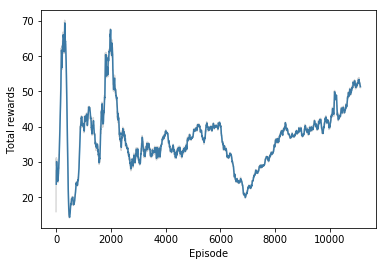

In [17]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

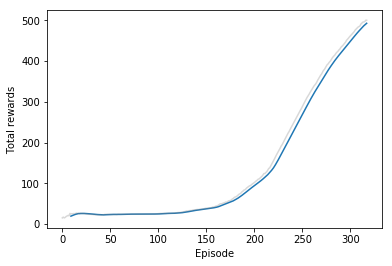

In [22]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

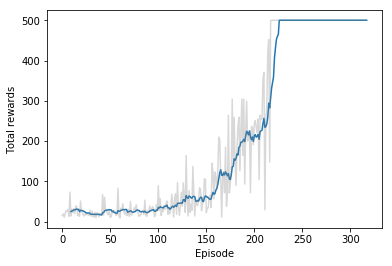

In [23]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Act losses')

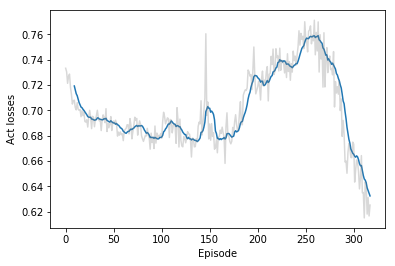

In [24]:
eps, arr = np.array(aloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses')

Text(0, 0.5, 'Env losses')

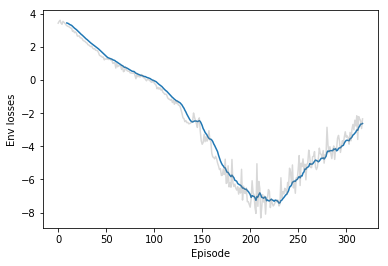

In [25]:
eps, arr = np.array(eloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Env losses')

Text(0, 0.5, 'Act losses 2')

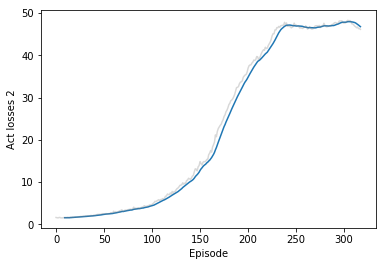

In [26]:
eps, arr = np.array(aloss2_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Act losses 2')

## Testing

Let's checkout how our trained agent plays the game.

In [21]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
